# Packages

## Import

In [1]:
import serial
import re
import numpy as np
import math
# import syslog
import time
import matplotlib.tri as tri
from struct import *
import torch
# import pypot.dynamixel
import sys
from scipy.interpolate import make_interp_spline, BSpline
from scipy.optimize import curve_fit
# import pyqtgraph as pg
import cv2
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from ipykernel import kernelapp as app
# from scipy.optimize import curve_fit

# from PyQt5 import QtGui, QtCore
# from scipy import optimize

# import nidaqmx
# import atiiaftt

import io
import socket
import struct
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import torchvision.transforms.functional as TF
from matplotlib import colors

import os
from torchvision import datasets, models, transforms

%matplotlib notebook

In /is/sg/shuanbo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /is/sg/shuanbo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /is/sg/shuanbo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /is/sg/shuanbo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /is/sg/shuanbo/.local/lib/python3.6/site-packages/matplotlib/

In [2]:
%matplotlib notebook
from ipykernel import kernelapp as app
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
colors__ = [(0.368, 0.507, 0.71), (0.881, 0.611, 0.142),
          (0.56, 0.692, 0.195), (0.923, 0.386, 0.209),
          (0.528, 0.471, 0.701), (0.772, 0.432, 0.102),
          (0.364, 0.619, 0.782), (0.572, 0.586, 0.) ]  # the last one is a darker green

def darker(color,factor=0.87):
    r,g,b = color
    return (r*factor,g*factor,b*factor)

# \definecolor{ourred}{rgb}{0.923,0.386,0.209} % "#eb6235" 
# \definecolor{ourgreen}{rgb}{0.56,0.692,0.195} % "#8fb032"
# \definecolor{ourblue}{rgb}{0.368,0.507,0.71} % "#5e81b5"
# \definecolor{ourdarkgreen}{rgb}{0.572,0.586,0.} % "#929600"
# \definecolor{ourlightblue}{rgb}{0.364,0.619,0.782} % "#5d9ec7"
# \definecolor{ourorange}{rgb}{0.881,0.611,0.142} % "#e19c24"
# \definecolor{ourviolet}{rgb}{0.528,0.471,0.701} % "#8778b3" 
# \definecolor{ourbrown}{rgb}{0.772,0.432,0.102} % "#c56e1a"
# ["#eb6235", "#8fb032", "#5e81b5", "#929600", "#5d9ec7", "#e19c24", "#8778b3","#c56e1a"]

## DIY1

In [7]:
def initialization():
    ard.flush()
    text = '0.0,'+str(1e-6)+','+str(1e-6)+','+str(1e-6)
    ard.write(text)
    time.sleep(0.01)	

def goto_position(x,y,z,speed):
    ard.flush()
    text = '1.0,'+str(x+1e-6)+','+str(y+1e-6)+','+str(z+1e-6)+','+str(speed+1e-6)
    ard.write(text)
    time.sleep(0.01)

def get_position():
    ard.flush()
    text = '2.0,0.000001,0.000001,0.000001'
    ard.write(text)
    time.sleep(0.1)
    msg = np.array(ard.readline().encode("utf-8").split(" ")[1:4],dtype=float)
    return(msg)

def get_force_():
    while True:
        data= opto.read(4)
        header= unpack('BBBB', data)
        if header==(170, 7, 8, 10): #data
            data= opto.read(12)
            counter= unpack('>H', data[0:2])[0]
            status= unpack('>H', data[2:4])[0]
            xyz= unpack('>hhh', data[4:10])
            checksum= unpack('>H', data[10:12])[0]
            force = np.array(xyz,dtype=float)/16038*40.0 ##[N] /9.8*1000.0##[gf]
            force[0] -= (-11.2/1000.0*9.8)
            force[1] -= (+11.0/1000.0*9.8)
            force[2] -= (-23.0/1000.0*9.8)
            break
    return(force)

def imaging(receving):
    image_len = struct.unpack('<L', receving.read(struct.calcsize('<L')))[0]
    image_stream = io.BytesIO()
    image_stream.write(receving.read(image_len))
    image_stream.seek(0)
    image = Image.open(image_stream)
    return image

def reject_outliers(data, m=2):
    return data[abs(data - np.median(data)) < m * np.std(data)]

## DIY2

In [ ]:
class MyThread(QtCore.QThread):
    signal = QtCore.pyqtSignal(object)
    def __init__(self, parent=None):
        super(MyThread, self).__init__(parent=parent)
        self.data = get_force().reshape(1,3)

    def __del__(self):
        self.exiting = True
        self.wait()

    def run(self):
        while True:
            self.data = np.concatenate((self.data,get_force().reshape(1,3)),axis=0)
            if self.data.shape[0]>1000:
                self.data = self.data[self.data.shape[0]-1000:self.data.shape[0],:]
            self.signal.emit(self.data)
            time.sleep(0.001)
#     def __init__(self, parent=None):
#         super(MyThread, self).__init__(parent=parent)
#         self.data = get_force()[:3].reshape(1,3)

#     def __del__(self):
#         self.exiting = True
#         self.wait()

#     def run(self):
#         while True:
#             self.data = np.concatenate((self.data,get_force()[:3].reshape(1,3)),axis=0)
#             if self.data.shape[0]>1000:
#                 self.data = self.data[self.data.shape[0]-1000:self.data.shape[0],:]
#             self.signal.emit(self.data)
#             time.sleep(0.001)


class LoginWidget(QtGui.QWidget):
    def __init__(self, parent=None):
        super(LoginWidget, self).__init__(parent)

        self.myThread = MyThread()
        layout = QtGui.QGridLayout()
        self.label_i = QtGui.QLabel("Initialization",self)
        self.button4 = QtGui.QPushButton('Initialization',self) 
        self.label_p = QtGui.QLabel("Plot",self)
        self.button1 = QtGui.QPushButton('Plot',self) 
        self.label_a = QtGui.QLabel("Goto:Position",self)
        self.label_wx = QtGui.QLabel('X(0-300):',self)
        self.input_wx = QtGui.QLineEdit()
        self.label_wy = QtGui.QLabel('Y(0-480):',self)
        self.input_wy = QtGui.QLineEdit()
        self.label_wz = QtGui.QLabel('Z(0-80):',self)
        self.input_wz = QtGui.QLineEdit()
        self.button2 = QtGui.QPushButton('Send Action',self)
        self.label_r = QtGui.QLabel("Current Position",self)
        self.button3 = QtGui.QPushButton('Get Position',self) 
        self.label_rx = QtGui.QLabel('X:',self)
        self.label_rx_v = QtGui.QLabel(' ',self)
        self.label_ry = QtGui.QLabel('Y:',self)
        self.label_ry_v = QtGui.QLabel(' ',self)  
        self.label_rz = QtGui.QLabel('Z:',self)
        self.label_rz_v = QtGui.QLabel(' ',self)
        self.plot = pg.PlotWidget()

        self.setLayout(layout)
        layout.addWidget(self.label_i,0,0,1,3)
        layout.addWidget(self.button4,1,0,1,3)
        layout.addWidget(self.label_p,0,3,1,3)
        layout.addWidget(self.button1,1,3,1,3)       
        layout.addWidget(self.label_a,3,0,1,6)
        layout.addWidget(self.label_wx,4,0,1,1)
        layout.addWidget(self.input_wx,4,1,1,1)
        layout.addWidget(self.label_wy,4,2,1,1)
        layout.addWidget(self.input_wy,4,3,1,1)
        layout.addWidget(self.label_wz,4,4,1,1)
        layout.addWidget(self.input_wz,4,5,1,1)
        layout.addWidget(self.button2,5,0,1,6)
        
        layout.addWidget(self.label_r,7,0,1,6)
        layout.addWidget(self.button3,8,0,1,6)
        layout.addWidget(self.label_rx,9,0,1,1)
        layout.addWidget(self.label_rx_v,9,1,1,1)
        layout.addWidget(self.label_ry,9,2,1,1)
        layout.addWidget(self.label_ry_v,9,3,1,1)
        layout.addWidget(self.label_rz,9,4,1,1)
        layout.addWidget(self.label_rz_v,9,5,1,1)
        
        layout.addWidget(self.plot,0,7,10,10)
        
        self.plot.addLegend()
        self.curve1 = self.plot.getPlotItem().plot(name='Fx')
        self.curve2 = self.plot.getPlotItem().plot(name='Fy')
        self.curve3 = self.plot.getPlotItem().plot(name='Fz')
        self.plot.setLabels(bottom='time[ms]',left='Force[gf]')

        self.button1.clicked.connect(self.start)
        self.button2.clicked.connect(self.taking_action)
        self.button3.clicked.connect(self.get_pos)
        self.button4.clicked.connect(self.initialization)

    def initialization(self):
        initialization()
        
    def get_pos(self):
        pos = get_position()
        self.label_rx_v.setText(str(pos[1]))
        self.label_ry_v.setText(str(pos[2]))
        self.label_rz_v.setText(str(pos[3]))        

    def taking_action(self):
        x = float(self.input_wx.text())
        y = float(self.input_wy.text())
        z = float(self.input_wz.text())
        goto_position(x,y,z)

    def plotter(self, data):

        self.curve1.setData(data[:,0],pen=(255,0,0))
        self.curve2.setData(data[:,1],pen=(0,255,0))
        self.curve3.setData(data[:,2],pen=(0,0,255))

    def start(self):
        self.myThread.start()
        self.myThread.signal.connect(self.plotter)

class MainWindow(QtGui.QMainWindow):

    def __init__(self, parent=None):
        super(MainWindow, self).__init__(parent)

        self.centralwidget = QtGui.QWidget(self)
        self.setCentralWidget(self.centralwidget)
        self.horizontalLayout = QtGui.QHBoxLayout(self.centralwidget)
        self.login_widget_1 = LoginWidget(self)
        self.horizontalLayout.addWidget(self.login_widget_1)
        self.setCentralWidget(self.centralwidget)

# Communication

In [ ]:
## COM4 COM8: [0][1]
## COM8 COM4: [1][0]

port = pypot.dynamixel.get_available_ports()
print('ports found',port)
motor = pypot.dynamixel.DxlIO(port[2],115200,use_sync_read=False)
ard = serial.Serial(port[1],115200)
# opto = serial.Serial(port[0],115200)

In [ ]:
task = nidaqmx.Task()
for i in range(6):
    task.ai_channels.add_ai_voltage_chan('Dev1/ai'+str(i))   
DAQ_bias = []
for i in range(10):
    DAQ_bias.append(task.read())
    
ATI_Mini = atiiaftt.FTSensor()
ATI_Mini.createCalibration('../TestBed1/ATI/ATI_CD/Calibration/FT29670.cal',1)
ATI_Mini.setToolTransform([0,0,41,0,0,0],atiiaftt.FTUnit.DIST_MM,atiiaftt.FTUnit.ANGLE_DEG)
ATI_Mini.bias(np.mean(DAQ_bias,axis=0).tolist())

def get_force():
    force = np.zeros((5,6))
    for i in range(5):
        force[i,:] = ATI_Mini.convertToFt(task.read())
    return np.mean(force,axis=0)

In [ ]:
server_socket = socket.socket()
server_socket.bind(('0.0.0.0', 8000))
server_socket.listen(0)

connection = server_socket.accept()
connection[0].send('how is it going')
receving = connection[0].makefile('rb')

# Initialization

In [ ]:
initialization()

In [ ]:
for i in range(5):
#     motor.set_goal_position_speed_load({1:(0,0.01,10)})
#     motor.set_goal_position_speed_load({2:(0,0.01,10)})
#     motor.set_goal_position({1:0})
#     motor.set_goal_position({2:0})
    initialization()
    ATI_Mini.convertToFt(task.read())
    time.sleep(1)

# Data Collection

In [ ]:
# Data
inner_surface = np.loadtxt("../Data/Information/InnerSurfaceNode.txt",skiprows=1)
inner_surface1 = np.loadtxt("../Data/Information/InnerSurfaceNode1.txt",skiprows=1)
inner_surface2 = np.loadtxt("../Data/Information/InnerSurfaceNode2.txt",skiprows=1)
inner_surface3 = np.loadtxt("../Data/Information/InnerSurfaceNode3.txt",skiprows=1)

outer_surface = np.loadtxt("../Data/Information/OuterSurfaceNode.txt",skiprows=1)
outer_surface1 = np.loadtxt("../Data/Information/OuterSurfaceNode1.txt",skiprows=1)
outer_surface2 = np.loadtxt("../Data/Information/OuterSurfaceNode2.txt",skiprows=1)
outer_surface3 = np.loadtxt("../Data/Information/OuterSurfaceNode3.txt",skiprows=1)
outer_surface4 = np.loadtxt("../Data/Information/OuterSurfaceNode4.txt",skiprows=1)
outer_surface5 = np.loadtxt("../Data/Information/OuterSurfaceNode5.txt",skiprows=1)
outer_surface6 = np.loadtxt("../Data/Information/OuterSurfaceNode6.txt",skiprows=1)
outer_surface7 = np.loadtxt("../Data/Information/OuterSurfaceNode7.txt",skiprows=1)
outer_surface8 = np.loadtxt("../Data/Information/OuterSurfaceNode8.txt",skiprows=1)

connector_surface = np.loadtxt("../Data/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../Data/Information/SkeletonSurfaceNode.txt",skiprows=1)
indenter_surface = np.loadtxt("../Data/Information/IndenterSurfaceNode.txt",skiprows=1)

In [ ]:
fig = plt.figure()
plt.scatter()

In [ ]:
goto_position(124.3,159.0,5,1)
motor.set_goal_position_speed_load({1:(0,0.01,10)})
motor.set_goal_position_speed_load({2:(0,0.01,10)})

In [ ]:
outer_surface4578 = np.concatenate((outer_surface4,outer_surface5,outer_surface7,outer_surface8),axis=0)

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz(testbed);8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface.
# 0,1,2,3: Node ID and Position xyz in[mm]
shape_size = outer_surface6.shape[0]
indentation_info = np.zeros((shape_size,14))
indentation_info[:,:4] = outer_surface6
indentation_info[:,1:4] = indentation_info[:,1:4]*1000.0
sort_index = np.argsort(indentation_info[:,3])
indentation_info = indentation_info[sort_index,:]

# 4: Sampling ID
indentation_info[:,4] = np.linspace(0,shape_size-1,shape_size)

# 8:M1
for i in range(shape_size):
    if indentation_info[i,1]!=0.0:
        indentation_info[i,8] = np.arctan2(indentation_info[i,1],indentation_info[i,2])/np.pi*180.0-np.sign(indentation_info[i,1])*180.0
    elif indentation_info[i,2]<0.0:
        indentation_info[i,8] = 0.0
    else:
        indentation_info[i,8] = 180.0

# 9:M2        
for i in range(shape_size):
    if indentation_info[i,3]<7.14:
        indentation_info[i,9] = -90.0
    elif indentation_info[i,3]<58.93:
        indentation_info[i,9] = -90.0 + 11.13
    else:
        indentation_info[i,9] = np.arcsin((indentation_info[i,3]-57.0)/10.0)/np.pi*180.0 - 90.0

# 5,6,7:Testbed Position xyz in [mm]
indentation_info[:,5] = 124.3
for i in range(shape_size):
    indentation_info[i,6] = 159 - (81.5 + indentation_info[i,3]) * np.sin(-indentation_info[i,9]/180.0*np.pi)+np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.cos(-indentation_info[i,9]/180.0*np.pi)
    indentation_info[i,7] = 161 - (81.5 + indentation_info[i,3])*np.cos(-indentation_info[i,9]/180.0*np.pi) - np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.sin(-indentation_info[i,9]/180.0*np.pi)

# 10,11,12: Indentation Transform 
for i in range(shape_size):    
    alpha = np.arctan2(indentation_info[i,2],indentation_info[i,1])
    if indentation_info[i,3]<7.14:
        sita = 0
    elif indentation_info[i,3]<58.93:
        sita = 11.13/180.0*np.pi
    else:
        sita = np.arcsin((indentation_info[i,3]-57.0)/10.0) 

    indentation_info[i,10] = 2 * np.cos(sita) * np.cos(alpha) + indentation_info[i,1]
    indentation_info[i,11] = 2 * np.cos(sita) * np.sin(alpha) + indentation_info[i,2]
    indentation_info[i,12] = 2 * np.sin(sita) +indentation_info[i,3] - 69.0

# 13: Contact Surface
    distance1 = np.min(np.linalg.norm(outer_surface1[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance2 = np.min(np.linalg.norm(outer_surface2[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance3 = np.min(np.linalg.norm(outer_surface3[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance4 = np.min(np.linalg.norm(outer_surface4[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance5 = np.min(np.linalg.norm(outer_surface5[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance6 = np.min(np.linalg.norm(outer_surface6[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance7 = np.min(np.linalg.norm(outer_surface7[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance8 = np.min(np.linalg.norm(outer_surface8[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance = [distance1,distance2,distance3,distance4,distance5,distance6,distance7,distance8]
    surface_index = np.argmin(distance)+1
    indentation_info[i,13] = surface_index

np.save("../Data/Information/00_OuterSurface_info_6.npy",indentation_info)

In [ ]:
indentation_info1 = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
indentation_info2 = np.load("../Data/Information/00_OuterSurface_info_2.npy")[650:]*1000.0
indentation_info3 = np.load("../Data/Information/00_OuterSurface_info_3.npy")
indentation_info4578 = np.load("../Data/Information/00_OuterSurface_info_4578.npy")
indentation_info6 = np.load("../Data/Information/00_OuterSurface_info_6.npy")
# Fig
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(skeleton_surface[:,1]*1000.0,skeleton_surface[:,2]*1000.0,skeleton_surface[:,3]*1000.0,s=2,c='gray')
ax.scatter(indentation_info2[:,1],indentation_info2[:,2],indentation_info2[:,3],s=3,c='r')
# ax.scatter(indentation_info6[:,1],indentation_info6[:,2],indentation_info6[:,3],s=3,c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
### 1.6mm--1.6N; 10mm--1.6N.
ground = get_force()
motor.set_goal_position_speed_load({1:(-45,0.01,10)})
motor.set_goal_position_speed_load({2:(-75,0.01,10)})
goto_position(124.3,42,117-5,1)
get_force()-ground

In [ ]:
indentation_info1.shape

In [ ]:
i = 3138
indentation_info = indentation_info2
motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+0.0,1)

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
sampling_count = 0
folderfile_count = 0.0
folder = 0
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
# indentation_info = indentation_info3
for i in range(3138,-1,-5):
    print(i)
    
# step(v)
    min_distance = np.min(np.linalg.norm(skeleton_surface[:,1:4]*1000.0-indentation_info[i,1:4], axis=1))
    step_z = 0.4
    step_xy = 0.1
    force_z = 2.0
    force_xy = 2.0
    force_total = 2.0
    # init(v)
    time.sleep(1)
    force_original = get_force()
    time.sleep(1)
    force_info = np.zeros((1,28))
    
# motor(v)    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break
    
# xy(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-0.0,1)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1.0 or abs(indentation_info[i,6]-get_position()[1])>1.0 or abs(indentation_info[i,7]-3.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-3.0,1)
            time.sleep(0.1)
        else:
            print("xy done")
            break
# z(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7],1)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7],1)
            time.sleep(0.1)
        else:
            print("z done")
            time.sleep(0.1)
            break
# contact(v)
    m2_buffer = 2.0
    while(True):
        ffff = np.subtract(get_force()[:3],force_original[:3])
        if np.linalg.norm(ffff)<0.03:
            m2_buffer += 0.1
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer,1)
            time.sleep(0.1)
        else:
            print("contact established")
            break

# collection
    indentation_info[i,7] += m2_buffer
    count = 0
    print("Collecting")
    while(True):
        force_buffer = np.zeros((28))
        count += 1.0
        
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5]+count*step_xy,indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(1.5)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5]-count*step_xy,indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(1.5)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(0.5)
        
        goto_position(indentation_info[i,5],indentation_info[i,6]+count*step_xy,indentation_info[i,7]+count*step_z,1)
        time.sleep(1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5],indentation_info[i,6]-count*step_xy,indentation_info[i,7]+count*step_z,1)
        time.sleep(1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:21])>force_total:
            break
        
    print("force:"+str(force_buffer[18:21]))
    print("sampling_count"+str(sampling_count))
    np.save("../Data/RawImage/Data"+str(folder)+"/force"+str(i)+".npy",force_info[1:])
    
# figure(v)
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

# left(v)
    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-3.0,1)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-3.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-3.0,1)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    time.sleep(0.2)

# finish(v)
    folderfile_count += 1.0
    if folderfile_count >= 100.0:
        folder += 1
        folderfile_count = 0

In [ ]:
for kk in range(10):
    connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
    time.sleep(0.1)
    image = imaging(receving)
    image.save("../Data/RawImage/Reference"+str(kk)+".png")

In [ ]:
a = np.load("../Data/RawImage/Data39/force92.npy")
a[-1,]

# Data Processing

## Force Coordinate Transfer and Image Resize
- 187358 samples 

In [ ]:
def force_transfer(force_sample):
    alpha = np.arctan2(force_sample[2],force_sample[1])
    if force_sample[3]<7.14:
        sita = 0
    elif force_sample[3]<58.93:
        sita = 11.13/180.0*np.pi
    else:
        sita = np.arcsin((force_sample[3]-57.0)/10.0) 
    fx =   force_sample[18]*np.sin(alpha) + (-force_sample[19]*np.sin(sita)+force_sample[20]*np.cos(sita))*np.cos(alpha)
    fy = - force_sample[18]*np.cos(alpha) + (-force_sample[19]*np.sin(sita)+force_sample[20]*np.cos(sita))*np.sin(alpha)
    fz =   force_sample[19]*np.cos(sita) + force_sample[20]*np.sin(sita)
    force_sample[24] = fx
    force_sample[25] = fy
    force_sample[26] = fz
    return force_sample

preprocess = transforms.Compose([
    transforms.Resize(308),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
folder = 2
position_index = []
for i in range(4000,-1,-1):
    try:
        force = np.load("../Data/Validation3_RawImage/Data"+str(folder)+"/force"+str(i)+".npy")
        position_index.append(i)
    except:
        continue

for i in position_index:
    force = np.load("../Data/Validation3_RawImage/Data"+str(folder)+"/force"+str(i)+".npy")
    for j in range(force.shape[0]):
        force[j] = force_transfer(force[j])
        image = Image.open("../Data/Validation3_RawImage/Data"+str(folder)+"/"+str(int(force[j,27]))+".png")
        image_1 = preprocess(image)
        image_1.save("../Data/PostData/Data20/Resized"+str(int(force[j,27]))+".png")
        np.save("../Data/PostData/Data20/Reformulated_force"+str(int(force[j,27]))+".npy",force[j])
        print(i,force[j,27])

In [ ]:
image = Image.open("../Data/RawImage/Reference0.png")
image_1 = preprocess(image)
image_1.save("../Data/PostData/Data0/Resized_nocontact.png")
fig = plt.figure()
plt.imshow(image_1)

In [ ]:
np.load("../Data/PostData/Data0/Reformulated_force"+str(187357)+".npy")

In [ ]:
ground_truth_force = np.zeros((1,28))
count = 0
for i in range(187358):
    force_sample = np.load("../Data/PostData/Data0/Reformulated_force"+str(i)+".npy")
    ground_truth_force = np.vstack((ground_truth_force,force_sample))
    if count %50 ==49:
        print(count)
    count += 1
np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy",ground_truth_force[1:])

In [ ]:
ground = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
ground_rescale = 0*ground
max_ = np.max(ground,axis=0)
min_ = np.min(ground,axis=0)
count = 0
for i in range(ground.shape[0]):
    ground_rescale[i] = (ground[i]-min_)/(max_-min_+1e-10)
    if count %50 ==49:
        print(count)
    count += 1
np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_1.npy",ground_rescale)

In [ ]:
ground_truth_force = np.zeros((1,28))
count = 0
for i in range(187358):
    try:
        force_sample = np.load("../Data/PostData/Data20/Reformulated_force"+str(i)+".npy")
        ground_truth_force = np.vstack((ground_truth_force,force_sample))
        if count %50 ==49:
            print(count)
        count += 1
    except:
        break
np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_validation3.npy",ground_truth_force[1:])

In [ ]:
xxx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_1.npy")
np.save("/is/rg/al/Private/shuanbo/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_1.npy",xxx)

## Forcemap Generation

In [ ]:
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")

In [ ]:
#### distance 1: np.exp(-0.5* abs(xs)*2.0)
#### distance 2: np.exp(-0.5* abs(xs)*1.15)
#### distance 3: np.exp(-0.5* abs(xs)/1.0)
#### distance 4: np.exp(-0.5* xs**2/1.6)
#### distance 5: np.sqrt(1-np.clip(xs,-2,2)**2/4)

distance1 = np.zeros((3800,3800))
for i in range(3800):
    print(i)
    distance1[i,:] = np.exp(-0.5*np.linalg.norm(indentation_info[:,1:4]-indentation_info[i,1:4], axis=1)*2.0)
    for j in range(3800):
        if np.linalg.norm(indentation_info[j,1:4]-indentation_info[i,1:4])>4.0:
            distance1[i,j]=0
np.save("../Data/PostData/Data1/Distance1.npy",distance1)

# indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
# col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
# distance2 = np.zeros((3800,3800))
# for i in range(3800):
#     print(i)
#     distance2[i,:] = np.exp(-0.5*np.linalg.norm(indentation_info[:,1:4]-indentation_info[i,1:4], axis=1)*1.15)
#     for j in range(3800):
#         if np.linalg.norm(indentation_info[j,1:4]-indentation_info[i,1:4])>4.0:
#             distance2[i,j]=0
# np.save("../Data/PostData/Data2/Distance2.npy",distance2)

# indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
# col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
# distance3 = np.zeros((3800,3800))
# for i in range(3800):
#     print(i)
#     distance3[i,:] = np.exp(-0.5*np.linalg.norm(indentation_info[:,1:4]-indentation_info[i,1:4], axis=1))
#     for j in range(3800):
#         if np.linalg.norm(indentation_info[j,1:4]-indentation_info[i,1:4])>4.0:
#             distance3[i,j]=0
# np.save("../Data/PostData/Data3/Distance3.npy",distance3)

# indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
# col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
# distance4 = np.zeros((3800,3800))
# for i in range(3800):
#     print(i)
#     distance4[i,:] = np.exp(-0.5*np.linalg.norm(indentation_info[:,1:4]-indentation_info[i,1:4], axis=1)**2.0/1.6)
#     for j in range(3800):
#         if np.linalg.norm(indentation_info[j,1:4]-indentation_info[i,1:4])>4.0:
#             distance4[i,j]=0
# np.save("../Data/PostData/Data4/Distance4.npy",distance4)

# indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
# col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
# distance5 = np.zeros((3800,3800))
# for i in range(3800):
#     print(i)
#     distance5[i,:] = np.linalg.norm(indentation_info[:,1:4]-indentation_info[i,1:4], axis=1)
#     for j in range(3800):
#         if np.linalg.norm(indentation_info[j,1:4]-indentation_info[i,1:4])>2.0:
#             distance5[i,j]=0
#         else:
#             distance5[i,j] = np.sqrt(1-distance5[i,j]**2/4)
# np.save("../Data/PostData/Data5/Distance5.npy",distance5)

In [ ]:
for distance_index in [1,2,3,4,5]:
    distance = np.load("../Data/PostData/Data"+str(distance_index)+"/Distance"+str(distance_index)+".npy") 
    for i in range(187358):
        force = np.load("../Data/PostData/Data0/Reformulated_force"+str(i)+".npy")
        for j in range(3800):
            if force[0] == indentation_info[j,0]:
                map = np.zeros((3,64*64))
                a1 = force[24]/np.sum(distance[j])
                map[0,col_ind] = a1*distance[j]
                a2 = force[25]/np.sum(distance[j])
                map[1,col_ind] = a2*distance[j]
                a3 = force[26]/np.sum(distance[j])
                map[2,col_ind] = a3*distance[j]
                map = map.reshape(3,64,64)
                map[0] = np.flipud(map[0])
                map[1] = np.flipud(map[1])
                map[2] = np.flipud(map[2])
                map = torch.from_numpy(map).float()
                torch.save(map, "../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt")
                break
        print(i,j)

<IPython.core.display.Javascript object>


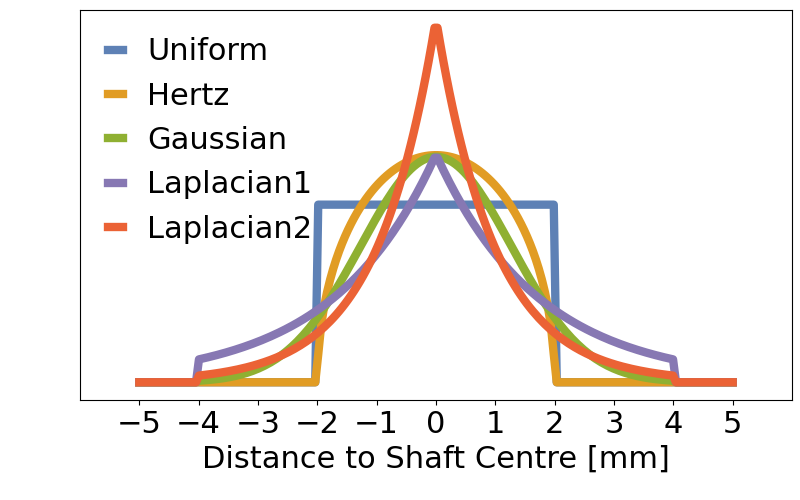

In [17]:
#### approximation in 1D
fig = plt.figure(figsize=(8,5))
xs = np.linspace(-5,5,200)

ys3 = np.exp(-0.5* abs(xs))*0+1.0
ys3_index = np.where(abs(xs)>2.0)
ys3[ys3_index]=0
plt.plot(xs,ys3/np.sum(ys3),label="Uniform",linewidth=6,c=colors__[0])

ys5= np.sqrt(1-np.clip(xs,-2,2)**2/4)
plt.plot(xs,ys5/np.sum(ys5),label="Hertz",linewidth=6,c=colors__[1])


ys4 = np.exp(-0.5* xs**2/1.6)
ys4_index = np.where(abs(xs)>4.0)
ys4[ys4_index]=0
plt.plot(xs,ys4/np.sum(ys4),label="Gaussian",linewidth=6,c=colors__[2])

ys2 = np.exp(-0.5* abs(xs)*1.15)
ys2_index = np.where(abs(xs)>4.0)
ys2[ys2_index]=0
plt.plot(xs,ys2/np.sum(ys2),label="Laplacian1",linewidth=6,c=colors__[4])

ys1 = np.exp(-0.5* abs(xs)*2.0)
ys1_index = np.where(abs(xs)>4.0)
ys1[ys1_index]=0
plt.plot(xs,ys1/np.sum(ys1),label="Laplacian2",linewidth=6,c=colors__[3])

# print(np.sum(ys1),np.sum(ys2),np.sum(ys3),np.sum(ys4),np.sum(ys5))

plt.xticks(np.arange(-5.0,5.1,1),fontsize=22)
# plt.yticks(np.linspace(-0,0.02,3),fontsize=22,fontstyle='italic',rotation=90)
plt.yticks([])
plt.xlim([-6,6])
plt.xlabel("Distance to Shaft Centre [mm]",fontsize=22)
plt.legend(ncol=1,loc="upper left",fontsize=22,columnspacing=0.1,handlelength=0.5,framealpha=0.0)
plt.subplots_adjust(0.1,0.20,0.99,0.98)

plt.savefig("../../Figure/FigureS6_Rebuttal_Approximation_final.png",transparent=True)

In [ ]:

sigma=3
#### approximation in 1D
fig = plt.figure(figsize=(8,5))
xs = np.linspace(-20,20,400)

ys3 = xs*0 + 1.0
ys3_index = np.where(abs(xs)>sigma)
ys3[ys3_index]=0
plt.plot(xs,ys3/np.sum(ys3),label="Uniform",linewidth=6,c=colors__[0])

ys5= np.sqrt(1-(np.clip(xs,-sigma,sigma)/sigma)**2)
plt.plot(xs,ys5/np.sum(ys5),label="Hertz",linewidth=6,c=colors__[1])


ys4 = np.exp(-0.5* xs**2/(0.4*sigma**2))
ys4_index = np.where(abs(xs)>2*sigma)
ys4[ys4_index]=0
plt.plot(xs,ys4/np.sum(ys4),label="Gaussian",linewidth=6,c=colors__[2])

ys2 = np.exp(-abs(xs)/(0.87*sigma))
ys2_index = np.where(abs(xs)>2*sigma)
ys2[ys2_index]=0
plt.plot(xs,ys2/np.sum(ys2),label="Laplacian1",linewidth=6,c=colors__[4])

ys1 = np.exp(-abs(xs)/(0.5*sigma))
ys1_index = np.where(abs(xs)>2*sigma)
ys1[ys1_index]=0
plt.plot(xs,ys1/np.sum(ys1),label="Laplacian2",linewidth=6,c=colors__[3])

# print(np.sum(ys1),np.sum(ys2),np.sum(ys3),np.sum(ys4),np.sum(ys5))

plt.xticks(np.arange(-5.0,5.1,1),fontsize=22,fontstyle='italic')
# plt.yticks(np.linspace(-0,0.02,3),fontsize=22,fontstyle='italic',rotation=90)
plt.yticks([])
plt.xlim([-6,6])
plt.xlabel("Distance to Shaft Center [mm]",fontsize=22,fontstyle='italic')
plt.legend(ncol=1,loc="upper left",fontsize=22,columnspacing=0.1,handlelength=0.5,framealpha=0.0)
plt.subplots_adjust(0.1,0.20,0.99,0.98)

# plt.savefig("../../Figure/FigureS6_Rebuttal_Approximation.png",transparent=True)

In [ ]:
#### visualization in 2D
i =np.random.randint(187358)

print(i)
fig = plt.figure(figsize=(20,5))
plt.subplot(151)
distance_index = 1
x = torch.load("../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt")
vmax = torch.max(x[0])
plt.imshow(x[0],vmax = vmax )
plt.subplot(152)
distance_index = 2
x = torch.load("../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt")
plt.imshow(x[0],vmax = vmax )
plt.subplot(153)
distance_index = 3
x = torch.load("../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt")
plt.imshow(x[0],vmax = vmax )
plt.subplot(154)
distance_index = 4
x = torch.load("../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt")
plt.imshow(x[0],vmax = vmax )
plt.subplot(155)
distance_index = 5
x = torch.load("../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt")
plt.imshow(x[0],vmax = vmax )

In [ ]:
# Data
inner_surface = np.loadtxt("../Data/Information/InnerSurfaceNode.txt",skiprows=1)
inner_surface1 = np.loadtxt("../Data/Information/InnerSurfaceNode1.txt",skiprows=1)
inner_surface2 = np.loadtxt("../Data/Information/InnerSurfaceNode2.txt",skiprows=1)
inner_surface3 = np.loadtxt("../Data/Information/InnerSurfaceNode3.txt",skiprows=1)

outer_surface = np.loadtxt("../Data/Information/OuterSurfaceNode.txt",skiprows=1)
outer_surface1 = np.loadtxt("../Data/Information/OuterSurfaceNode1.txt",skiprows=1)
outer_surface2 = np.loadtxt("../Data/Information/OuterSurfaceNode2.txt",skiprows=1)
outer_surface3 = np.loadtxt("../Data/Information/OuterSurfaceNode3.txt",skiprows=1)
outer_surface4 = np.loadtxt("../Data/Information/OuterSurfaceNode4.txt",skiprows=1)
outer_surface5 = np.loadtxt("../Data/Information/OuterSurfaceNode5.txt",skiprows=1)
outer_surface6 = np.loadtxt("../Data/Information/OuterSurfaceNode6.txt",skiprows=1)
outer_surface7 = np.loadtxt("../Data/Information/OuterSurfaceNode7.txt",skiprows=1)
outer_surface8 = np.loadtxt("../Data/Information/OuterSurfaceNode8.txt",skiprows=1)

connector_surface = np.loadtxt("../Data/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../Data/Information/SkeletonSurfaceNode.txt",skiprows=1)*1000.0
indenter_surface = np.loadtxt("../Data/Information/IndenterSurfaceNode.txt",skiprows=1)

In [ ]:
fig =plt.figure(figsize=(12,12))
distance_index =5
i = np.random.randint(187358)
force = torch.load("../Data/PostData/Data"+str(distance_index)+"/Map"+str(distance_index)+"_"+str(i)+".txt").numpy()
force_ = np.zeros((3,4096))
force_[0] = np.flipud(force[0]).flatten()
force_[1] = np.flipud(force[1]).flatten()
force_[2] = np.flipud(force[2]).flatten()
force_ = force_[:,col_ind]
image_2 = force_vector(fig,force_,0)

In [ ]:
grey_skel = (0.8,0.8,0.8)
grey_surf = (0.6,0.6,0.6,0.5)
arrowscale=1
fs = 28
def force_vector(fig, force,threashold):
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    font.set_style('italic')
    font.set_size(fs)
    
    filter_points = np.intersect1d(np.where(np.linalg.norm(force,axis=0)>threashold),np.where(indentation_info[:,3]>20))
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(skeleton_surface[:,1],skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax4.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax4.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],indentation_info[filter_points,3],force[0,filter_points]*400.0,force[1,filter_points]*400.0,force[2,filter_points]*400.0,color=colors[3])
#     ax4.set_xlabel('X',fontproperties=font)
#     ax4.set_ylabel('Y',fontproperties=font)
#     ax4.set_zlabel('Z',fontproperties=font)
#     plt.xticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
#     plt.yticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
    ax4.set_box_aspect([1,1,1])
    plt.xlim([-35,35]) 
    plt.ylim([-35,35])
    # z is 0-70
#     ax4.set_zticks(np.arange(-0, 60.1, 60))
    ax4.zaxis.set_tick_params(labelsize=20)
    ax4.view_init(35,-105)
    plt.grid("off")
    plt.axis("off")

    ax3 = fig.add_subplot(223)
    ax3.scatter(skeleton_surface[:,1],skeleton_surface[:,2],s=1,color=grey_skel,alpha=0.2)
    ax3.scatter(indentation_info[:,1],indentation_info[:,2],s=1,color=grey_surf)
    ax3.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],force[0,filter_points],force[1,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax3.set_xlabel('X [mm]',fontproperties=font)
    ax3.set_ylabel('Y [mm]',fontproperties=font)
    plt.axis('equal')
    plt.xlim([-35,35])
    plt.ylim([-35,35])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax2 = fig.add_subplot(222)
    ax2.scatter(skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax2.scatter(indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax2.quiver(indentation_info[filter_points,2],indentation_info[filter_points,3],-force[1,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax2.set_xlabel('Y [mm]',fontproperties=font)
    ax2.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([35,-35])
    plt.ylim([0,70])
    plt.xticks(np.arange(20, -20.1, -20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax1 = fig.add_subplot(221)
    ax1.scatter(skeleton_surface[:,1],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax1.scatter(indentation_info[:,1],indentation_info[:,3],s=1,color=grey_surf)
    ax1.quiver(indentation_info[filter_points,1],indentation_info[filter_points,3],force[0,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax1.set_xlabel('X [mm]',fontproperties=font)
    ax1.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([-35,35])
    plt.ylim([0,70])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")
    ax4.dist=5.8

    
    plt.subplots_adjust(0.08,0.08,0.99,0.99)
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(1232,1232))
    return img

## Data Splitting

In [ ]:
#### assumed 3800 contact points, real 3737 contact points
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
position_index = []
for i in range(187358):
    if i%5000 ==4999:
        print(i)
    k = np.load("../Data/PostData/Data0/Reformulated_force"+str(i)+".npy")
    position_index.append(int(k[0]))
print(indentation_info.shape, np.unique(position_index).shape)

In [ ]:
sampled_position = np.zeros((187358,4))
for i in range(187358):
    if i%5000 ==4999:
        print(i)
    k = np.load("../Data/PostData/Data0/Reformulated_force"+str(i)+".npy")
    sampled_position[i] = k[:4]
# print(indentation_info.shape, np.unique(position_index).shape)

In [ ]:
all_index = np.unique(position_index)

In [ ]:
index = [int(i) for i in np.linspace(0,3737-1,3737)]
train_index,valid_test = train_test_split(index,test_size=0.4,random_state=44)
valid_index,test_index = train_test_split(valid_test,test_size=0.5,random_state=45)

In [ ]:
train_index_ = []
valid_index_ = []
test_index_ = []
for i in train_index:
    train_index_+=(np.where(position_index==all_index[i])[0].tolist())
    print(i)
for i in valid_index:
    valid_index_+=(np.where(position_index==all_index[i])[0].tolist())
    print(i)
for i in test_index:
    test_index_+=(np.where(position_index==all_index[i])[0].tolist())
    print(i)

In [ ]:
np.save("../Data/PostData/Data0/00_train_index.npy",train_index_)
np.save("../Data/PostData/Data0/00_valid_index.npy",valid_index_)
np.save("../Data/PostData/Data0/00_test_index.npy",test_index_)

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(train_index_,np.add(train_index_,100))
plt.scatter(valid_index_,valid_index_)
plt.scatter(test_index_,np.subtract(test_index_,100))

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
# plt.scatter(indentation_info[:,1],indentation_info[:,2])
plt.scatter(sampled_position[train_index_,1],sampled_position[train_index_,2],alpha=0.5,s=5)
plt.scatter(sampled_position[valid_index_,1],sampled_position[valid_index_,2],alpha=0.5,s=5)
plt.scatter(sampled_position[test_index_,1],sampled_position[test_index_,2],alpha=0.5,s=5)
plt.subplot(122)
plt.scatter(sampled_position[train_index_,1],sampled_position[train_index_,3],alpha=0.5,s=5)
plt.scatter(sampled_position[valid_index_,1],sampled_position[valid_index_,3],alpha=0.5,s=5)
plt.scatter(sampled_position[test_index_,1],sampled_position[test_index_,3],alpha=0.5,s=5)

# Data Postprocessing

## Direct Prediction

### Prediction

In [ ]:
train_index = np.load("../Data/PostData/Data0/00_train_index.npy")
valid_index = np.load("../Data/PostData/Data0/00_valid_index.npy")
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn = torch.backends.cudnn
cudnn.benchmark = True
print(device)

In [ ]:
from model_rebuttal import NetForceVector
model1 = NetForceVector(in_channels=7,output_shape=6)
# model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceVector.pth"))
model1.load_state_dict(torch.load("/mnt/local/Insight_Rebuttal/Model/ForceVector11.pth"))
model1.to(device)
model1.eval()

In [ ]:
from model_rebuttal import NetForceVector6
model1 = NetForceVector6(in_channels=6,output_shape=6)
# model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceVector.pth"))
model1.load_state_dict(torch.load("/mnt/local/Insight_Rebuttal/Model/ForceVector12_without_gradientimage.pth"))
model1.to(device)
model1.eval()

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
X4 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Position_reference.png')))
ID = test_index

In [ ]:
predict_all = np.zeros((1,6))
count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]
    predict_all = np.vstack((predict_all,predict))
    if count %50 ==49:
        print(count)
    count += 1
np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV_1.npy",predict_all[1:])

In [ ]:
predict_all = np.zeros((1,6))
count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = torch.cat([X1-X3, X2], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]
    predict_all = np.vstack((predict_all,predict))
    if count %50 ==49:
        print(count)
    count += 1
np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_nogradient.npy",predict_all[1:])

### Results Summary

In [51]:
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth.npy")
ground = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
max_ = np.max(ground,axis=0)[[1,2,3,18,19,20]]
min_ = np.min(ground,axis=0)[[1,2,3,18,19,20]]
prediction_1024 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_nogradient.npy")/1024.0*(max_-min_)+min_
prediction1 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_6fully_prediction.npy") 
# prediction2 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_6fully_prediction_x1024.npy")
# prediction3 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_3fully_prediction_x1024.npy")
# prediction4 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_3fully_position_predictionx1024.npy")/1024.0
# prediction5 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV5.npy")/1024.0*(max_-min_)+min_
# prediction6 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV6.npy")/1024.0*(max_-min_)[:3]+min_[:3]
# prediction7 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV7.npy")/1024.0*(max_-min_)[3:]+min_[3:]
skeleton_surface = np.loadtxt("../Data/Information/SkeletonSurfaceNode.txt",skiprows=1)*1000.0

# prediction_1 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV_1.npy")*(max_-min_)+min_
# prediction_32 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV_32.npy")/32.0*(max_-min_)+min_
# prediction_1024 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV_1024.npy")/1024.0*(max_-min_)+min_
# prediction_32768 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_FV_32768.npy")/32768.0*(max_-min_)+min_

prediction_1024 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_nogradient.npy")/1024.0*(max_-min_)+min_

In [52]:
prediction0 = prediction_1024
error_px = np.asarray(prediction0[:,0]-ground_truth[:,1])
error_py = np.asarray(prediction0[:,1]-ground_truth[:,2])
error_pz = np.asarray(prediction0[:,2]-ground_truth[:,3])
error_pt = np.asarray(np.linalg.norm(prediction0[:,:3]-ground_truth[:,1:4],axis=1))
error_fx = np.asarray(prediction0[:,3]-ground_truth[:,18])
error_fy = np.asarray(prediction0[:,4]-ground_truth[:,19])
error_fz = np.asarray(prediction0[:,5]-ground_truth[:,20])
error_shear = abs(np.asarray(np.linalg.norm(prediction0[:,3:5],axis=1)-np.linalg.norm(ground_truth[:,18:20],axis=1)))
# error_ft = np.asarray(np.linalg.norm(prediction0[:,3:]-ground_truth[:,18:21],axis=1))
error_ft = abs(np.asarray(np.linalg.norm(prediction0[:,3:],axis=1)-np.linalg.norm(ground_truth[:,18:21],axis=1)))

In [53]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180.0

In [54]:
angle = []
for i in range(ground_truth.shape[0]):
    angle += [angle_between(prediction0[i,3:6].tolist(),ground_truth[i,18:21].tolist())]

In [55]:
force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
xxxx = np.where(force_am<=2.0)
print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(abs(error_fx[xxxx])),np.median(abs(error_fy[xxxx])),np.median(abs(error_fz[xxxx])),np.median(abs(error_shear[xxxx])))
print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(abs(error_fx[xxxx])),np.mean(abs(error_fy[xxxx])),np.mean(abs(error_fz[xxxx])),np.mean(abs(error_shear[xxxx])))

0.36745815258839154 0.03264422940434647 5.306736563881996 0.0247151525011601 0.03604130457232824 0.028923889899269806 0.0318878866818186
0.4189590356274914 0.05018842237503923 7.549545209588796 0.03587691484043615 0.05265693081417177 0.04273241446811758 0.04832897604431685


In [56]:
indentation_info6 = np.load("../Data/Information/00_OuterSurface_info_6.npy")
fig = plt.figure()
plt.scatter(indentation_info6[:,1],indentation_info6[:,3])
indentation_info6 = np.load("../Data/Information/00_OuterSurface_info_4578.npy")
plt.scatter(indentation_info6[:,1],indentation_info6[:,3])

<IPython.core.display.Javascript object>

In [57]:
p_error = []
f_error = []
f_applied = []
indentation_info6 = np.load("../Data/Information/00_OuterSurface_info_6.npy")
for i in range(ground_truth.shape[0]):
    for j in range(indentation_info6.shape[0]):
        if ground_truth[i,0] == indentation_info6[j,0]:
            p_error+=[error_pt[i]]
            f_error+=[error_ft[i]]
            f_applied += [np.linalg.norm(ground_truth[i,18:21])]
            
# indentation_info6 = np.load("../Data/Information/00_OuterSurface_info_4578.npy")
# for i in range(ground_truth.shape[0]):
#     for j in range(indentation_info6.shape[0]):
#         if ground_truth[i,0] == indentation_info6[j,0]:
#             p_error+=[error_pt[i]]
#             f_error+=[error_ft[i]]
#             f_applied += [np.linalg.norm(ground_truth[i,18:21])]
            
np.median(p_error),np.median(f_error)
# np.mean(p_error),np.mean(f_error)
# error_pt = np.asarray(p_error)
# error_ft = np.asarray(f_error)
# f_applied = np.asarray(f_applied)

(0.30205140294812605, 0.026681300098015448)

In [58]:
fig = plt.figure()
plt.hist(error_ft,bins=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.3,1.4,1.5,1.6])
# print(np.mean(error_pt),np.median(error_ft))
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16]:
    print(np.median(error_pt[np.where((np.asarray(f_applied)<i) & (np.asarray(f_applied)>i-0.01))]),np.median(error_ft[np.where((np.asarray(f_applied)<i) & (np.asarray(f_applied)>i-0.01))]))

<IPython.core.display.Javascript object>

nan nan
nan nan
0.18908733356917679 0.10038617705686337
0.3227087013619843 0.04833561183004803
0.29666469312942084 0.0262850722001306
0.31970344923158056 0.02751004133550647
0.30536507900235493 0.07462584327406241
0.37541072551232196 0.023267256376254278
0.37130582276174473 0.0470087057200147
0.3544629133449375 0.05337932819871205
0.26899264566754066 0.07668728635277258
0.32931506915732944 0.04657797560671417
0.4651606512713999 0.06735163066741734
0.3779466316468925 0.06026178864171361
0.4799819988473383 0.11493019082849187
0.4898481049445183 0.06227063892231899


/is/sg/shuanbo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/is/sg/shuanbo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [59]:
fig = plt.figure()
plt.hist(f_applied,bins=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.3,1.4,1.5,1.6])
# print(np.mean(error_pt),np.median(error_ft))
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15]:
    print(np.median(error_pt[np.where((np.asarray(f_applied)<i) & (np.asarray(f_applied)>i-0.01))]),np.median(error_ft[np.where((np.asarray(f_applied)<i) & (np.asarray(f_applied)>i-0.01))]))

<IPython.core.display.Javascript object>

nan nan
nan nan
0.18908733356917679 0.10038617705686337
0.3227087013619843 0.04833561183004803
0.29666469312942084 0.0262850722001306
0.31970344923158056 0.02751004133550647
0.30536507900235493 0.07462584327406241
0.37541072551232196 0.023267256376254278
0.37130582276174473 0.0470087057200147
0.3544629133449375 0.05337932819871205
0.26899264566754066 0.07668728635277258
0.32931506915732944 0.04657797560671417
0.4651606512713999 0.06735163066741734
0.3779466316468925 0.06026178864171361
0.4799819988473383 0.11493019082849187


In [60]:
# Position

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size(32)
force_am = f_applied
index1 = np.where((force_am>=0.0) & (force_am<0.2))
index2 = np.where((force_am>=0.2) & (force_am<0.4))
index3 = np.where((force_am>=0.4) & (force_am<0.6))
index4 = np.where((force_am>=0.6) & (force_am<0.8))
index5 = np.where((force_am>=0.8) & (force_am<1.0))

data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4],error_pt[index5]]
data_ft = [error_ft[index1],error_ft[index2],error_ft[index3],error_ft[index4],error_ft[index5]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)
    

# ax.set_xticklabels(['d','0.0-0.4','0.4-0.8','0.8-1.2','1.2-1.6','1.6-2.0'],fontsize=32,fontstyle='italic')
# plt.yticks(np.arange(-1.0, 2.1, 1.0),fontsize=32,rotation=90,fontstyle='italic')
ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font)
# ax.set_ylim(.0,0.3)
ax.grid()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.show()

# plt.savefig("../../Figure/Figure3_Rebuttal_Single_PositionError.png")

TypeError: '>=' not supported between instances of 'list' and 'float'

In [65]:
# Position

font = FontProperties()
font.set_family('arial')
# font.set_name('Times New Roman')
font.set_style('normal')
font.set_size(32)
force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4],error_px[index5]]
data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4],error_py[index5]]
data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4],error_pz[index5]]
data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4],error_pt[index5]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_pt,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_pz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
v3 = ax.violinplot(data_py,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_px,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','0.0-0.4','0.4-0.8','0.8-1.2','1.2-1.6','1.6-2.0'],fontsize=32)
plt.yticks(np.arange(-1.0, 2.1, 1.0),fontsize=32,rotation=90)
ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','X','Y','Z'],loc='upper center',prop=font, ncol=4)
ax.set_ylim(-1.0,2.0)
ax.grid(b=None,linewidth=0.5)
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.show()

plt.savefig("../../Figure/Figure3_Rebuttal_Single_PositionError_nogradient_final.pdf",dpi=600,transparent=True)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


In [64]:
# Force
font = FontProperties()
font.set_family('arial')
# font.set_name('Times New Roman')
font.set_style('normal')
font.set_size(32)

force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
data_fx = [error_fx[index1],error_fx[index2],error_fx[index3],error_fx[index4],error_fx[index5]]
data_fy = [error_fy[index1],error_fy[index2],error_fy[index3],error_fy[index4],error_fy[index5]]
data_fz = [error_fz[index1],error_fz[index2],error_fz[index3],error_fz[index4],error_fz[index5]]
data_ft = [error_ft[index1],error_ft[index2],error_ft[index3],error_ft[index4],error_ft[index5]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_fz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
    
v3 = ax.violinplot(data_fy,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_fx,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','0.0-0.4','0.4-0.8','0.8-1.2','1.2-1.6','1.6-2.0'],fontsize=32)
plt.yticks(np.arange(-0.2, 0.4, 0.2),fontsize=32,rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Force Error [N]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','F$_{s1}$','F$_{s2}$','F$_n$'],loc='upper center',prop=font, ncol=4,columnspacing=1.4)
ax.set_ylim(-0.2,0.4)
ax.grid(b=None,linewidth=0.5)
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/Figure3_Rebuttal_Single_ForceError_nogradient_final.pdf",dpi=600,transparent=True)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


In [63]:
#Applied Force
fig = plt.figure(figsize=(6,3))
plt.hist(force_am,bins=[0,0.4,0.8,1.2,1.6,2.0],color="lightgray")
plt.title("Applied Force Magnitude Histogram",fontsize=20)
plt.xticks(np.arange(0,2.1,0.4),fontsize=20)
plt.yticks(np.arange(0,12001,4000),['0','4k','8k','12k'],fontsize=20,rotation=90)
plt.xlabel("Applied Force [N]",fontsize=20)
plt.subplots_adjust(0.12,0.23,0.99,0.90)
plt.savefig("../../Figure/Figure3_Rebuttal_AppliedForceHistogram_final.pdf",dpi=600,transparent=True)

<IPython.core.display.Javascript object>

In [66]:
index_indentical = np.unique(ground_truth[:,0])
position_error = np.zeros((748,5))
force_error = np.zeros((748,5))
count = 0 
for i in index_indentical:
    position_error_sample = []
    force_error_sample = []
    for j in range(ground_truth.shape[0]):
        if i == ground_truth[j,0]:
            position_error[count,:4] = ground_truth[j,:4]
            force_error[count,:4] = ground_truth[j,:4]
            position_error_sample += [error_pt[j]]
            force_error_sample += [error_ft[j]]
    position_error[count,4] = np.median(position_error_sample)
    force_error[count,4] = np.median(force_error_sample)
    count += 1
    print(i)

245.0
270.0
273.0
293.0
295.0
302.0
303.0
602.0
604.0
605.0
606.0
614.0
1440.0
1444.0
1451.0
1455.0
1462.0
1744.0
1758.0
1782.0
1783.0
1883.0
1912.0
1917.0
1919.0
1920.0
1923.0
1925.0
1934.0
1936.0
1938.0
1944.0
1946.0
1950.0
1952.0
1954.0
1957.0
1964.0
1966.0
1974.0
1976.0
1981.0
1982.0
1986.0
1987.0
1990.0
1992.0
1993.0
1995.0
1997.0
1998.0
1999.0
2000.0
2004.0
2005.0
2009.0
2015.0
2025.0
2027.0
2032.0
2033.0
2034.0
2036.0
2040.0
2044.0
2058.0
2068.0
2089.0
2100.0
2103.0
2111.0
2113.0
2117.0
2129.0
2135.0
2137.0
2148.0
2165.0
2168.0
2169.0
2171.0
2172.0
2175.0
2181.0
2191.0
2202.0
2213.0
2216.0
2222.0
2223.0
2227.0
2231.0
2234.0
2253.0
2256.0
2258.0
2262.0
2265.0
2281.0
2291.0
2333.0
2337.0
2341.0
2342.0
2355.0
2362.0
2375.0
2379.0
2382.0
2383.0
2387.0
2389.0
2390.0
2391.0
2394.0
2404.0
2407.0
2408.0
2409.0
2417.0
2426.0
2427.0
2430.0
2433.0
2435.0
2440.0
2442.0
2451.0
2454.0
2455.0
2456.0
2464.0
2470.0
2475.0
2479.0
2480.0
2486.0
2490.0
2500.0
2504.0
2513.0
2518.0
2522.0
2526.0
2529

In [67]:
position_error = np.delete(position_error,np.where(position_error[:,4]>2.0)[0],axis=0)
force_error = np.delete(force_error,np.where(force_error[:,4]>0.20)[0],axis=0)
index = np.where(force_error[:,4]>0.15)[0]
print(index[np.where(force_error[index,3]>50)[0]])
force_error = np.delete(force_error,index[np.where(force_error[index,3]>50)[0]],axis=0)

[116 616 617 714]


In [68]:
fig = plt.figure()
plt.hist(force_error[:,4])

<IPython.core.display.Javascript object>

(array([269., 199., 113.,  61.,  43.,  20.,  13.,   7.,   6.,   7.]),
 array([0.01071663, 0.02878251, 0.04684839, 0.06491428, 0.08298016,
        0.10104604, 0.11911192, 0.13717781, 0.15524369, 0.17330957,
        0.19137546]),
 <BarContainer object of 10 artists>)

In [69]:
p_error = []
f_error = []
indentation_info6 = np.load("../Data/Information/00_OuterSurface_info_6.npy")
for i in range(position_error.shape[0]):
    for j in range(indentation_info6.shape[0]):
        if position_error[i,0] == indentation_info6[j,0]:
            p_error+=[position_error[i,4]]
            f_error+=[force_error[i,4]]
np.median(p_error),np.median(f_error)

(0.2851761418459639, 0.03242173829391086)

In [70]:
colors_ = [(0.368, 0.507, 0.71), (0.881, 0.611, 0.142),
          (0.56, 0.692, 0.195), (0.923, 0.386, 0.209),
          (0.528, 0.471, 0.701), (0.772, 0.432, 0.102),
          (0.364, 0.619, 0.782), (0.572, 0.586, 0.) ]  # the last one is a darker green
ourblue = colors_[0]
ourgreen=colors_[2]
def darker(color,factor=0.87):
    r,g,b = color
    return (r*factor,g*factor,b*factor)

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.05, 2]},figsize=(8,3.7))

x = position_error[:,2]
y = position_error[:,1]
z = position_error[:,4]
npts = 500
ngridx = 200
ngridy = 500
xi = np.linspace(-20, 20, ngridx)
yi = np.linspace(-20, 20, ngridy)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# ax1.contour(xi, yi, zi, levels=8, linewidths=0.5, colors='k')
cmap = plt.cm.get_cmap('YlOrBr')
# cmap = colors.LinearSegmentedColormap.from_list("ourgreens", [[1,1,1], ourgreen], N=256, gamma=0.5)
cntr1 = ax1.contourf(xi, yi, zi, levels=5, cmap=cmap)
ax1.scatter(skeleton_surface[:,2],skeleton_surface[:,1],s=0.3,c='gray',alpha=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)
ax1.axis("equal")
ax1.axis("off")


x = -position_error[:,3]
y = position_error[:,1]
z = position_error[:,4]
npts = 500
ngridx = 200
ngridy = 500
xi = np.linspace(-70, 0, ngridx)
yi = np.linspace(-20, 20, ngridy)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# ax2.contour(xi, yi, zi, levels=8, linewidths=0.5, colors='k')
cm = plt.cm.get_cmap('YlOrBr')
# cmap = colors.LinearSegmentedColormap.from_list("ourgreens", [[1,1,1], ourgreen], N=256, gamma=0.5)
cntr2 = ax2.contourf(xi, yi, zi, levels=5, cmap=cmap)
ax2.scatter(-skeleton_surface[:,3],skeleton_surface[:,1],s=0.3,c='gray',alpha=0.1)
plt.xlim(-70,0)
plt.ylim(-20,20)
plt.axis("equal")
plt.axis("off")

cbar = plt.colorbar(cntr2,fraction=0.025)
cbar.set_ticks(np.arange(0,2.1,0.5),['0.0','0.5','1.0','1.5', '2.0'])
cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(0.01,0.01,0.90,0.85,wspace=0)
plt.title("Position Error [mm]",fontsize=25)
plt.show()
plt.savefig("../../Figure/Figure3_Rebuttal_PositionErrorDistribution_nogradient_final.pdf",dpi=300,transparent=True)

<IPython.core.display.Javascript object>

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.05, 2]},figsize=(8,3.7))

x = force_error[:,2]
y = force_error[:,1]
z = force_error[:,4]
npts = 500
ngridx = 200
ngridy = 500
xi = np.linspace(-20, 20, ngridx)
yi = np.linspace(-20, 20, ngridy)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# ax1.contour(xi, yi, zi, levels=8, linewidths=0.5, colors='k')
cm = plt.cm.get_cmap('YlOrBr')
# cmap = colors.LinearSegmentedColormap.from_list("ourgreens", [[1,1,1], ourgreen], N=256, gamma=0.5)
cntr1 = ax1.contourf(xi, yi, zi, levels=5, cmap=cmap)
ax1.scatter(skeleton_surface[:,2],skeleton_surface[:,1],s=0.3,c='gray',alpha=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)
ax1.axis("equal")
ax1.axis("off")
cntr1.set_clim(0.0,0.2)

x = -force_error[:,3]
y = force_error[:,1]
z = force_error[:,4]
npts = 500
ngridx = 200
ngridy = 500
xi = np.linspace(-70, 0, ngridx)
yi = np.linspace(-20, 20, ngridy)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# ax2.contour(xi, yi, zi, levels=8, linewidths=0.5, colors='k')
cm = plt.cm.get_cmap('YlOrBr')
# cmap = colors.LinearSegmentedColormap.from_list("ourgreens", [[1,1,1], ourgreen], N=256, gamma=0.5)
cntr2 = ax2.contourf(xi, yi, zi, levels=5, cmap=cmap)
ax2.scatter(-skeleton_surface[:,3],skeleton_surface[:,1],s=0.3,c='gray',alpha=0.1)
plt.xlim(-70,0)
plt.ylim(-20,20)
plt.axis("equal")
plt.axis("off")
cntr2.set_clim(0.0,0.2)

cbar = plt.colorbar(cntr2,fraction=0.025)
cbar.set_ticks(np.arange(0.0,0.21,0.1),['0.0','0.10','0.2'])
# cbar.set_clim(0.0,2.0)

cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(0.01,0.01,0.90,0.85,wspace=0)
plt.title("Force Error [N]",fontsize=25)
plt.show()
plt.savefig("../../Figure/Figure3_Rebuttal_ForceErrorDistribution_nogradient_final.pdf",dpi=300,transparent=True)

<IPython.core.display.Javascript object>

## Map

### Prediction

In [ ]:
train_index = np.load("../Data/PostData/Data0/00_train_index.npy")
valid_index = np.load("../Data/PostData/Data0/00_valid_index.npy")
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn = torch.backends.cudnn
cudnn.benchmark = True
print(device)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
X4 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Position_reference.png')))
ID = test_index

In [ ]:
from model_rebuttal import NetForceMap
model1 = NetForceMap(in_channels=7,output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_2.pth"))
# model1.load_state_dict(torch.load("/mnt/local/Insight_Rebuttal/Model/ForceVector4.pth"))
model1.to(device)
model1.eval()

In [ ]:
from model_rebuttal import NetForceMap
model1 = NetForceMap(in_channels=7,output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap2.pth"))
# model1.load_state_dict(torch.load("/mnt/local/Insight_Rebuttal/Model/ForceVector4.pth"))
model1.to(device)
model1.eval()

In [ ]:
from model_rebuttal import NetForceMap
model1 = NetForceMap(in_channels=6,output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap2.pth"))
# model1.load_state_dict(torch.load("/mnt/local/Insight_Rebuttal/Model/ForceVector4.pth"))
model1.to(device)
model1.eval()

In [ ]:
count = 0
for i in range(30000):
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data20/Resized'+str(i)+'.png')))
    X = torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data20/Predicted_Map2_"+str(i)+".npy",predict)

In [ ]:
count = 0
for i in range(20000):
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data11/Resized'+str(i)+'.png')))
    X = torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data11/Predicted_Map3_"+str(i)+".npy",predict)

### Result Summary

In [87]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180.0

In [88]:
px = []
py = []
pz = []
fx = []
fy = []
fz = []

angle = []

disk = []

test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
ground_truth_ = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
ID = test_index
for i in ID:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data2/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
    px += [np.mean(force[:,0])]
    py += [np.mean(force[:,1])]
    pz += [np.mean(force[:,2])]

    fx += [np.sum(prediction_[0,col_ind])]
    fy += [np.sum(prediction_[1,col_ind])]
    fz += [np.sum(prediction_[2,col_ind])]
    
    angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth_[i,24],ground_truth_[i,25],ground_truth_[i,26]])]
    
    if np.linalg.norm(ground_truth_[i,24:27])<0.4:
        xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.01)
    else:
        xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
    if xx[0].shape[0] >0:
        disksize = []
        for disk_i in xx[0]:
            disk_distance = np.max(np.linalg.norm(indentation_info[xx][:,1:4]-indentation_info[disk_i][1:4],axis=1))
            disksize += [disk_distance]
        disk += [np.max(disksize)]
#         disk_max = np.max(indentation_info[xx][:,1:4],axis=0)
#         disk_min = np.min(indentation_info[xx][:,1:4],axis=0)
#         disk += [np.linalg.norm(disk_max-disk_min)]
    else:
        disk += [0]

In [89]:
px = []
py = []
pz = []
fx = []
fy = []
fz = []

angle = []

disk = []

test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
ground_truth_ = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
ID = test_index
for i in ID:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data2/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
    px += [np.mean(force[:,0])]
    py += [np.mean(force[:,1])]
    pz += [np.mean(force[:,2])]

    fx += [np.sum(prediction_[0,col_ind])]
    fy += [np.sum(prediction_[1,col_ind])]
    fz += [np.sum(prediction_[2,col_ind])]
    
    angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth_[i,24],ground_truth_[i,25],ground_truth_[i,26]])]
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
    if xx[0].shape[0] >0:
        disk += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
    else:
        disk += [0]

In [90]:
error_px = np.asarray((px-ground_truth[:,1]))
error_py = np.asarray((py-ground_truth[:,2]))
error_pz = np.asarray((pz-ground_truth[:,3]))
error_p = np.vstack((error_px,error_py,error_pz))
error_pt = np.asarray(np.linalg.norm(error_p,axis=0))

error_fx = np.asarray(fx-ground_truth[:,24])
error_fy = np.asarray(fy-ground_truth[:,25])
error_fz = np.asarray(fz-ground_truth[:,26])

# error_f = np.vstack((error_fx,error_fy,error_fz))
# error_ft = np.asarray(np.linalg.norm(error_f,axis=0))
error_f_ = np.vstack((fx,fy,fz))
error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
xxxx = np.where(np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0)
print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(np.asarray(disk)[xxxx]))
print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(np.asarray(disk)[xxxx]))

0.6191853786427786 0.08342231417875967 10.210051554315303 2.385137501286538
0.919505971337947 0.12128132217226963 13.25031768285563 2.0952593315326986


In [91]:
# grey_skel = (0.8,0.8,0.8)
grey_surf = (0.6,0.6,0.6,0.5)
arrowscale=1
fs = 28
def force_vector(fig, force,threashold):
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    font.set_style('italic')
    font.set_size(fs)
    
    filter_points = np.intersect1d(np.where(np.linalg.norm(force,axis=0)>threashold),np.where(indentation_info[:,3]>20))
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(skeleton_surface[:,1],skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax4.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax4.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],indentation_info[filter_points,3],force[0,filter_points]*400.0,force[1,filter_points]*400.0,force[2,filter_points]*400.0,color=colors[3])
#     ax4.set_xlabel('X',fontproperties=font)
#     ax4.set_ylabel('Y',fontproperties=font)
#     ax4.set_zlabel('Z',fontproperties=font)
#     plt.xticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
#     plt.yticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
    ax4.set_box_aspect([1,1,1])
    plt.xlim([-35,35]) 
    plt.ylim([-35,35])
    # z is 0-70
#     ax4.set_zticks(np.arange(-0, 60.1, 60))
    ax4.zaxis.set_tick_params(labelsize=20)
    ax4.view_init(35,-105)
    plt.grid("off")
    plt.axis("off")

    ax3 = fig.add_subplot(223)
    ax3.scatter(skeleton_surface[:,1],skeleton_surface[:,2],s=1,color=grey_skel,alpha=0.2)
    ax3.scatter(indentation_info[:,1],indentation_info[:,2],s=1,color=grey_surf)
    ax3.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],force[0,filter_points],force[1,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax3.set_xlabel('X [mm]',fontproperties=font)
    ax3.set_ylabel('Y [mm]',fontproperties=font)
    plt.axis('equal')
    plt.xlim([-35,35])
    plt.ylim([-35,35])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax2 = fig.add_subplot(222)
    ax2.scatter(skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax2.scatter(indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax2.quiver(indentation_info[filter_points,2],indentation_info[filter_points,3],-force[1,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax2.set_xlabel('Y [mm]',fontproperties=font)
    ax2.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([35,-35])
    plt.ylim([0,70])
    plt.xticks(np.arange(20, -20.1, -20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax1 = fig.add_subplot(221)
    ax1.scatter(skeleton_surface[:,1],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax1.scatter(indentation_info[:,1],indentation_info[:,3],s=1,color=grey_surf)
    ax1.quiver(indentation_info[filter_points,1],indentation_info[filter_points,3],force[0,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax1.set_xlabel('X [mm]',fontproperties=font)
    ax1.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([-35,35])
    plt.ylim([0,70])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")
    ax4.dist=5.8

    
    plt.subplots_adjust(0.08,0.08,0.99,0.99)
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(1232,1232))
    return img
# fig =plt.figure(figsize=(12,12))
# distance_index =5
# j = np.random.randint(len(test_index))
# i = test_index[j] 
# prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data1/Predicted_Map1_"+str(i)+".npy")
# prediction_ = np.zeros((3,4096))
# prediction_[0] = np.flipud(prediction[0]).flatten()
# prediction_[1] = np.flipud(prediction[1]).flatten()
# prediction_[2] = np.flipud(prediction[2]).flatten()
# force = prediction_[:,col_ind]
# image_2 = force_vector(fig,force,0.005)

<IPython.core.display.Javascript object>


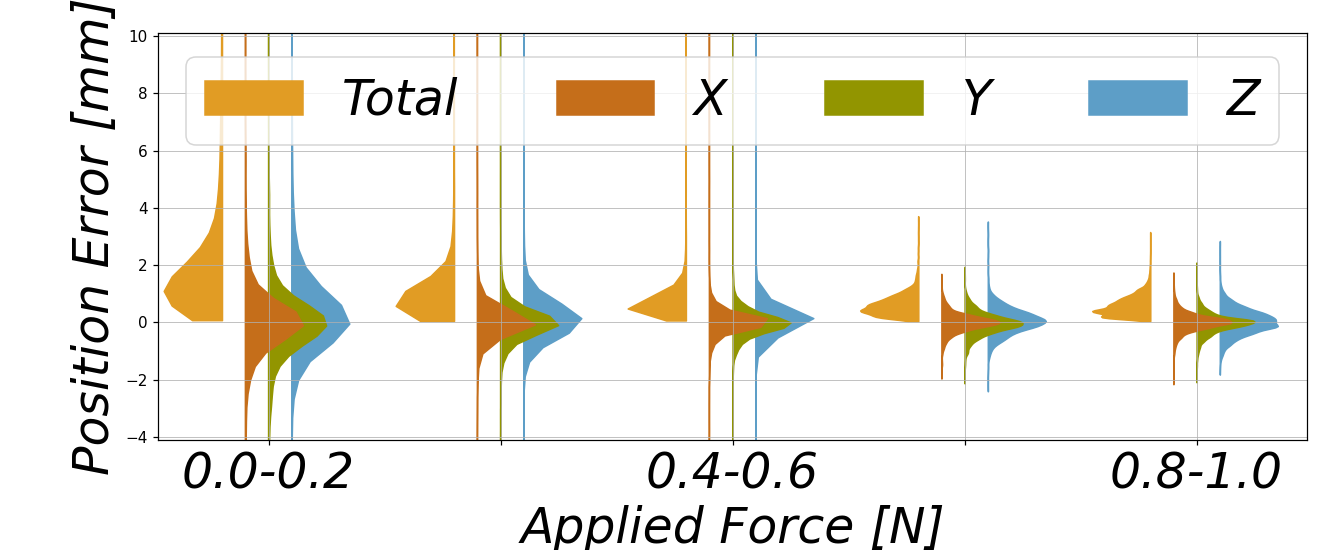

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


In [92]:
# p
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size(32)
force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.2))
index2 = np.where((force_am>=0.2) & (force_am<0.4))
index3 = np.where((force_am>=0.4) & (force_am<0.6))
index4 = np.where((force_am>=0.6) & (force_am<0.8))
index5 = np.where((force_am>=0.8))
data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4],error_px[index5]]
data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4],error_py[index5]]
data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4],error_pz[index5]]
data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4],error_pt[index5]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_pt,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_pz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
v3 = ax.violinplot(data_py,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_px,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','0.0-0.2','','0.4-0.6','','0.8-1.0','1.0-1.2','','1.4-1.6'],fontproperties=font)
# plt.yticks(np.arange(-4.0, 8.1, 4.0),fontproperties=font,rotation=90)
ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','X','Y','Z'],loc='upper center',prop=font, ncol=4)
ax.set_ylim(-4.1,10.1)
ax.grid(b=None,linewidth=0.5)
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.show()

# # plt.savefig("../../../../../../Manuscript/Figure/F4_Single_PositionError_CON.png")

In [93]:
np.median(error_pt)

0.6187212097880472

<IPython.core.display.Javascript object>


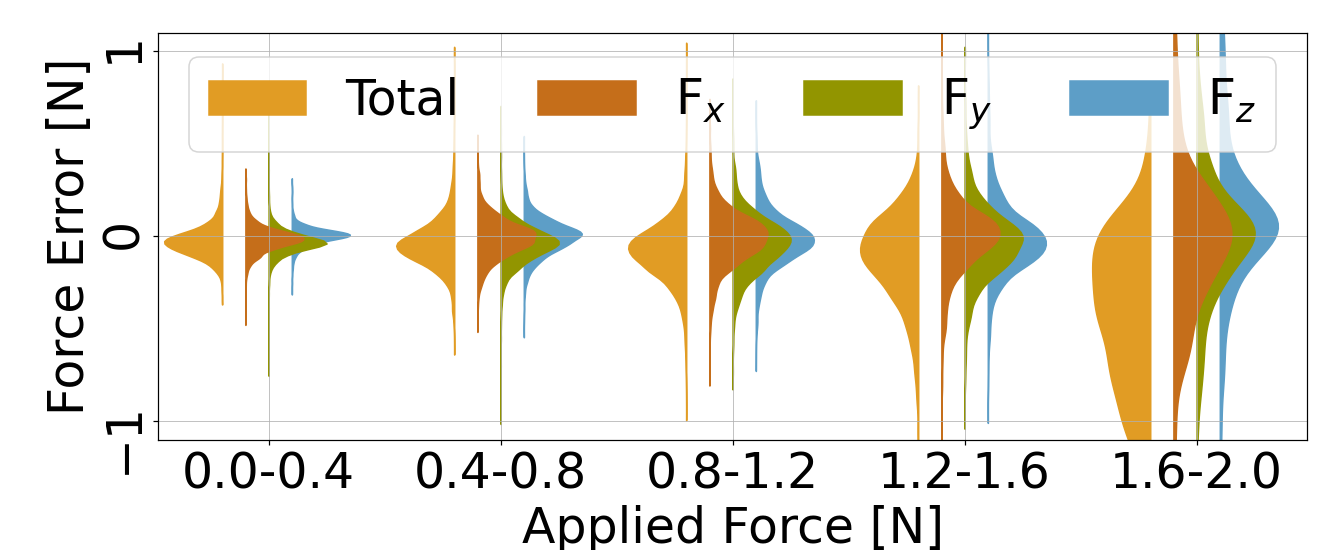

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


In [94]:
# Force Error
font = FontProperties()
font.set_family('arial')
# font.set_name('Times New Roman')
font.set_style('normal')
font.set_size(32)

force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
data_fx = [error_fx[index1],error_fx[index2],error_fx[index3],error_fx[index4],error_fx[index5]]
data_fy = [error_fy[index1],error_fy[index2],error_fy[index3],error_fy[index4],error_fy[index5]]
data_fz = [error_fz[index1],error_fz[index2],error_fz[index3],error_fz[index4],error_fz[index5]]
data_ft = [error_ft[index1],error_ft[index2],error_ft[index3],error_ft[index4],error_ft[index5]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_fz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
    
v3 = ax.violinplot(data_fy,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_fx,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','0.0-0.4','0.4-0.8','0.8-1.2','1.2-1.6','1.6-2.0'],fontsize=32,fontname='Arial')
plt.yticks(np.arange(-1.0, 1.1, 1.0),fontsize=32,fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Force Error [N]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','F$_{x}$','F$_{y}$','F$_z$'],loc='upper center',prop=font, ncol=4,columnspacing=1.6)
ax.set_ylim(-1.1,1.1)
ax.grid(b=None,linewidth=0.5)
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/Figure4_Rebuttal_ForceError_final.pdf",dpi=300,transparent=True)

<IPython.core.display.Javascript object>


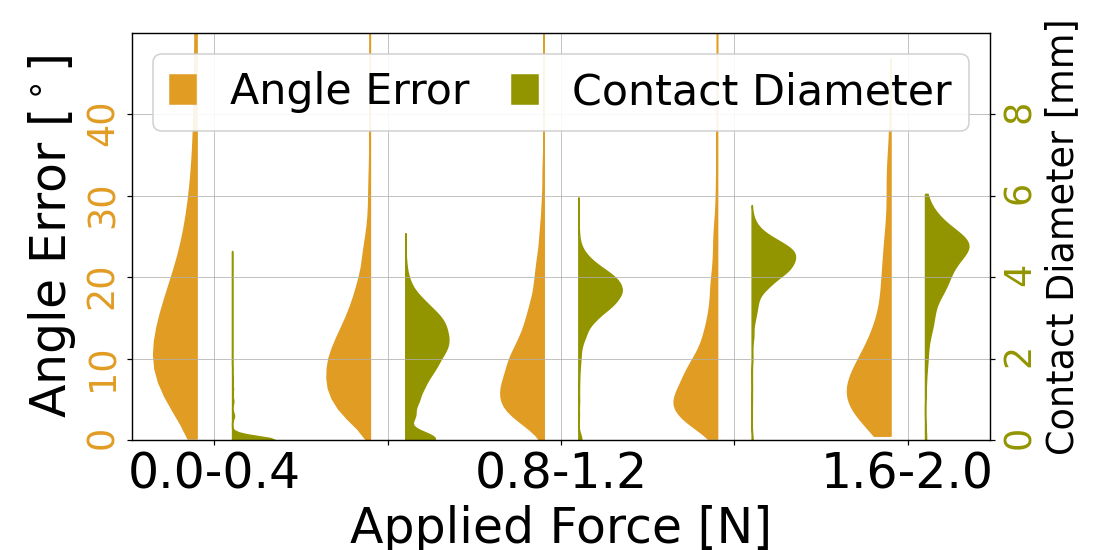

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


In [95]:
# Angle and Area
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(32)

force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
angle = np.asarray(angle)

data_ft = [angle[index1],angle[index2],angle[index3],angle[index4],angle[index5]]

disk = np.asarray(disk)*5
data_disk = [disk[index1],disk[index2],disk[index3],disk[index4],disk[index5]]

fig,ax = plt.subplots(figsize=(10,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.1
    b.set_color(colors__[1])
    b.set_alpha(1)

v2 = ax.violinplot(data_disk,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m,np.inf)+0.1
    b.set_color(colors__[7])
    b.set_alpha(1)

ax.set_xticklabels(['d','0.0-0.4',' ','0.8-1.2',' ','1.6-2.0'],fontsize=32,fontname='Arial')
plt.yticks(np.arange(0, 41, 10),fontsize=24,fontname='Arial',rotation=90,color=colors__[1])

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Angle Error [$^\circ$]",fontproperties=font)
ax.set_ylim(0,50)
ax.grid(b=None,linewidth=0.5)

ax2 = ax.twinx()  
ax2.set_xticklabels(['d','0.0-0.4','','0.8-1.2','','1.6-2.0'],fontsize=32,fontname='Arial')
plt.yticks(np.arange(0, 9, 2),fontsize=24,rotation=90,color=colors__[7])
ax2.set_xlabel("Applied Force [N]",fontproperties=font)
ax2.set_ylabel("Contact Diameter [mm]",fontsize=24)
ax2.set_ylim(0,10)

ax.legend([v1['bodies'][0],v2['bodies'][0]],['Angle Error','Contact Diameter'],fontsize=28,ncol=2,columnspacing=1,handlelength=0.6,framealpha=0.9,loc='upper center')
# ax.grid(b=None,linewidth=0.5)
plt.show()
plt.subplots_adjust(0.12,0.2,0.90,0.94)
plt.savefig("../../Figure/Figure4_Rebuttal_AngleArea_2_final.pdf",dpi=300,transparent=True)

### Suplimentary FigS7

In [ ]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180.0

px = []
py = []
pz = []
fx = []
fy = []
fz = []

angle = []

disk = []

test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
ground_truth_ = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
ID = test_index
for i in ID:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data2/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
    px += [np.mean(force[:,0])]
    py += [np.mean(force[:,1])]
    pz += [np.mean(force[:,2])]

    fx += [np.sum(prediction_[0,col_ind])]
    fy += [np.sum(prediction_[1,col_ind])]
    fz += [np.sum(prediction_[2,col_ind])]
    
    angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth_[i,24],ground_truth_[i,25],ground_truth_[i,26]])]
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
    if xx[0].shape[0] >0:
        disk += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
    else:
        disk += [0]

In [ ]:
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(15)
size=0.0005
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(np.linspace(-22,20,100),np.linspace(-22,20,100),c='gray',linewidth=3,linestyle='dashed')
plt.scatter(ground_truth[:,1],px,s=size,c=colors__[5])
plt.xlim(-22,20)
plt.ylim(-22,20)
plt.xticks(np.arange(-20, 20.1, 20),fontsize=15,fontstyle='normal')
plt.yticks(np.arange(-20, 20.1, 20),fontsize=15,fontstyle='normal',rotation=90)
plt.xlabel("Ground Truth-P(X) [mm]",fontproperties=font)
plt.ylabel("Prediction-P(X) [mm]",fontproperties=font)
plt.subplot(132)
plt.plot(np.linspace(-22,20,100),np.linspace(-22,20,100),c='gray',linewidth=3,linestyle='dashed')
plt.scatter(ground_truth[:,2],py,s=size,c=colors__[7])
plt.xlim(-22,20)
plt.ylim(-22,20)
plt.xticks(np.arange(-20, 20.1, 20),fontsize=15,fontstyle='normal')
plt.yticks(np.arange(-20, 20.1, 20),fontsize=15,fontstyle='normal',rotation=90)
plt.xlabel("Ground Truth-P(Y) [mm]",fontproperties=font)
plt.ylabel("Prediction-P(Y) [mm]",fontproperties=font)
plt.subplot(133)
plt.plot(np.linspace(8,70,100),np.linspace(8,70,100),c='gray',linewidth=3,linestyle='dashed')
plt.scatter(ground_truth[:,3],pz,s=size,c=colors__[6])
plt.xlim(8,68)
plt.ylim(8,68)
plt.xticks(np.arange(10, 68.1, 25),fontsize=15,fontstyle='normal')
plt.yticks(np.arange(10, 68.1, 25),fontsize=15,fontstyle='normal',rotation=90)
plt.xlabel("Ground Truth-P(Z) [mm]",fontproperties=font)
plt.ylabel("Prediction-P(Z) [mm]",fontproperties=font)
plt.subplots_adjust(0.05,0.15,0.99,0.95)
plt.show()
plt.savefig("../../Figure/FigureS7_Rebuttal_Position1_final.png",transparent=True)

In [ ]:
error_px = np.asarray((px-ground_truth[:,1]))
error_py = np.asarray((py-ground_truth[:,2]))
error_pz = np.asarray((pz-ground_truth[:,3]))
error_p = np.vstack((error_px,error_py,error_pz))
error_pt = np.asarray(np.linalg.norm(error_p,axis=0))

error_fx = np.asarray(fx-ground_truth[:,24])
error_fy = np.asarray(fy-ground_truth[:,25])
error_fz = np.asarray(fz-ground_truth[:,26])
# error_f = np.vstack((error_fx,error_fy,error_fz))
# error_ft = np.asarray(np.linalg.norm(error_f,axis=0))
error_f_ = np.vstack((fx,fy,fz))
error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
xxxx = np.where(np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0)
print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(abs(error_fx[xxxx])),np.median(abs(error_fy[xxxx])),np.median(abs(error_fz[xxxx])))
print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(abs(error_fx[xxxx])),np.mean(abs(error_fy[xxxx])),np.mean(abs(error_fz[xxxx])))

In [ ]:
# Position Error
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(20)

force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4],error_px[index5]]
data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4],error_py[index5]]
data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4],error_pz[index5]]
data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4],error_pt[index5]]
fig,ax = plt.subplots(figsize=(8,4))

v1 = ax.violinplot(data_pt,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_pz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
    
v3 = ax.violinplot(data_py,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_px,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','0.0-0.4','0.4-0.8','0.8-1.2','1.2-1.6','1.6-2.0'],fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(-4, 5, 4),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','F$_{x}$','F$_{y}$','F$_z$'],loc='upper center',prop=font, ncol=4,columnspacing=1)
ax.set_ylim(-4,5)
ax.grid(b=None)
plt.show()
plt.subplots_adjust(0.1,0.2,0.99,0.95)
plt.savefig("../../Figure/FigureS7_Rebuttal_Position2_final.png",transparent=True)

In [ ]:
count = 0
median_value = []
mean_value = []
count_value = []
for i in range(11):
    index = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)>=count) & (np.linalg.norm(ground_truth[:,24:27],axis=1)<count+0.2))
    median_value.append(np.median(np.linalg.norm(error_f_,axis=0)[index]))
    mean_value.append(np.mean(np.linalg.norm(error_f_,axis=0)[index]))
    count_value.append(count+0.1)
    count += 0.2

In [ ]:
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(25)
size = 0.01
fig = plt.figure(figsize=(6,5))
plt.scatter(np.linalg.norm(ground_truth[:,24:27],axis=1),np.linalg.norm(error_f_,axis=0),s=size)
plt.scatter(count_value,median_value, c='#fa8e04',s=200)
plt.plot(count_value,median_value, c='#fa8e04',linewidth=6,label='Median Curve')
# plt.plot(count_value,mean_value)
plt.xlim(-0.0,2.0)
plt.ylim(-0.0,2.0)
plt.xticks(np.arange(0, 2.01, 0.4),fontsize=25,fontstyle='normal')
plt.yticks(np.arange(0, 2.01, 0.4),fontsize=25,fontstyle='normal')
plt.legend(prop=font,handlelength=0.5,loc="upper center")
plt.xlabel("Ground Truth-Force [N]",fontproperties=font)
plt.ylabel("Prediction-Force [N]",fontproperties=font)


plt.subplots_adjust(0.22,0.2,0.90,0.95)
plt.show()
plt.savefig("../../Figure/FigureS7_Rebuttal_Force_final.png",transparent=True)

In [ ]:
angle_x_gt = []
angle_y_gt = []
angle_z_gt = []
angle_x_pd = []
angle_y_pd = []
angle_z_pd = []
for i in range(ground_truth.shape[0]):
    angle_x_gt.append(np.arctan2(ground_truth[i,26],ground_truth[i,25])/np.pi*180.0)
    angle_y_gt.append(np.arctan2(ground_truth[i,24],ground_truth[i,26])/np.pi*180.0)
    angle_z_gt.append(np.arctan2(ground_truth[i,25],ground_truth[i,24])/np.pi*180.0)

    angle_x_pd.append(np.arctan2(fz[i],fy[i])/np.pi*180.0)
    angle_y_pd.append(np.arctan2(fx[i],fz[i])/np.pi*180.0)
    angle_z_pd.append(np.arctan2(fy[i],fx[i])/np.pi*180.0)
angle_x_gt = np.asarray(angle_x_gt)
angle_y_gt = np.asarray(angle_y_gt)
angle_z_gt = np.asarray(angle_z_gt)
angle_x_pd = np.asarray(angle_x_pd)
angle_y_pd = np.asarray(angle_y_pd)
angle_z_pd = np.asarray(angle_z_pd)

In [ ]:
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(15)
size = 0.0005
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100)+360.0,color='gray',linewidth=3,linestyle='dashed')
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100),color='gray',linewidth=3,linestyle='dashed')
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100)-360.0,color='gray',linewidth=3,linestyle='dashed')
plt.scatter(angle_x_gt,angle_x_pd, s =size,color=colors__[5])
plt.scatter(angle_x_gt,angle_x_pd-360.0, s=size,color=colors__[5])
plt.scatter(angle_x_gt-360.0,angle_x_pd, s=size,color=colors__[5])
plt.scatter(angle_x_gt-360.0,angle_x_pd-360.0, s=size,color=colors__[5])
plt.xticks(np.arange(-180-360.0, 180.1, 240),["-540$^{\circ}$", "-300$^{\circ}$","-60$^{\circ}$","180$^{\circ}$"],fontsize=15,fontstyle='normal')
plt.yticks(np.arange(-180-360.0, 180.1, 240),["-540$^{\circ}$", "-300$^{\circ}$","-60$^{\circ}$","180$^{\circ}$"],fontsize=15,fontstyle='normal',rotation=90)
plt.xlabel("Ground Truth-Angle(${\curvearrowright}{X}$)",fontproperties=font)
plt.ylabel("Prediction-Angle(${\curvearrowright}{X}$)",fontproperties=font)
plt.xlim(-580,200)
plt.ylim(-580,200)

plt.subplot(132)
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100)+360.0,color='gray',linewidth=3,linestyle='dashed')
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100),color='gray',linewidth=3,linestyle='dashed')
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100)-360.0,color='gray',linewidth=3,linestyle='dashed')
plt.scatter(angle_y_gt,angle_y_pd, s=size,color=colors__[7])
plt.scatter(angle_y_gt,angle_y_pd-360.0, s=size,color=colors__[7])
plt.scatter(angle_y_gt-360.0,angle_y_pd, s=size,color=colors__[7])
plt.scatter(angle_y_gt-360.0,angle_y_pd-360.0, s=size,color=colors__[7])
plt.xticks(np.arange(-180-360.0, 180.1, 240),["-540$^{\circ}$", "-300$^{\circ}$","-60$^{\circ}$","180$^{\circ}$"],fontsize=15,fontstyle='normal')
plt.yticks(np.arange(-180-360.0, 180.1, 240),["-540$^{\circ}$", "-300$^{\circ}$","-60$^{\circ}$","180$^{\circ}$"],fontsize=15,fontstyle='normal',rotation=90)
plt.xlabel("Ground Truth-Angle(${\curvearrowright}{Y}$)",fontproperties=font)
plt.ylabel("Prediction-Angle(${\curvearrowright}{Y}$)",fontproperties=font)
plt.xlim(-580,200)
plt.ylim(-580,200)

plt.subplot(133)
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100)+360.0,color='gray',linewidth=3,linestyle='dashed')
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100),color='gray',linewidth=3,linestyle='dashed')
plt.plot(np.linspace(-580,200,100),np.linspace(-580,200,100)-360.0,color='gray',linewidth=3,linestyle='dashed')
plt.scatter(angle_z_gt,angle_z_pd, s=size,color=colors__[6])
plt.scatter(angle_z_gt,angle_z_pd-360.0, s=size,color=colors__[6])
plt.scatter(angle_z_gt-360.0,angle_z_pd, s=size,color=colors__[6])
plt.scatter(angle_z_gt-360.0,angle_z_pd-360.0, s=size,color=colors__[6])
plt.xticks(np.arange(-180-360.0, 180.1, 240),["-540$^{\circ}$", "-300$^{\circ}$","-60$^{\circ}$","180$^{\circ}$"],fontsize=15,fontstyle='normal')
plt.yticks(np.arange(-180-360.0, 180.1, 240),["-540$^{\circ}$", "-300$^{\circ}$","-60$^{\circ}$","180$^{\circ}$"],fontsize=15,fontstyle='normal',rotation=90)
plt.xlabel("Ground Truth-Angle(${\curvearrowright}{Z}$)",fontproperties=font)
plt.ylabel("Prediction-Angle(${\curvearrowright}{Z}$)",fontproperties=font)
plt.xlim(-580,200)
plt.ylim(-580,200)

plt.subplots_adjust(0.05,0.15,0.98,0.95)
plt.show()
plt.savefig("../../Figure/FigureS7_Rebuttal_Angle_final.png",transparent=True)

### Validation on bigger indenter

#### Figure

In [4]:
ground_truth1 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_validation1.npy")
# ground_truth1 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_validation2.npy")
# ground_truth1 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_validation3.npy")
map_index = 2

In [9]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180.0

In [ ]:
# px = []
# py = []
# pz = []
# fx = []
# fy = []
# fz = []

# angle = []

# disk = []
# col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
# indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
# for i in range(ground_truth1.shape[0]):
#     prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Predicted_Map"+str(map_index)+"_"+str(i)+".npy")
#     prediction_ = np.zeros((3,4096))
#     prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
#     prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
#     prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
#     force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
#     px += [np.mean(force[:,0])]
#     py += [np.mean(force[:,1])]
#     pz += [np.mean(force[:,2])]

#     fx += [np.sum(prediction_[0,col_ind])]
#     fy += [np.sum(prediction_[1,col_ind])]
#     fz += [np.sum(prediction_[2,col_ind])]
    
#     angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth1[i,24],ground_truth1[i,25],ground_truth1[i,26]])]
    
#     xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.01)
#     if xx[0].shape[0] >0:
#         disk_max = np.max(indentation_info[xx][:,1:4],axis=0)
#         disk_min = np.min(indentation_info[xx][:,1:4],axis=0)
#         disk += [np.linalg.norm(disk_max-disk_min)]
#     else:
#         disk += [0]

In [10]:
px = []
py = []
pz = []
fx = []
fy = []
fz = []

angle = []

disk = []
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
for i in range(ground_truth1.shape[0]):
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Predicted_Map"+str(map_index)+"_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    position = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
    
    px += [np.mean(reject_outliers(position[:,0]))]
    py += [np.mean(reject_outliers(position[:,1]))]
    pz += [np.mean(reject_outliers(position[:,2]))]
#     xx = np.argwhere(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.002)
    fx += [np.sum(prediction_[0,col_ind])]
    fy += [np.sum(prediction_[1,col_ind])]
    fz += [np.sum(prediction_[2,col_ind])]
    
    angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth1[i,24],ground_truth1[i,25],ground_truth1[i,26]])]
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.002)
    if xx[0].shape[0] >0:
        disk += [np.sqrt(xx[0].shape[0]/np.pi)*2-1]
    else:
        disk += [0]

In [11]:
error_px = np.asarray((px-ground_truth1[:,1]))
error_py = np.asarray((py-ground_truth1[:,2]))
error_pz = np.asarray((pz-ground_truth1[:,3]))
error_p = np.vstack((error_px,error_py,error_pz))
error_pt = np.asarray(np.linalg.norm(error_p,axis=0))

error_fx = np.asarray(fx-ground_truth1[:,24])
error_fy = np.asarray(fy-ground_truth1[:,25])
error_fz = np.asarray(fz-ground_truth1[:,26])
error_f_ = np.vstack((fx,fy,fz))
error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth1[:,24:27],axis=1)))

In [12]:
xxxx = np.where(np.linalg.norm(ground_truth1[:,24:27],axis=1)<=2.0)
print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(np.asarray(disk)[xxxx]))
print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(np.asarray(disk)[xxxx]))

1.046416869295138 0.23443091651728742 16.1868658044732 6.978845608028654
2.817567394823354 0.3439755946002904 21.040032922929534 6.864113033866681


In [ ]:
#Applied Force
force_am = np.linalg.norm(ground_truth1[:,18:21],axis=1)
fig = plt.figure(figsize=(9,3))
plt.hist(force_am,bins=[0,0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2],color="lightgray")
plt.title("Applied Force Magnitude Histogram",fontsize=20)
plt.xticks(np.arange(0,3.3,0.8),fontsize=20,fontstyle='normal')
plt.yticks(np.arange(0,6001,2000),['0','2k','4k','6k'],fontsize=20,fontstyle='normal',rotation=90)
plt.xlabel("Applied Force [N]",fontsize=20, fontstyle='normal')
plt.subplots_adjust(0.12,0.23,0.99,0.90)
plt.savefig("../../Figure/FigureSnew_Rebuttal_AppliedForceHistogram_final.png",transparent=True)

<IPython.core.display.Javascript object>


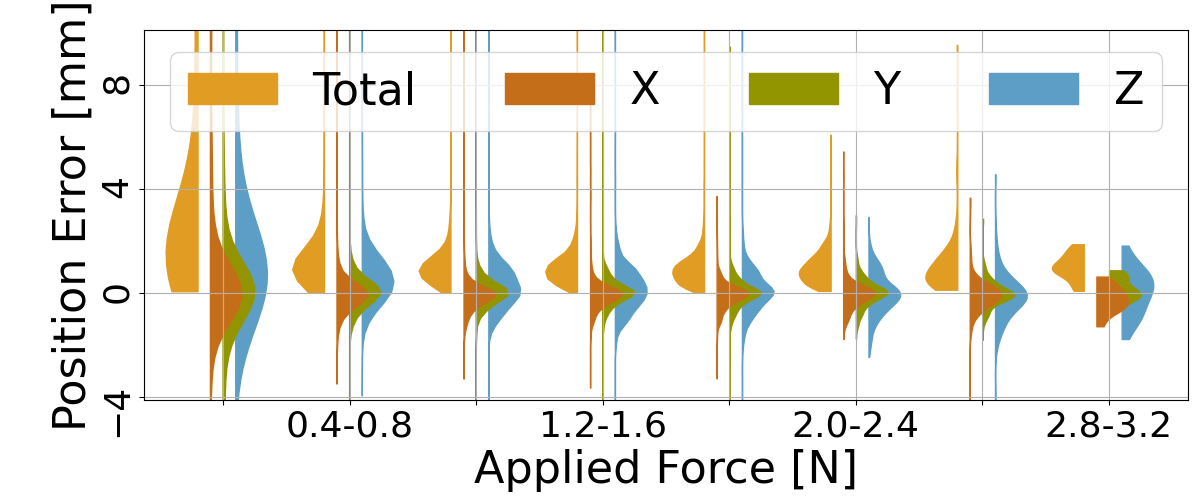

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [13]:
# p
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(32)
force_am = np.linalg.norm(ground_truth1[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
index6 = np.where((force_am>=2.0) & (force_am<2.4))
index7 = np.where((force_am>=2.4) & (force_am<2.8))
index8 = np.where((force_am>=2.8) & (force_am<3.2))
# index9 = np.where((force_am>=3.2) & (force_am<3.6))
# index10 = np.where((force_am>=3.6) & (force_am<4.0))
# index11 = np.where((force_am>=4.0) & (force_am<4.4))
# index12 = np.where((force_am>=4.4))

data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4],error_px[index5],error_px[index6],error_px[index7],error_px[index8]]
data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4],error_py[index5],error_py[index6],error_py[index7],error_py[index8]]
data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4],error_pz[index5],error_pz[index6],error_pz[index7],error_pz[index8]]
data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4],error_pt[index5],error_pt[index6],error_pt[index7],error_pt[index8]]

# data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4],error_px[index5],error_px[index6],error_px[index7],error_px[index8],error_px[index9],error_px[index10],error_px[index11],error_px[index12]]
# data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4],error_py[index5],error_py[index6],error_py[index7],error_py[index8],error_py[index9],error_py[index10],error_py[index11],error_py[index12]]
# data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4],error_pz[index5],error_pz[index6],error_pz[index7],error_pz[index8],error_pz[index9],error_pz[index10],error_pz[index11],error_pz[index12]]
# data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4],error_pt[index5],error_pt[index6],error_pt[index7],error_pt[index8],error_pt[index9],error_pt[index10],error_pt[index11],error_pt[index12]]

fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_pt,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_pz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
v3 = ax.violinplot(data_py,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_px,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','','0.4-0.8','','1.2-1.6','','2.0-2.4','','2.8-3.2'],fontsize=26)
plt.yticks(np.arange(-4.0, 8.1, 4.0),fontsize=26,rotation=90)
ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','X','Y','Z'],loc='upper center',prop=font, ncol=4)
ax.set_ylim(-4.1,10.1)
ax.grid()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.show()

plt.savefig("../../Figure/FigureSnew_Rebuttal_Position_final.png",transparent=True)

<IPython.core.display.Javascript object>


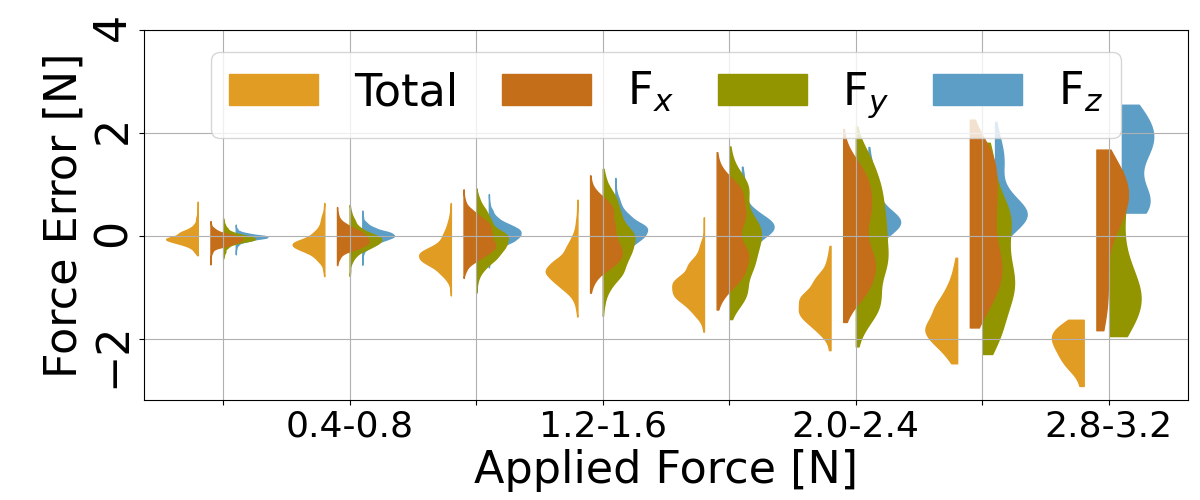

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


In [14]:
# F
# font = FontProperties()
# font.set_family('serif')
# font.set_name('Times New Roman')
# font.set_style('italic')
# font.set_size(32)

force_am = np.linalg.norm(ground_truth1[:,18:21],axis=1)
# index1 = np.where((force_am>=0.0) & (force_am<0.2))
# index2 = np.where((force_am>=0.2) & (force_am<0.4))
# index3 = np.where((force_am>=0.4) & (force_am<0.6))
# index4 = np.where((force_am>=0.6) & (force_am<0.8))
# index5 = np.where((force_am>=0.8) & (force_am<1.0))
# index6 = np.where((force_am>=1.0) & (force_am<1.2))
# index7 = np.where((force_am>=1.2) & (force_am<1.4))
# index8 = np.where((force_am>=1.4) & (force_am<1.6))
# index9 = np.where((force_am>=1.6) & (force_am<1.8))
# index10 = np.where((force_am>=1.8) & (force_am<2.0))
# index11 = np.where((force_am>=2.0) & (force_am<2.2))
# index12 = np.where((force_am>=2.2))
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
index6 = np.where((force_am>=2.0) & (force_am<2.4))
index7 = np.where((force_am>=2.4) & (force_am<2.8))
index8 = np.where((force_am>=2.8) )
# index9 = np.where((force_am>=3.2) & (force_am<3.6))
# index10 = np.where((force_am>=3.6) & (force_am<4.0))
# index11 = np.where((force_am>=4.0) & (force_am<4.4))
# index12 = np.where((force_am>=4.4))

data_fx = [error_fx[index1],error_fx[index2],error_fx[index3],error_fx[index4],error_fx[index5],error_fx[index6],error_fx[index7],error_fx[index8]]
data_fy = [error_fy[index1],error_fy[index2],error_fy[index3],error_fy[index4],error_fy[index5],error_fy[index6],error_fy[index7],error_fy[index8]]
data_fz = [error_fz[index1],error_fz[index2],error_fz[index3],error_fz[index4],error_fz[index5],error_fz[index6],error_fz[index7],error_fz[index8]]
data_ft = [error_ft[index1],error_ft[index2],error_ft[index3],error_ft[index4],error_ft[index5],error_ft[index6],error_ft[index7],error_ft[index8]]


# data_fx = [error_fx[index1],error_fx[index2],error_fx[index3],error_fx[index4],error_fx[index5],error_fx[index6],error_fx[index7],error_fx[index8],error_fx[index9],error_fx[index10],error_fx[index11],error_fx[index12]]
# data_fy = [error_fy[index1],error_fy[index2],error_fy[index3],error_fy[index4],error_fy[index5],error_fy[index6],error_fy[index7],error_fy[index8],error_fy[index9],error_fy[index10],error_fy[index11],error_fy[index12]]
# data_fz = [error_fz[index1],error_fz[index2],error_fz[index3],error_fz[index4],error_fz[index5],error_fz[index6],error_fz[index7],error_fz[index8],error_fz[index9],error_fz[index10],error_fz[index11],error_fz[index12]]
# data_ft = [error_ft[index1],error_ft[index2],error_ft[index3],error_ft[index4],error_ft[index5],error_ft[index6],error_ft[index7],error_ft[index8],error_ft[index9],error_ft[index10],error_ft[index11],error_ft[index12]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_fz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[6])
    b.set_alpha(1)
    
    
v3 = ax.violinplot(data_fy,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[7])
    b.set_alpha(1)
    
v2 = ax.violinplot(data_fx,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.1
    b.set_color(colors__[5])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','','0.4-0.8','','1.2-1.6','','2.0-2.4','','2.8-3.2'],fontsize=26)
plt.yticks(np.arange(-2, 4.1, 2),fontsize=32,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Force Error [N]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','F$_{x}$','F$_{y}$','F$_z$'],loc='upper center',prop=font, ncol=4,columnspacing=1)
# ax.set_ylim(-0.3,1.3)
ax.grid(b=None)
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/FigureSnew_Rebuttal_Force_final.png",transparent=True)

In [15]:
count = 0
median_value = []
mean_value = []
count_value = []
for i in range(11):
    index = np.where((np.linalg.norm(ground_truth1[:,24:27],axis=1)>=count) & (np.linalg.norm(ground_truth1[:,24:27],axis=1)<count+0.4))
    median_value.append(np.median(np.linalg.norm(error_f_,axis=0)[index]))
    mean_value.append(np.mean(np.linalg.norm(error_f_,axis=0)[index]))
    count_value.append(count+0.2)
    count += 0.4

/is/sg/shuanbo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/is/sg/shuanbo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


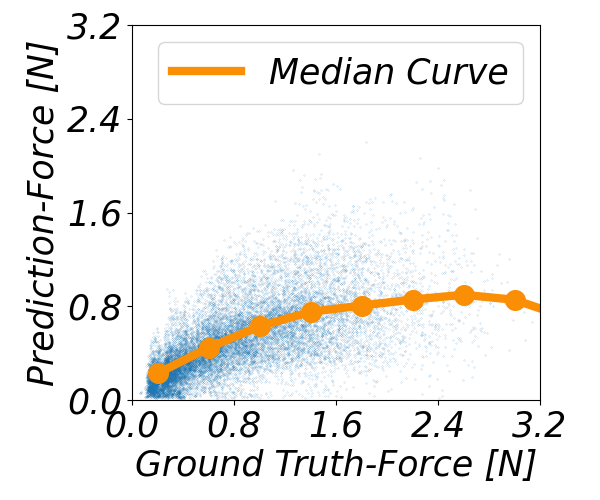

In [16]:
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size(25)
size = 0.01
fig = plt.figure(figsize=(6,5))
plt.scatter(np.linalg.norm(ground_truth1[:,24:27],axis=1),np.linalg.norm(error_f_,axis=0),s=size)
plt.scatter(count_value,mean_value, c='#fa8e04',s=200)
plt.plot(count_value,mean_value, c='#fa8e04',linewidth=6,label='Median Curve')
# plt.plot(count_value,mean_value)
plt.xticks(np.arange(0, 4.01, 0.8),fontsize=25,fontstyle='italic')
plt.yticks(np.arange(0, 4.01, 0.8),fontsize=25,fontstyle='italic')
plt.xlim(-0.0,3.2)
plt.ylim(-0.0,3.2)
plt.legend(prop=font)
plt.xlabel("Ground Truth-Force [N]",fontproperties=font)
plt.ylabel("Prediction-Force [N]",fontproperties=font)


plt.subplots_adjust(0.22,0.2,0.90,0.95)
plt.show()
# plt.savefig("../../Figure/FigureS7_Rebuttal_Force.png",transparent=True)

<IPython.core.display.Javascript object>


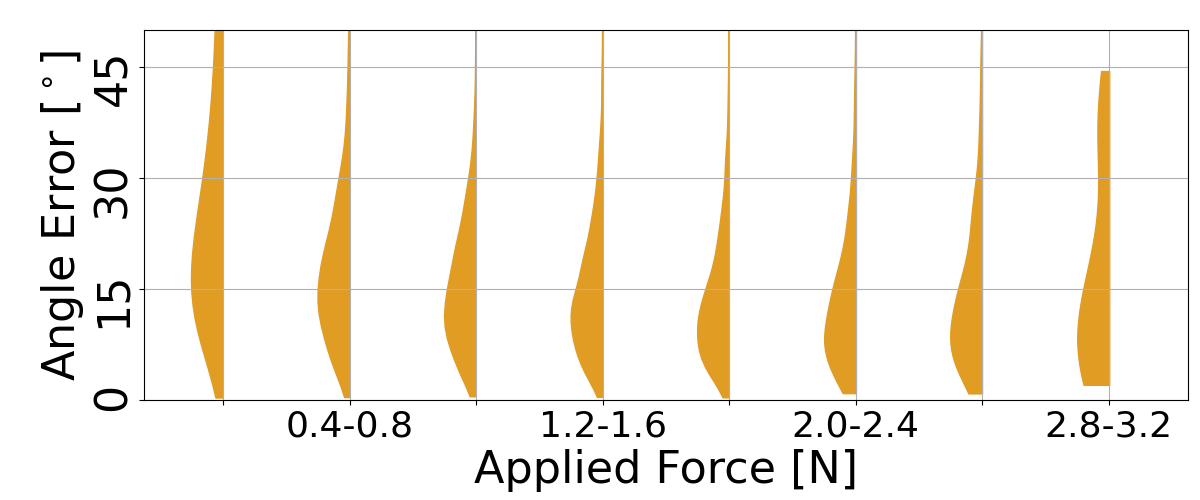

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


In [21]:
# angle
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(32)

force_am = np.linalg.norm(ground_truth1[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
index6 = np.where((force_am>=2.0) & (force_am<2.4))
index7 = np.where((force_am>=2.4) & (force_am<2.8))
index8 = np.where((force_am>=2.8) & (force_am<3.2))
index9 = np.where((force_am>=3.2) & (force_am<3.6))
# index10 = np.where((force_am>=3.6) & (force_am<4.0))
# index11 = np.where((force_am>=4.0) & (force_am<4.4))
# index12 = np.where((force_am>=4.4))

angle = np.asarray(angle)

data_ft = [angle[index1],angle[index2],angle[index3],angle[index4],angle[index5],angle[index6],angle[index7],angle[index8]]
# data_ft = [angle[index1],angle[index2],angle[index3],angle[index4],angle[index5],angle[index6],angle[index7],angle[index8],angle[index9],angle[index10],angle[index11],angle[index12]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color(colors__[1])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','','0.4-0.8','','1.2-1.6','','2.0-2.4','','2.8-3.2'],fontsize=26)
plt.yticks(np.arange(0, 50, 15),fontsize=32,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Angle Error [$^\circ$]",fontproperties=font)
# ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','$F_{s1}$','$F_{s2}$','$F_n$'],loc='upper center',prop=font, ncol=4,columnspacing=1)
ax.set_ylim(0,50)
ax.grid(b=None)
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/FigureSnew_Rebuttal_Angle_final.png",transparent=True)

<IPython.core.display.Javascript object>


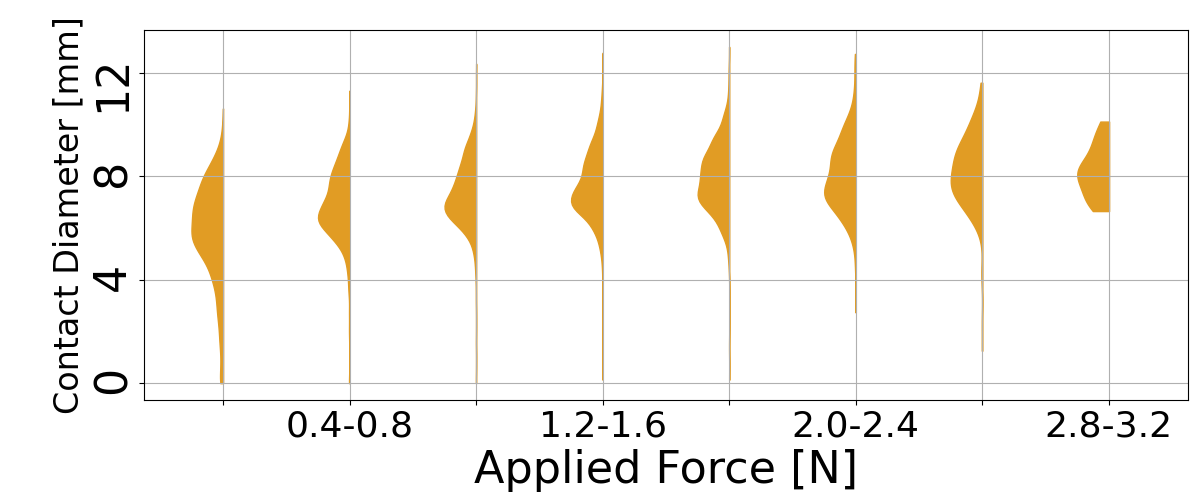

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [25]:
## disk
# font = FontProperties()
# font.set_family('serif')
# font.set_name('Times New Roman')
# font.set_style('italic')
# font.set_size(32)

force_am = np.linalg.norm(ground_truth1[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))
index6 = np.where((force_am>=2.0) & (force_am<2.4))
index7 = np.where((force_am>=2.4) & (force_am<2.8))
index8 = np.where((force_am>=2.8) & (force_am<3.2))
index9 = np.where((force_am>=3.2) & (force_am<3.6))
# index10 = np.where((force_am>=3.6) & (force_am<4.0))
# index11 = np.where((force_am>=4.0) & (force_am<4.4))
# index12 = np.where((force_am>=4.4))

angle = np.asarray(disk)
data_ft = [angle[index1],angle[index2],angle[index3],angle[index4],angle[index5],angle[index6],angle[index7],angle[index8]]
# data_ft = [angle[index1],angle[index2],angle[index3],angle[index4],angle[index5],angle[index6],angle[index7],angle[index8],angle[index9],angle[index10],angle[index11],angle[index12]]
fig,ax = plt.subplots(figsize=(12,5))

v1 = ax.violinplot(data_ft,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color(colors__[1])
    b.set_alpha(1)
    

ax.set_xticklabels(['d','','0.4-0.8','','1.2-1.6','','2.0-2.4','','2.8-3.2'],fontsize=26)
plt.yticks(np.arange(0, 12.1, 4),fontsize=32,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Contact Diameter [mm]",fontproperties=font,fontsize=24)
# ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Total','$F_{s1}$','$F_{s2}$','$F_n$'],loc='upper center',prop=font, ncol=4,columnspacing=1)
# ax.set_ylim(0,30)
ax.grid(b=None)
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/FigureSnew_Rebuttal_Area_final.png",transparent=True)

#### Video

In [ ]:
grey_skel = (0.8,0.8,0.8)
grey_surf = (0.6,0.6,0.6,0.5)
arrowscale=0.5
fs = 28
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size(fs)
def force_vector(fig, force,threashold):    
    filter_points = np.intersect1d(np.where(np.linalg.norm(force,axis=0)>threashold),np.where(indentation_info[:,3]>20))
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(skeleton_surface[:,1],skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax4.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax4.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],indentation_info[filter_points,3],force[0,filter_points]*400.0,force[1,filter_points]*400.0,force[2,filter_points]*400.0,color=colors[3])
#     ax4.set_xlabel('X',fontproperties=font)
#     ax4.set_ylabel('Y',fontproperties=font)
#     ax4.set_zlabel('Z',fontproperties=font)
#     plt.xticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
#     plt.yticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
    ax4.set_box_aspect([1,1,1])
    plt.xlim([-35,35]) 
    plt.ylim([-35,35])
    # z is 0-70
#     ax4.set_zticks(np.arange(-0, 60.1, 60))
    ax4.zaxis.set_tick_params(labelsize=20)
    ax4.view_init(35,-105)
    plt.grid("off")
    plt.axis("off")

    ax3 = fig.add_subplot(223)
    ax3.scatter(skeleton_surface[:,1],skeleton_surface[:,2],s=1,color=grey_skel,alpha=0.2)
    ax3.scatter(indentation_info[:,1],indentation_info[:,2],s=1,color=grey_surf)
    ax3.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],force[0,filter_points],force[1,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax3.set_xlabel('X [mm]',fontproperties=font)
    ax3.set_ylabel('Y [mm]',fontproperties=font)
    plt.axis('equal')
    plt.xlim([-35,35])
    plt.ylim([-35,35])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax2 = fig.add_subplot(222)
    ax2.scatter(skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax2.scatter(indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax2.quiver(indentation_info[filter_points,2],indentation_info[filter_points,3],-force[1,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax2.set_xlabel('Y [mm]',fontproperties=font)
    ax2.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([35,-35])
    plt.ylim([0,70])
    plt.xticks(np.arange(20, -20.1, -20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax1 = fig.add_subplot(221)
    ax1.scatter(skeleton_surface[:,1],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax1.scatter(indentation_info[:,1],indentation_info[:,3],s=1,color=grey_surf)
    ax1.quiver(indentation_info[filter_points,1],indentation_info[filter_points,3],force[0,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax1.set_xlabel('X [mm]',fontproperties=font)
    ax1.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([-35,35])
    plt.ylim([0,70])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")
    ax4.dist=5.8

    
    plt.subplots_adjust(0.08,0.08,0.99,0.99)
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(1232,1232))
    return img

fig =plt.figure(figsize=(12,12))
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
skeleton_surface = np.loadtxt("../Data/Information/SkeletonSurfaceNode.txt",skiprows=1)*1000.0
for i in range(800,18000,1):
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0]).flatten()
    prediction_[1] = np.flipud(prediction[1]).flatten()
    prediction_[2] = np.flipud(prediction[2]).flatten()
    force = prediction_[:,col_ind]
    image_2 = force_vector(fig,force,0.005)
    cv2.imwrite("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Vector_validation1_"+str(i)+".png",image_2)
    print(i)
    plt.clf()

#### FigS8

<IPython.core.display.Javascript object>


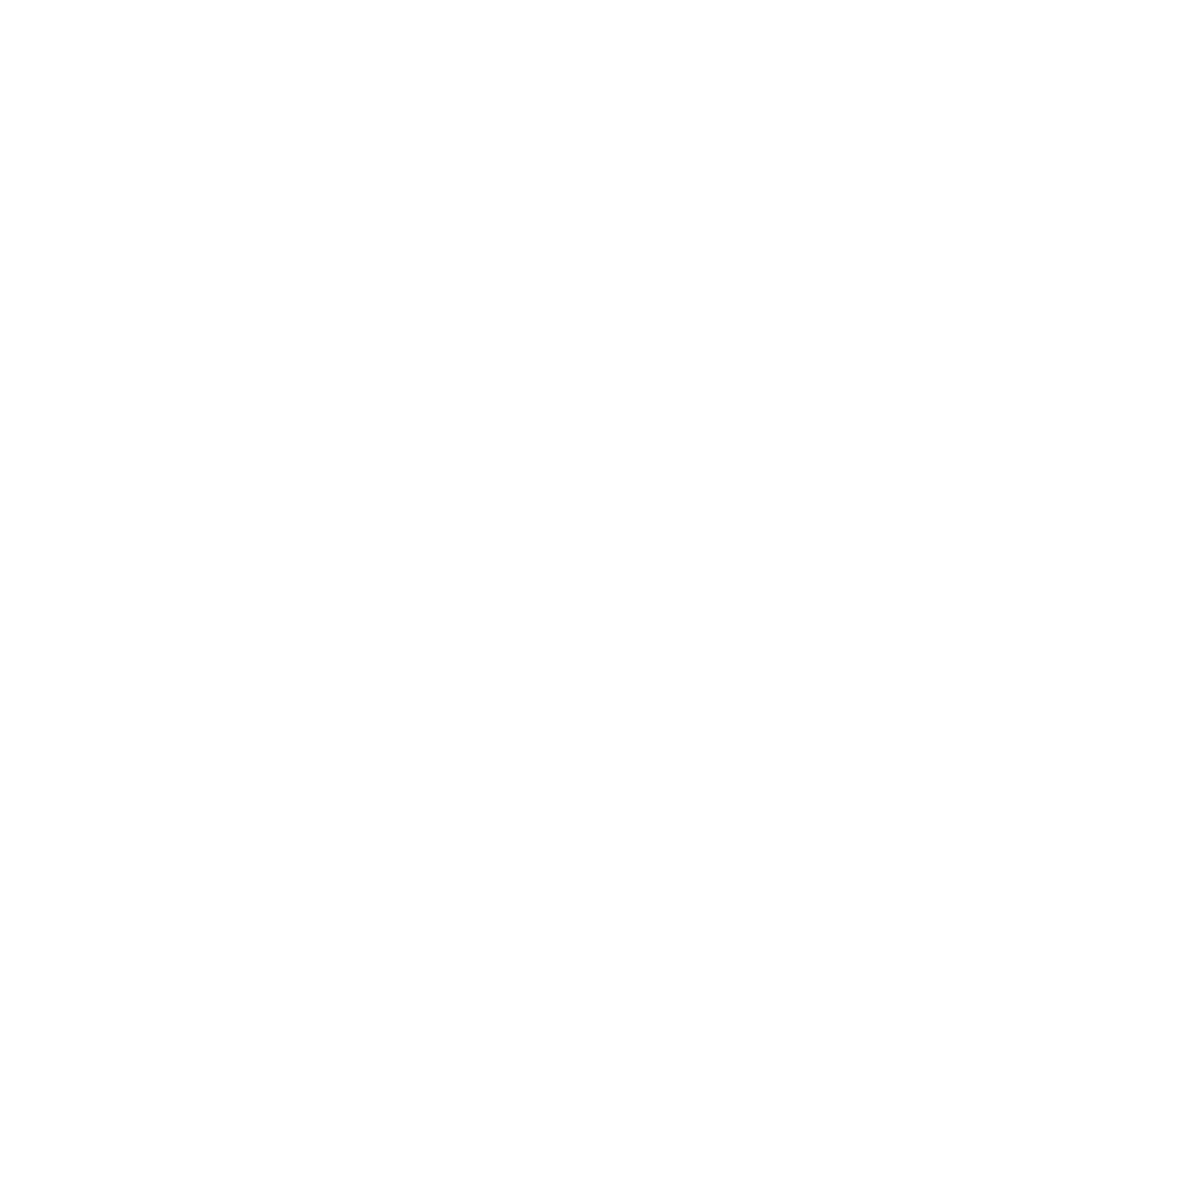

226
2234
2837
7161
6434
6189
6179
5895
5879
3951


In [28]:
grey_skel = (0.2,0.2,0.2)
grey_surf = (0.6,0.6,0.6,0.5)
arrowscale=0.25 # 0.5
fs = 28
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(fs)
def force_vector(fig, force,threashold):    
    filter_points = np.intersect1d(np.where(np.linalg.norm(force,axis=0)>threashold),np.where(indentation_info[:,3]>20))
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(skeleton_surface[:,1],skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax4.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax4.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],indentation_info[filter_points,3],force[0,filter_points]*200.0,force[1,filter_points]*200.0,force[2,filter_points]*200.0,color=colors__[3],arrow_length_ratio=0)
#     ax4.set_xlabel('X',fontproperties=font)
#     ax4.set_ylabel('Y',fontproperties=font)
#     ax4.set_zlabel('Z',fontproperties=font)
#     plt.xticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
#     plt.yticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
    ax4.set_box_aspect([1,1,1])
    plt.xlim([-35,35]) 
    plt.ylim([-35,35])
    # z is 0-70
#     ax4.set_zticks(np.arange(-0, 60.1, 60))
    ax4.zaxis.set_tick_params(labelsize=20)
    ax4.view_init(35,-105)
    plt.grid("off")
    plt.axis("off")

    ax3 = fig.add_subplot(223)
    ax3.scatter(skeleton_surface[:,1],skeleton_surface[:,2],s=1,color=grey_skel,alpha=0.2)
    ax3.scatter(indentation_info[:,1],indentation_info[:,2],s=1,color=grey_surf)
    ax3.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],force[0,filter_points],force[1,filter_points],color=colors__[3],scale=arrowscale, width=0.005)
    ax3.set_xlabel('X [mm]',fontproperties=font)
    ax3.set_ylabel('Y [mm]',fontproperties=font),
    plt.axis('equal')
    #plt.xlim([-35,35])
    #plt.ylim([-35,35])
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.xticks(np.arange(-15, 15.1, 15),fontsize=fs,fontstyle='normal',fontname='Arial')
    plt.yticks(np.arange(-15, 15.1, 15),fontsize=fs,fontstyle='normal',fontname='Arial',rotation=90)
    plt.grid("off")

    ax2 = fig.add_subplot(222)
    ax2.scatter(skeleton_surface[:,2],skeleton_surface[:,3],s=2,color=grey_skel,alpha=0.2)
    ax2.scatter(indentation_info[:,2],indentation_info[:,3],s=2,color=grey_surf)
    ax2.quiver(indentation_info[filter_points,2],indentation_info[filter_points,3],-force[1,filter_points],force[2,filter_points],color=colors__[3],scale=arrowscale, width=0.005)
    ax2.set_xlabel('Y [mm]',fontproperties=font)
    ax2.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    #plt.xlim([35,-35])
    #plt.ylim([0,70])
    plt.xlim([20,-20])
    plt.ylim([30,70])
    plt.xticks(np.arange(15, -15.1, -15),fontsize=fs,fontstyle='normal',fontname='Arial')
    plt.yticks(np.arange(45, 60.1, 15),fontsize=fs,fontstyle='normal',fontname='Arial',rotation=90)
    plt.grid("off")

    ax1 = fig.add_subplot(221)
    ax1.scatter(skeleton_surface[:,1],skeleton_surface[:,3],s=2,color=grey_skel,alpha=0.2)
    ax1.scatter(indentation_info[:,1],indentation_info[:,3],s=2,color=grey_surf)
    ax1.quiver(indentation_info[filter_points,1],indentation_info[filter_points,3],force[0,filter_points],force[2,filter_points],color=colors__[3],scale=arrowscale, width=0.005)
    ax1.set_xlabel('X [mm]',fontproperties=font)
    ax1.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([-20,20])
    plt.ylim([30,70])
    plt.xticks(np.arange(-15, 15.1, 15),fontsize=fs,fontstyle='normal',fontname='Arial')
    plt.yticks(np.arange(45, 60.1, 15),fontsize=fs,fontstyle='normal',fontname='Arial',rotation=90)
    plt.grid("off")
    ax4.dist=5.8

    
    plt.subplots_adjust(0.08,0.08,0.99,0.99)
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(1232,1232))
    return img

fig =plt.figure(figsize=(12,12))
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
skeleton_surface = np.loadtxt("../Data/Information/SkeletonSurfaceNode.txt",skiprows=1)*1000.0
for i in [226,2234,2837,7161,6434,6189,6179,5895,5879,3951]:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0]).flatten()
    prediction_[1] = np.flipud(prediction[1]).flatten()
    prediction_[2] = np.flipud(prediction[2]).flatten()
    force = prediction_[:,col_ind]
    image_2 = force_vector(fig,force,0.005)
    cv2.imwrite("/mnt/local/Insight_Rebuttal/Figure/FigS8_C_"+str(i)+"_final.png",image_2)
    print(i)
    plt.clf()

In [29]:
for i in [226,2234,2837,7161,6434,6189,6179,5895,5879,3951]:
    output = cv2.imread("/mnt/local/Insight_Rebuttal/Figure/FigS8_C_"+str(i)+"_final.png")
    output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
    cv2.imwrite("/mnt/local/Insight_Rebuttal/Figure/FigS8_C_"+str(i)+"_final.png",output)

In [ ]:
for i in [37,38,41,44,45,120,121,122,126,131,215,216,218,221,226,273,279,294,1473,1480,1723,1937,2220,2224,2227,2234,2471,2494,2501,2731,2742,2834,2837,2994,4282,4283,4356,4363,5879,5910,6412,6592,7644,7005,7101,7161]:
    output = cv2.imread("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Vector_validation1_"+str(i)+".png")
    output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
    cv2.imwrite("/mnt/local/Insight_Rebuttal/Figure/Asymmetry/Vector_validation1_"+str(i)+".png",output)

In [ ]:
img_array = []
for i in range(16918):
    output = cv2.imread("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Vector_validation1_"+str(i)+".png")
    output = cv2.resize(output, (616,616))
    output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
    cv2.imshow("Force Map Prediction", output)
    cv2.waitKey(1)
    img_array.append(output)

In [ ]:
out = cv2.VideoWriter("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/vector_validation1.mp4",cv2.VideoWriter_fourcc(*'MP4V'), 8, (616,616))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
cv2.destroyAllWindows()

In [ ]:
grey_skel = (0.8,0.8,0.8)
grey_surf = (0.6,0.6,0.6,0.5)
arrowscale=1
fs = 28
def force_vector(fig, force,threashold):
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    font.set_style('italic')
    font.set_size(fs)
    
    filter_points = np.intersect1d(np.where(np.linalg.norm(force,axis=0)>threashold),np.where(indentation_info[:,3]>20))
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(skeleton_surface[:,1],skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax4.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax4.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],indentation_info[filter_points,3],force[0,filter_points]*400.0,force[1,filter_points]*400.0,force[2,filter_points]*400.0,color=colors[3])
#     ax4.set_xlabel('X',fontproperties=font)
#     ax4.set_ylabel('Y',fontproperties=font)
#     ax4.set_zlabel('Z',fontproperties=font)
#     plt.xticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
#     plt.yticks(np.arange(-20, 20.1, 40),fontsize=20,fontstyle='italic',fontname='Times New Roman')
    ax4.set_box_aspect([1,1,1])
    plt.xlim([-35,35]) 
    plt.ylim([-35,35])
    # z is 0-70
#     ax4.set_zticks(np.arange(-0, 60.1, 60))
    ax4.zaxis.set_tick_params(labelsize=20)
    ax4.view_init(35,-105)
    plt.grid("off")
    plt.axis("off")

    ax3 = fig.add_subplot(223)
    ax3.scatter(skeleton_surface[:,1],skeleton_surface[:,2],s=1,color=grey_skel,alpha=0.2)
    ax3.scatter(indentation_info[:,1],indentation_info[:,2],s=1,color=grey_surf)
    ax3.quiver(indentation_info[filter_points,1],indentation_info[filter_points,2],force[0,filter_points],force[1,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax3.set_xlabel('X [mm]',fontproperties=font)
    ax3.set_ylabel('Y [mm]',fontproperties=font)
    plt.axis('equal')
    plt.xlim([-35,35])
    plt.ylim([-35,35])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax2 = fig.add_subplot(222)
    ax2.scatter(skeleton_surface[:,2],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax2.scatter(indentation_info[:,2],indentation_info[:,3],s=1,color=grey_surf)
    ax2.quiver(indentation_info[filter_points,2],indentation_info[filter_points,3],-force[1,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax2.set_xlabel('Y [mm]',fontproperties=font)
    ax2.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([35,-35])
    plt.ylim([0,70])
    plt.xticks(np.arange(20, -20.1, -20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")

    ax1 = fig.add_subplot(221)
    ax1.scatter(skeleton_surface[:,1],skeleton_surface[:,3],s=1,color=grey_skel,alpha=0.2)
    ax1.scatter(indentation_info[:,1],indentation_info[:,3],s=1,color=grey_surf)
    ax1.quiver(indentation_info[filter_points,1],indentation_info[filter_points,3],force[0,filter_points],force[2,filter_points],color=colors[3],scale=arrowscale, width=0.005)
    ax1.set_xlabel('X [mm]',fontproperties=font)
    ax1.set_ylabel('Z [mm]',fontproperties=font)
    plt.axis("equal")
    plt.xlim([-35,35])
    plt.ylim([0,70])
    plt.xticks(np.arange(-20, 20.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman')
    plt.yticks(np.arange(-0, 60.1, 20),fontsize=fs,fontstyle='italic',fontname='Times New Roman',rotation=90)
    plt.grid("off")
    ax4.dist=5.8

    
    plt.subplots_adjust(0.08,0.08,0.99,0.99)
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(1232,1232))
    return img
fig =plt.figure(figsize=(12,12))
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
skeleton_surface = np.loadtxt("../Data/Information/SkeletonSurfaceNode.txt",skiprows=1)*1000.0
for i in range(500):
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data11/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0]).flatten()
    prediction_[1] = np.flipud(prediction[1]).flatten()
    prediction_[2] = np.flipud(prediction[2]).flatten()
    force = prediction_[:,col_ind]
    image_2 = force_vector(fig,force,0.005)
    cv2.imwrite("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data11/Vector_validation2_"+str(i)+".png",image_2)
    print(i)

In [ ]:
img_array = []

for i in range(500):
    output = cv2.imread("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data11/Vector_validation2_"+str(i)+".png")
    output = cv2.resize(output, (616,616)) 
    cv2.imshow("Force Map Prediction", output)
    cv2.waitKey(1)
    img_array.append(output)

In [ ]:
out = cv2.VideoWriter("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data11/vector_validation2.mp4",cv2.VideoWriter_fourcc(*'MP4V'), 8, (616,616))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
cv2.destroyAllWindows()

### FigS6: Herz

#### 4 mm - 12 mm Comparison

In [ ]:
disk_4Herz = []
ID = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth_4 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[ID]
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
for i in ID:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data5/Predicted_Map5_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
    if xx[0].shape[0] >0:
        disk_4Herz += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
    else:
        disk_4Herz += [0]

In [ ]:
disk_4Ours = []
ID = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth_4 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[ID]
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
for i in ID:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data2/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
    if xx[0].shape[0] >0:
        disk_4Ours += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
    else:
        disk_4Ours += [0]

In [ ]:
disk_12Herz = []
ground_truth_12 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_validation1.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
for i in range(ground_truth_12.shape[0]):
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Predicted_Map5_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.002)
    if xx[0].shape[0] >0:
        disk_12Herz += [np.sqrt(xx[0].shape[0]/np.pi)*2-1]
    else:
        disk_12Herz += [0]

In [ ]:
disk_12Ours = []
ground_truth_12 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_validation1.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
for i in range(ground_truth_12.shape[0]):
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data10/Predicted_Map2_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    
    xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.002)
    if xx[0].shape[0] >0:
        disk_12Ours += [np.sqrt(xx[0].shape[0]/np.pi)*2-1]
    else:
        disk_12Ours += [0]

In [ ]:
force_am_4 = np.linalg.norm(ground_truth_4[:,18:21],axis=1)
index1_4 = np.where((force_am_4>=0.0) & (force_am_4<0.4))
index2_4 = np.where((force_am_4>=0.4) & (force_am_4<0.8))
index3_4 = np.where((force_am_4>=0.8) & (force_am_4<1.2))
index4_4 = np.where((force_am_4>=1.2) & (force_am_4<1.6))
index5_4 = np.where((force_am_4>=1.6) & (force_am_4<2.0))

force_am_12 = np.linalg.norm(ground_truth_12[:,18:21],axis=1)
index1_12 = np.where((force_am_12>=0.0) & (force_am_12<0.4))
index2_12 = np.where((force_am_12>=0.4) & (force_am_12<0.8))
index3_12 = np.where((force_am_12>=0.8) & (force_am_12<1.2))
index4_12 = np.where((force_am_12>=1.2) & (force_am_12<1.6))
index5_12 = np.where((force_am_12>=1.6) & (force_am_12<2.0))

disk_4Herz = np.asarray(disk_4Herz)
data_disk_4Herz = [disk_4Herz[index1_4],disk_4Herz[index2_4],disk_4Herz[index3_4],disk_4Herz[index4_4],disk_4Herz[index5_4]]
disk_4Ours = np.asarray(disk_4Ours)
data_disk_4Ours = [disk_4Ours[index1_4],disk_4Ours[index2_4],disk_4Ours[index3_4],disk_4Ours[index4_4],disk_4Ours[index5_4]]
disk_12Herz = np.asarray(disk_12Herz)
data_disk_12Herz = [disk_12Herz[index1_12],disk_12Herz[index2_12],disk_12Herz[index3_12],disk_12Herz[index4_12],disk_12Herz[index5_12]]
disk_12Ours = np.asarray(disk_12Ours)
data_disk_12Ours = [disk_12Ours[index1_12],disk_12Ours[index2_12],disk_12Ours[index3_12],disk_12Ours[index4_12],disk_12Ours[index5_12]]

In [ ]:
# Area
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(28)

fig,ax = plt.subplots(figsize=(10,7))

v1 = ax.violinplot(data_disk_12Herz,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.04
    b.set_color(colors__[1])
    b.set_alpha(1)

v2 = ax.violinplot(data_disk_12Ours,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m,np.inf)+0.04
    b.set_color(colors__[4])
    b.set_alpha(1)

ax.set_xticklabels(['d','0.0-0.4',' ','0.8-1.2',' ','1.6-2.0'],fontsize=32,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0, 16.1, 4),fontsize=32,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Contact Diameter [mm]",fontproperties=font,fontsize=28)
ax.set_ylim(0,16)
ax.grid(b=None)

ax.legend([v1['bodies'][0],v2['bodies'][0]],['Hertz','Laplacian1'],fontsize=28,ncol=4,columnspacing=1,handlelength=1,framealpha=0.9,loc='upper center')
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/FigureS6_Rebuttal_12ContactDiameter_new_final.png",transparent=True)

In [ ]:
# Area
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(28)

fig,ax = plt.subplots(figsize=(10,7))

v3 = ax.violinplot(data_disk_4Herz,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.04
    b.set_color(colors__[1])
    b.set_alpha(1)

v4 = ax.violinplot(data_disk_4Ours,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m,np.inf)+0.04
    b.set_color(colors__[4])
    b.set_alpha(1)

ax.set_xticklabels(['d','0.0-0.4',' ','0.8-1.2',' ','1.6-2.0'],fontsize=32,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0, 8.1, 2),fontsize=32,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Contact Diameter [mm]",fontproperties=font,fontsize=28)
ax.set_ylim(0,8)
ax.grid(b=None)

ax.legend([v3['bodies'][0],v4['bodies'][0]],['Hertz','Laplacian1'],fontsize=28,ncol=4,columnspacing=1,handlelength=1,framealpha=0.9,loc='upper center')
plt.show()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.savefig("../../Figure/FigureS6_Rebuttal_4ContactDiameter_new_final.png",transparent=True)

#### Five candidates evaluation

In [ ]:
px = []
py = []
pz = []
fx = []
fy = []
fz = []


ID = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[ID]
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
for i in ID:
    prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data5/Predicted_Map5_"+str(i)+".npy")
    prediction_ = np.zeros((3,4096))
    prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
    prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
    prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
    force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
    px += [np.mean(force[:,0])]
    py += [np.mean(force[:,1])]
    pz += [np.mean(force[:,2])]

    fx += [np.sum(prediction_[0,col_ind])]
    fy += [np.sum(prediction_[1,col_ind])]
    fz += [np.sum(prediction_[2,col_ind])]

In [ ]:
error_px = np.asarray((px-ground_truth[:,1]))
error_py = np.asarray((py-ground_truth[:,2]))
error_pz = np.asarray((pz-ground_truth[:,3]))
error_p = np.vstack((error_px,error_py,error_pz))
error_pt5 = np.asarray(np.linalg.norm(error_p,axis=0))

error_fx = np.asarray(fx-ground_truth[:,24])
error_fy = np.asarray(fy-ground_truth[:,25])
error_fz = np.asarray(fz-ground_truth[:,26])
# error_f = np.vstack((error_fx,error_fy,error_fz))
# error_ft = np.asarray(np.linalg.norm(error_f,axis=0))
error_f_ = np.vstack((fx,fy,fz))
error_ft5 = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
# xxxx = np.where(np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0)
# print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(np.asarray(disk)[xxxx]))
# print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(np.asarray(disk)[xxxx]))

In [ ]:
# p
font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(32)
force_am = np.linalg.norm(ground_truth[:,18:21],axis=1)
index1 = np.where((force_am>=0.0) & (force_am<0.4))
index2 = np.where((force_am>=0.4) & (force_am<0.8))
index3 = np.where((force_am>=0.8) & (force_am<1.2))
index4 = np.where((force_am>=1.2) & (force_am<1.6))
index5 = np.where((force_am>=1.6) & (force_am<2.0))

data_pt1 = [error_pt1[index1],error_pt1[index2],error_pt1[index3],error_pt1[index4],error_pt1[index5]]
data_pt2 = [error_pt2[index1],error_pt2[index2],error_pt2[index3],error_pt2[index4],error_pt2[index5]]
data_pt3 = [error_pt3[index1],error_pt3[index2],error_pt3[index3],error_pt3[index4],error_pt3[index5]]
data_pt4 = [error_pt4[index1],error_pt4[index2],error_pt4[index3],error_pt4[index4],error_pt4[index5]]
data_pt5 = [error_pt5[index1],error_pt5[index2],error_pt5[index3],error_pt5[index4],error_pt5[index5]]
fig,ax = plt.subplots(figsize=(11,8))

v1 = ax.violinplot(data_pt3,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(colors__[0])
    b.set_alpha(0.6)

v2 = ax.violinplot(data_pt5,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf,m)-0.1
    b.set_color(colors__[1])
    b.set_alpha(0.6)
    
v3 = ax.violinplot(data_pt4,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(colors__[2])
    b.set_alpha(0.6)
    
v4 = ax.violinplot(data_pt2,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(colors__[4])
    b.set_alpha(0.6)

v5 = ax.violinplot(data_pt1,showmeans=False, showextrema=False, showmedians=False)
for b in v5['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.2
    b.set_color(colors__[3])
    b.set_alpha(0.6)
    

ax.set_xticklabels(['d','0.0-0.4',' ','0.8-1.2',' ','1.6-2.0'],fontsize=32,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0, 6.1, 3),fontsize=32,fontstyle='normal',fontname='Arial',rotation=90)

ax.set_xlabel("Applied Force [N]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font)
ax.legend([v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0],v5['bodies'][0]],['Uniform','Hertz','Gaussian','Laplacian1','Laplacian2'],loc='upper center', ncol=5,fontsize=24,handlelength=0.2,columnspacing=0.2)
ax.set_ylim(-0.1,8.1)
ax.grid()
plt.subplots_adjust(0.12,0.2,0.99,0.94)
plt.show()
plt.savefig("../../Figure/FigS6_Rebuttal_Approximation_position_final.png",transparent=True)

# Rebuttal NMI

## Sample Number

### Sample Number Direct Comparision

In [ ]:
train_index = np.load("../Data/PostData/Data0/00_train_index.npy")
valid_index = np.load("../Data/PostData/Data0/00_valid_index.npy")
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn = torch.backends.cudnn
cudnn.benchmark = True
print(device)
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
X4 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Position_reference.png')))
ID = test_index

In [ ]:
from model_rebuttal import NetForceVectorSP
model1 = NetForceVectorSP(in_channels=6,output_shape=6)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceVectorSP1.pth"))
model1.to(device)
model1.eval()

In [ ]:
# for sp in [1,2,4,8,16,32,64,10,20,30,40,50,60,70,80,90,100]:
for sp in [30]:
    model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceVectorSP"+str(sp)+".pth"))
    model1.to(device)
    model1.eval()
    predict_all = np.zeros((1,6))
    count = 0
    for i in ID:
        X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
        X = torch.cat([X1-X3, X2], 0).to(device)
        predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]
        predict_all = np.vstack((predict_all,predict))
        if count %50 ==49:
            print(count)
        count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_Rebuttal_SP"+str(sp)+".npy",predict_all[1:])

In [ ]:
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth.npy")
ground = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
max_ = np.max(ground,axis=0)[[1,2,3,18,19,20]]
min_ = np.min(ground,axis=0)[[1,2,3,18,19,20]]

In [ ]:
e_PX = []
e_PY = []
e_PZ = []
e_PT = []
e_FX = []
e_FY = []
e_FZ = []
e_FT = []
# for sp in [1,2,4,8,16,32,64,10,20,30,40,50,60,70,80,90,100]:
for sp in [30]:
    prediction0 = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_prediction_Rebuttal_SP"+str(sp)+".npy")/1024.0*(max_-min_)+min_
    error_px = np.asarray(prediction0[:,0]-ground_truth[:,1])
    error_py = np.asarray(prediction0[:,1]-ground_truth[:,2])
    error_pz = np.asarray(prediction0[:,2]-ground_truth[:,3])
    error_pt = np.asarray(np.linalg.norm(prediction0[:,:3]-ground_truth[:,1:4],axis=1))
    error_fx = np.asarray(prediction0[:,3]-ground_truth[:,18])
    error_fy = np.asarray(prediction0[:,4]-ground_truth[:,19])
    error_fz = np.asarray(prediction0[:,5]-ground_truth[:,20])
    error_shear = abs(np.asarray(np.linalg.norm(prediction0[:,3:5],axis=1)-np.linalg.norm(ground_truth[:,18:20],axis=1)))
    error_ft = abs(np.asarray(np.linalg.norm(prediction0[:,3:],axis=1)-np.linalg.norm(ground_truth[:,18:21],axis=1)))
    e_PX.append(np.median(error_px))
    e_PY.append(np.median(error_py))
    e_PZ.append(np.median(error_pz))
    e_PT.append(np.median(error_pt))
    e_FX.append(np.median(error_fx))
    e_FY.append(np.median(error_fy))
    e_FZ.append(np.median(error_fz))
    e_FT.append(np.median(error_ft))
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_pt.npy",error_pt)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_px.npy",error_px)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_py.npy",error_py)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_pz.npy",error_pz)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_ft.npy",error_ft)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fx.npy",error_fx)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fy.npy",error_fy)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fz.npy",error_fz)

In [ ]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [ ]:
x = np.asarray([1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100])
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
# plt.plot(abs(np.asarray(e_PX)))
# plt.plot(abs(np.asarray(e_PY)))
# plt.plot(abs(np.asarray(e_PZ)))
plt.scatter(x, abs(np.asarray(e_PT)))
popt, pcov = curve_fit(func, x, abs(np.asarray(e_PT)))
print(popt)
plt.plot(x, func(x, *popt))
plt.subplot(122)
# plt.plot(abs(np.asarray(e_FX)))
# plt.plot(abs(np.asarray(e_FY)))
# plt.plot(abs(np.asarray(e_FZ)))
plt.scatter(x, abs(np.asarray(e_FT)))
popt, pcov = curve_fit(func, x, abs(np.asarray(e_FT)))
plt.plot(x, func(x, *popt))

### Sample Number Force Map Prediction

In [ ]:
train_index = np.load("../Data/PostData/Data0/00_train_index.npy")
valid_index = np.load("../Data/PostData/Data0/00_valid_index.npy")
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn = torch.backends.cudnn
cudnn.benchmark = True
print(device)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
X4 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Position_reference.png')))
ID = test_index

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
ID = test_index

from model_rebuttal import NetForceMapSP
channel_list = [3,3,1,1,1,1,6,2]
ab = 7
# for sp in [1,2,4,8,10,16,20,30,32,40,50,60,64,70,80]:
for sp in [100]:
    model1 = NetForceMapSP(in_channels=6,output_shape=3)
    model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_SP_"+str(sp)+".pth"))
    model1.to(device)
    model1.eval()

    count = 0
    for i in ID:
        X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
        X = torch.cat([X1-X3, X2], 0).to(device)
        predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
        if count %50 ==49:
            print(count)
        count += 1
        np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_"+str(i)+".npy",predict)

In [ ]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180.0

In [ ]:
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
ground_truth_ = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
ID = test_index
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
# for ab in [1,2,3,4,5,6,7,8,9,10,11]:
# for sp in [1,2,4,8,10,16,20,30,32,40,50,60,64,70,80]:
for sp in [100]:
    px = []
    py = []
    pz = []
    fx = []
    fy = []
    fz = []
    angle = []
    disk = []
    for i in ID:
        prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_"+str(i)+".npy")
        prediction_ = np.zeros((3,4096))
        prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
        prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
        prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
        force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
        px += [np.mean(force[:,0])]
        py += [np.mean(force[:,1])]
        pz += [np.mean(force[:,2])]

        fx += [np.sum(prediction_[0,col_ind])]
        fy += [np.sum(prediction_[1,col_ind])]
        fz += [np.sum(prediction_[2,col_ind])]

        angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth_[i,24],ground_truth_[i,25],ground_truth_[i,26]])]

        xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
        if xx[0].shape[0] >0:
            disk += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
        else:
            disk += [0]

    error_px = np.asarray((px-ground_truth[:,1]))
    error_py = np.asarray((py-ground_truth[:,2]))
    error_pz = np.asarray((pz-ground_truth[:,3]))
    error_p = np.vstack((error_px,error_py,error_pz))
    error_pt = np.asarray(np.linalg.norm(error_p,axis=0))

    error_fx = np.asarray(fx-ground_truth[:,24])
    error_fy = np.asarray(fy-ground_truth[:,25])
    error_fz = np.asarray(fz-ground_truth[:,26])

    error_f_ = np.vstack((fx,fy,fz))
#     error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
#     error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
    xxxx = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(np.asarray(disk)[xxxx]))
    print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(np.asarray(disk)[xxxx]))
    ax1.hist(error_pt,label=str(ab))
    ax2.hist(error_ft,label=str(ab))
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_pt.npy",error_pt)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_px.npy",error_px)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_py.npy",error_py)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_pz.npy",error_pz)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_ft.npy",error_ft)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_fx.npy",error_fx)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_fy.npy",error_fy)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_fz.npy",error_fz)

### Sample Number Gravity

### Figure

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# def func(x,a,b,c,d,s):
#     return s * x**4 + a*x**3 + b*x**2 + c*x**1 + d*x**0 

font = FontProperties()
font.set_family('arial')
font.set_name('Arial')
font.set_style('normal')
font.set_size(20)

In [31]:
# e_PX = []
# e_PY = []
# e_PZ = []
# e_PT = []
# e_FX = []
# e_FY = []
# e_FZ = []
# e_FT = []
# for sp in [100]:
# #     error_pt = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_pt.npy")
# #     error_px = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_px.npy")
# #     error_py = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_py.npy")
# #     error_pz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_pz.npy")
# #     error_ft = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_ft.npy")
# #     error_fx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fx.npy")
# #     error_fy = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fy.npy")
# #     error_fz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fz.npy")
#     e_PX.append(np.median(error_px))
#     e_PY.append(np.median(error_py))
#     e_PZ.append(np.median(error_pz))
#     e_PT.append(np.median(error_pt))
#     e_FX.append(np.median(error_fx))
#     e_FY.append(np.median(error_fy))
#     e_FZ.append(np.median(error_fz))
#     e_FT.append(np.median(abs(error_ft)))
    
# e_PX,e_PY,e_PZ,e_PT,e_FX,e_FY,e_FZ,e_FT,

<IPython.core.display.Javascript object>


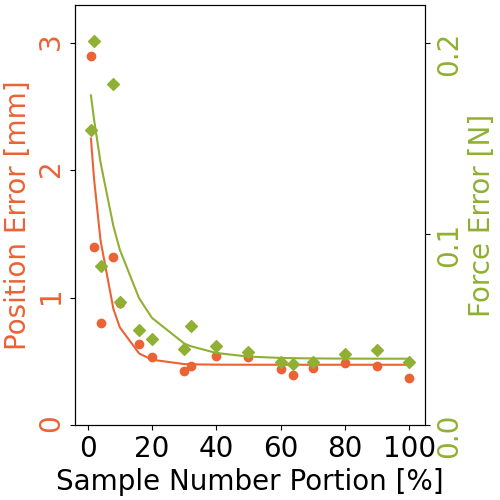

[2.17096936 0.2        0.47330814]
[0.15214802 0.09808879 0.03471308]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [7]:
e_PX = []
e_PY = []
e_PZ = []
e_PT = []
e_FX = []
e_FY = []
e_FZ = []
e_FT = []
for sp in [1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100]:
    if sp<100:
        error_pt = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_pt.npy")
        error_px = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_px.npy")
        error_py = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_py.npy")
        error_pz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_pz.npy")
        error_ft = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_ft.npy")
        error_fx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fx.npy")
        error_fy = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fy.npy")
        error_fz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_direct_prediction_sp"+str(sp)+"_fz.npy")
        e_PX.append(np.median(error_px))
        e_PY.append(np.median(error_py))
        e_PZ.append(np.median(error_pz))
        e_PT.append(np.median(error_pt))
        e_FX.append(np.median(error_fx))
        e_FY.append(np.median(error_fy))
        e_FZ.append(np.median(error_fz))
        e_FT.append(np.median(abs(error_ft)))
    else:
        e_PX.append(-0.11718440065383962)
        e_PY.append(0.01463399430364376)
        e_PZ.append(-0.007687911786140589)
        e_PT.append(0.3683696059128076)
        e_FX.append(-0.007195947034634137)
        e_FY.append(-0.0146374164699027)
        e_FZ.append(-0.010998234813772073)
        e_FT.append(0.03288601886272341)
x = np.asarray([1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100])
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(x, abs(np.asarray(e_PT)), c="#eb6235")
popt, pcov = curve_fit(func, x, abs(np.asarray(e_PT)),bounds=([0,0,0],[3,0.2,0.5]))
# popt, pcov = curve_fit(func, x, abs(np.asarray(e_PT)))
print(popt)
plt.plot(x, func(x, *popt),c="#eb6235")

ax.set_xticklabels(['d','0','20','40','60','80','100'],fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0, 3.1, 1),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90,color="#eb6235")

ax.set_xlabel("Sample Number Portion [%]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font, c="#eb6235")
ax.set_ylim(0,3.3)
# ax.grid(b=None)

ax2 = ax.twinx()  
ax2.scatter(x, abs(np.asarray(e_FT)), c="#8fb032", marker="D")
popt, pcov = curve_fit(func, x, abs(np.asarray(e_FT)))
plt.plot(x, func(x, *popt), c="#8fb032")
print(popt)
plt.yticks(np.arange(0, 0.21, 0.1),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90,color="#8fb032")
ax2.set_ylabel("Force Error [N]",fontproperties=font, c="#8fb032")
ax2.set_ylim(0,0.22)
plt.subplots_adjust(0.15,0.15,0.85,0.99)

# plt.savefig("../../Figure/Figure4_NMIRebuttal_SP_Direct_final.png",transparent=True)

<IPython.core.display.Javascript object>


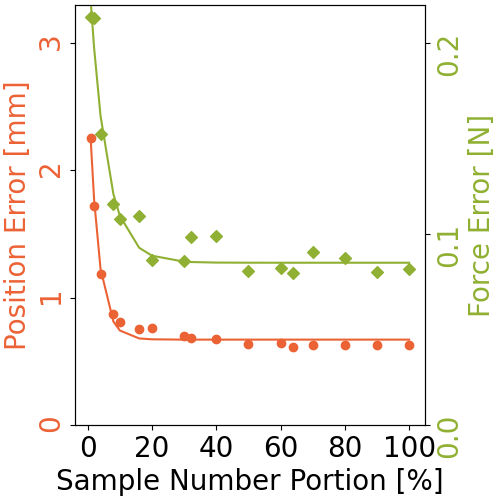

[2.17130176 0.34089444 0.67079674]
[0.16434144 0.18998187 0.085     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


In [8]:
e_PX = []
e_PY = []
e_PZ = []
e_PT = []
e_FX = []
e_FY = []
e_FZ = []
e_FT = []
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
xxxx = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
for sp in [1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100]:
    error_pt = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_pt.npy")
    error_px = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_px.npy")
    error_py = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_py.npy")
    error_pz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_pz.npy")
    error_ft = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_ft.npy")
    error_fx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_fx.npy")
    error_fy = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_fy.npy")
    error_fz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_SP"+str(sp)+"_fz.npy")
    e_PX.append(np.median(error_px[xxxx]))
    e_PY.append(np.median(error_py[xxxx]))
    e_PZ.append(np.median(error_pz[xxxx]))
    e_PT.append(np.median(error_pt[xxxx]))
    e_FX.append(np.median(error_fx[xxxx]))
    e_FY.append(np.median(error_fy[xxxx]))
    e_FZ.append(np.median(error_fz[xxxx]))
    e_FT.append(np.median(abs(error_ft[xxxx])))
x = np.asarray([1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100])
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(x, abs(np.asarray(e_PT)), c="#eb6235")
popt, pcov = curve_fit(func, x, abs(np.asarray(e_PT)),bounds=([0,0,0],[3,1,0.8]))
print(popt)
plt.plot(x, func(x, *popt),c="#eb6235")

ax.set_xticklabels(['d','0','20','40','60','80','100'],fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0, 3.1, 1),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90,color="#eb6235")

ax.set_xlabel("Sample Number Portion [%]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font, c="#eb6235")
ax.set_ylim(0,3.3)
# ax.grid(b=None)

ax2 = ax.twinx()  
ax2.scatter(x, abs(np.asarray(e_FT)), c="#8fb032", marker="D")
popt, pcov = curve_fit(func, x, abs(np.asarray(e_FT)),bounds=([0,0,0],[3,1,0.085]))
plt.plot(x, func(x, *popt), c="#8fb032")
print(popt)
plt.yticks(np.arange(0, 0.21, 0.1),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90,color="#8fb032")
ax2.set_ylabel("Force Error [N]",fontproperties=font, c="#8fb032")
ax2.set_ylim(0,0.22)
plt.subplots_adjust(0.15,0.15,0.85,0.99)

# plt.savefig("../../Figure/Figure4_NMIRebuttal_SP_Map_final.png",transparent=True)

<IPython.core.display.Javascript object>


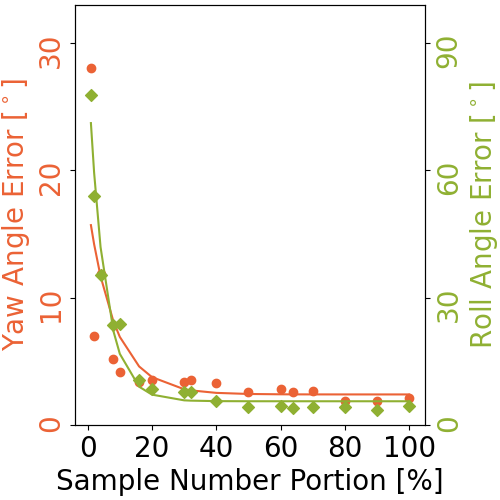

[15.          0.12        2.40106131]
[79.81916119  0.19665671  5.59602702]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
e_PX = []
e_PY = []
common_path1 = '/is/rg/al/Private/shuanbo/Insight/Gravity/'
ID = np.load(os.path.join(common_path1, 'test.npy'))
y = np.load("/is/rg/al/Private/shuanbo/Insight/Gravity/00_Gravity_Yaw_label.npy")[ID]
for sp in [1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100]:
    if sp<100:
        prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_gravity_SP"+str(sp)+"_pt.npy")
    else:
        prediction = np.load("/is/rg/al/Private/shuanbo/Insight/Gravity/test_prediction.npy")
    e_PX += [np.median(abs(y[:,0]-prediction[:,0]))]
    e_PY += [np.median(abs(y[:,1]-prediction[:,1]))]
x = np.asarray([1,2,4,8,10,16,20,30,32,40,50,60,64,70,80,90,100])
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(x, (np.asarray(e_PX)), c="#eb6235")
popt, pcov = curve_fit(func, x, (np.asarray(e_PX)),bounds=([0,0,0],[15,0.12,4]))
print(popt)
plt.plot(x, func(x, *popt),c="#eb6235")

ax.set_xticklabels(['d','0','20','40','60','80','100'],fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0, 30.1, 10),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90,color="#eb6235")

ax.set_xlabel("Sample Number Portion [%]",fontproperties=font)
ax.set_ylabel("Yaw Angle Error [$^\circ$]",fontproperties=font, c="#eb6235")
ax.set_ylim(0,33)
# ax.grid(b=None)

ax2 = ax.twinx()  
ax2.scatter(x, (np.asarray(e_PY)), c="#8fb032", marker="D")
popt, pcov = curve_fit(func, x, (np.asarray(e_PY)))
plt.plot(x, func(x, *popt), c="#8fb032")
print(popt)
plt.yticks(np.arange(0, 90.3, 30),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90,color="#8fb032")
ax2.set_ylabel("Roll Angle Error [$^\circ$]",fontproperties=font, c="#8fb032")
ax2.set_ylim(0,99)
plt.subplots_adjust(0.15,0.15,0.85,0.99)

# plt.savefig("../../Figure/Figure4_NMIRebuttal_SP_gravity_final.png",transparent=True)

## Map Ablation

### Prediction

In [ ]:
train_index = np.load("../Data/PostData/Data0/00_train_index.npy")
valid_index = np.load("../Data/PostData/Data0/00_valid_index.npy")
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn = torch.backends.cudnn
cudnn.benchmark = True
print(device)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
X4 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Position_reference.png')))
ID = test_index

In [ ]:
i = ID[1000]
X1 = np.asarray(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
X3 = np.asarray(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))

In [ ]:
fig = plt.figure(figsize=(20,4))
plt.subplot(161)
plt.imshow(X1)
plt.subplot(162)
plt.imshow(X3)
plt.subplot(163)
plt.imshow(X1-X3)
plt.subplot(164)
plt.imshow((X1-X3)[:,:,0])
plt.subplot(165)
plt.imshow((X1-X3)[:,:,1])
plt.subplot(166)
plt.imshow((X1-X3)[:,:,2])

In [ ]:
from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,6,2]
ab = 1
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = X1.to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 2
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = (X1-X3).to(device)
#     torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 4
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = ((X1-X3)[0].resize_(1,308,410)).to(device)
#     torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 5
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = ((X1-X3)[1].resize_(1,308,410)).to(device)
#     torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 6
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = ((X1-X3)[2].resize_(1,308,410)).to(device)
#     torch.cat([X1-X3, X2, X4[0][None, :, :]], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')).convert('L'))
ID = test_index

from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 3
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')).convert('L'))
    X = X = ((X1-X3).resize_(1,308,410)).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
ID = test_index

from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 7
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = torch.cat([X1-X3, X2], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')).convert('L'))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')).convert('L'))
ID = test_index

from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2]
ab = 8
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')).convert('L'))
    X = torch.cat([X1-X3, X2], 0).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
ID = test_index

from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2,2,2,2]
ab = 9
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = torch.cat([(X1-X3)[0], X2[0]], 0).resize_(2,308,410).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
ID = test_index

from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2,2,2,2]
ab = 10
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = torch.cat([(X1-X3)[1], X2[1]], 0).resize_(2,308,410).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

In [ ]:
common_path = "/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/"
X2 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Skeleton_reference.png')))
X3 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized_nocontact.png')))
ID = test_index

from model_rebuttal import NetForceMapAB
channel_list = [3,3,1,1,1,1,6,2,2,2,2]
ab = 11
model1 = NetForceMapAB(in_channels=channel_list[ab-1],output_shape=3)
model1.load_state_dict(torch.load("/is/sg/shuanbo/Desktop/Insigth_Rebuttal/Model/ForceMap_AB_"+str(ab)+".pth"))
model1.to(device)
model1.eval()

count = 0
for i in ID:
    X1 = TF.to_tensor(Image.open(os.path.join(common_path, 'Data0/Resized'+str(i)+'.png')))
    X = torch.cat([(X1-X3)[2], X2[2]], 0).resize_(2,308,410).to(device)
    predict = model1(X[None,:,:,:]).cpu().data.numpy()[0]/4096.0
    if count %50 ==49:
        print(count)
    count += 1
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy",predict)

### Evaluation

In [ ]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180.0

In [ ]:
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
ground_truth_ = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
ID = test_index
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
for ab in [1,2,3,4,5,6,7,8]:
    px = []
    py = []
    pz = []
    fx = []
    fy = []
    fz = []
    angle = []
    disk = []
    for i in ID:
        prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy")
        prediction_ = np.zeros((3,4096))
        prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
        prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
        prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
        force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
        px += [np.mean(force[:,0])]
        py += [np.mean(force[:,1])]
        pz += [np.mean(force[:,2])]

        fx += [np.sum(prediction_[0,col_ind])]
        fy += [np.sum(prediction_[1,col_ind])]
        fz += [np.sum(prediction_[2,col_ind])]

        angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth_[i,24],ground_truth_[i,25],ground_truth_[i,26]])]

        xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
        if xx[0].shape[0] >0:
            disk += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
        else:
            disk += [0]

    error_px = np.asarray((px-ground_truth[:,1]))
    error_py = np.asarray((py-ground_truth[:,2]))
    error_pz = np.asarray((pz-ground_truth[:,3]))
    error_p = np.vstack((error_px,error_py,error_pz))
    error_pt = np.asarray(np.linalg.norm(error_p,axis=0))

    error_fx = np.asarray(fx-ground_truth[:,24])
    error_fy = np.asarray(fy-ground_truth[:,25])
    error_fz = np.asarray(fz-ground_truth[:,26])

    error_f_ = np.vstack((fx,fy,fz))
    error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
    xxxx = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(np.asarray(disk)[xxxx]))
    print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(np.asarray(disk)[xxxx]))
    ax1.scatter(np.linalg.norm(ground_truth[:,24:27],axis=1),error_pt,label=str(ab))
    ax2.scatter(np.linalg.norm(ground_truth[:,24:27],axis=1),error_ft,label=str(ab))

In [ ]:
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]
ground_truth_ = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")
col_ind = np.load("../Data/Information/01_OuterSurfaceNodeMap_Image.npy")
indentation_info = np.load("../Data/Information/00_OuterSurface_info_all.npy")[1195:]
ID = test_index
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
# for ab in [1,2,3,4,5,6,7,8,9,10,11]:
for ab in [9,10,11]:
    px = []
    py = []
    pz = []
    fx = []
    fy = []
    fz = []
    angle = []
    disk = []
    for i in ID:
        prediction = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_"+str(i)+".npy")
        prediction_ = np.zeros((3,4096))
        prediction_[0] = np.flipud(prediction[0].reshape((64,64))).flatten()
        prediction_[1] = np.flipud(prediction[1].reshape((64,64))).flatten()
        prediction_[2] = np.flipud(prediction[2].reshape((64,64))).flatten()
        force = indentation_info[np.argsort(np.linalg.norm(prediction_[:,col_ind],axis=0))[::-1][:20],1:4]
        px += [np.mean(force[:,0])]
        py += [np.mean(force[:,1])]
        pz += [np.mean(force[:,2])]

        fx += [np.sum(prediction_[0,col_ind])]
        fy += [np.sum(prediction_[1,col_ind])]
        fz += [np.sum(prediction_[2,col_ind])]

        angle += [angle_between([np.sum(prediction_[0,col_ind]),np.sum(prediction_[1,col_ind]),np.sum(prediction_[2,col_ind])],[ground_truth_[i,24],ground_truth_[i,25],ground_truth_[i,26]])]

        xx = np.where(np.linalg.norm(prediction_[:,col_ind],axis=0)>0.02)
        if xx[0].shape[0] >0:
            disk += [2*np.sqrt(xx[0].shape[0]/np.pi)-1]
        else:
            disk += [0]

    error_px = np.asarray((px-ground_truth[:,1]))
    error_py = np.asarray((py-ground_truth[:,2]))
    error_pz = np.asarray((pz-ground_truth[:,3]))
    error_p = np.vstack((error_px,error_py,error_pz))
    error_pt = np.asarray(np.linalg.norm(error_p,axis=0))

    error_fx = np.asarray(fx-ground_truth[:,24])
    error_fy = np.asarray(fy-ground_truth[:,25])
    error_fz = np.asarray(fz-ground_truth[:,26])

    error_f_ = np.vstack((fx,fy,fz))
    print(error_f_.shape)
    error_ft = (np.asarray(np.linalg.norm(error_f_,axis=0)-np.linalg.norm(ground_truth[:,24:27],axis=1)))
    xxxx = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)<=2.0) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    print(np.median(abs(error_pt[xxxx])),np.median(abs(error_ft[xxxx])),np.median(np.asarray(angle)[xxxx]),np.median(np.asarray(disk)[xxxx]))
    print(np.mean(abs(error_pt[xxxx])),np.mean(abs(error_ft[xxxx])),np.mean(np.asarray(angle)[xxxx]),np.mean(np.asarray(disk)[xxxx]))
    ax1.hist(error_pt,label=str(ab))
    ax2.hist(error_ft,label=str(ab))
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pt.npy",error_pt)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_px.npy",error_px)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_py.npy",error_py)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pz.npy",error_pz)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_ft.npy",error_ft)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fx.npy",error_fx)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fy.npy",error_fy)
    np.save("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fz.npy",error_fz)

In [ ]:
EPT = np.zeros((36834,8))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(12,6))
for ab in [1,2,3,4,5,6,7,8]:
    error_pt = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pt.npy")
    error_px = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_px.npy")
    error_py = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_py.npy")
    error_pz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pz.npy")
    error_ft = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_ft.npy")
    error_fx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fx.npy")
    error_fy = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fy.npy")
    error_fz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fz.npy")
    EPT[:,ab-1]=error_pt
    EFT[:,ab-1]=error_ft
    ax1.hist(error_pt,label=str(ab),bins=np.arange(0, 2, 0.1),alpha=0.5)
    ax2.hist(error_ft,label=str(ab),bins=np.arange(-1, 1, 0.01),alpha=0.5)
ax1.legend()
ax2.legend()

In [ ]:
EPT = np.zeros((36834,8))
EFT = np.zeros((36834,8))
for ab in [1,2,3,4,5,6,7,8]:
    error_pt = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pt.npy")
    error_px = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_px.npy")
    error_py = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_py.npy")
    error_pz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pz.npy")
    error_ft = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_ft.npy")
    error_fx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fx.npy")
    error_fy = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fy.npy")
    error_fz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fz.npy")
    EPT[:,ab-1]=abs(error_pt)
    EFT[:,ab-1]=abs(error_ft)

EPT_red = np.zeros((40,8))
EFT_red = np.zeros((40,8))
for i in range(40):
    index = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)>=i*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)<(i+1)*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    EPT_red[i,:] = np.mean(abs(EPT[index]),axis=0)
    EFT_red[i,:] = np.mean((EFT[index]),axis=0)
X = np.arange(1, 9, 1)
Y = np.arange(0.04, 1.64, 0.04)
X, Y = np.meshgrid(X, Y)
    
fig, (ax1,ax2) = plt.subplots(1, 2,subplot_kw={"projection": "3d"},figsize=(12,6))
surf1 = ax1.plot_surface(X,Y,(EPT_red),cmap=cm.coolwarm)
surf2 = ax2.plot_surface(X,Y,(EFT_red),cmap=cm.coolwarm)

EPT_red = np.zeros((40,8))
EFT_red = np.zeros((40,8))
for i in range(40):
    index = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)>=i*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)<(i+1)*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    EPT_red[i,:] = np.std((EPT[index]),axis=0)
    EFT_red[i,:] = np.std((EFT[index]),axis=0)
X = np.arange(1, 9, 1)
Y = np.arange(0.04, 1.64, 0.04)
X, Y = np.meshgrid(X, Y)
    
fig, (ax1,ax2) = plt.subplots(1, 2,subplot_kw={"projection": "3d"},figsize=(12,6))
surf1 = ax1.plot_surface(X,Y,(EPT_red),cmap=cm.coolwarm)
surf2 = ax2.plot_surface(X,Y,(EFT_red),cmap=cm.coolwarm)

EPT_red = np.zeros((40,8))
EFT_red = np.zeros((40,8))
for i in range(40):
    index = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)>=i*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)<(i+1)*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    EPT_red[i,:] = np.median(abs(EPT[index]),axis=0)
    EFT_red[i,:] = np.median(abs(EFT[index]),axis=0)
X = np.arange(1, 9, 1)
Y = np.arange(0.04, 1.64, 0.04)
X, Y = np.meshgrid(X, Y)
    
fig, (ax1,ax2) = plt.subplots(1, 2,subplot_kw={"projection": "3d"},figsize=(12,6))
surf1 = ax1.plot_surface(X,Y,(EPT_red),cmap=cm.coolwarm)
surf2 = ax2.plot_surface(X,Y,(EFT_red),cmap=cm.coolwarm)

# EPT_red = np.zeros((40,8))
# EFT_red = np.zeros((40,8))
# for i in range(40):
#     index = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)>=i*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)<(i+1)*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
#     EPT_red[i,:] = np.median(abs(EPT[index]),axis=0)
#     EFT_red[i,:] = np.median(abs(EFT[index]),axis=0)
# X = np.arange(1, 9, 1)
# Y = np.arange(0.04, 1.64, 0.04)
# X, Y = np.meshgrid(X, Y)
    
# fig, (ax1,ax2) = plt.subplots(1, 2,subplot_kw={"projection": "3d"},figsize=(12,6))
# surf1 = ax1.plot_surface(X,Y,(EPT_red),cmap=cm.coolwarm)
# surf2 = ax2.plot_surface(X,Y,(EFT_red),cmap=cm.coolwarm)

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
for i in [0,1,6]:
    learning1 = np.loadtxt("/is/sg/shuanbo/Desktop/output"+str(i+1)+".txt").reshape((284,3))
    plt.plot(learning1[:,0],label=str(i+1))
plt.legend()
plt.subplot(122)
for i in [0,1,6]:
    learning1 = np.loadtxt("/is/sg/shuanbo/Desktop/output"+str(i+1)+".txt").reshape((284,3))[:,1]
    y_smooth = gaussian_filter1d(learning1,sigma=5)
    plt.plot(y_smooth,label=str(i+1))
plt.legend()

In [ ]:
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]

### Figure

In [10]:
test_index = np.load("../Data/PostData/Data0/00_test_index.npy")
ground_truth = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/0000_single_direct_groundtruth_rescaled_0.npy")[test_index]

<IPython.core.display.Javascript object>


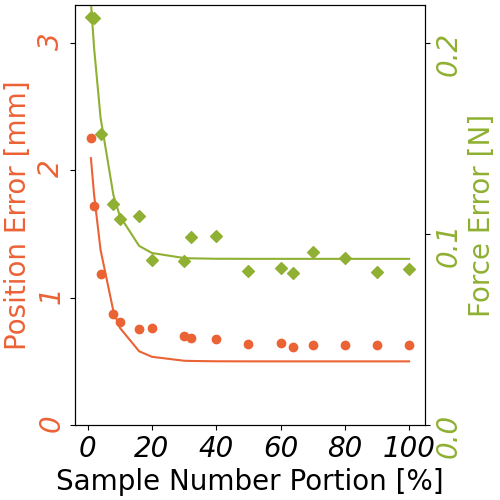

[1.950045 0.2      0.5     ]
[0.16412633 0.19905699 0.08702872]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


In [11]:
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(x, abs(np.asarray(e_PT)), c="#eb6235")
popt, pcov = curve_fit(func, x, abs(np.asarray(e_PT)),bounds=([0,0,0],[3,0.2,0.5]))
# popt, pcov = curve_fit(func, x, abs(np.asarray(e_PT)))
print(popt)
plt.plot(x, func(x, *popt),c="#eb6235")

ax.set_xticklabels(['d','0','20','40','60','80','100'],fontsize=20,fontstyle='italic',fontname='Times New Roman')
plt.yticks(np.arange(0, 3.1, 1),fontsize=20,fontstyle='italic',fontname='Times New Roman',rotation=90,color="#eb6235")

ax.set_xlabel("Sample Number Portion [%]",fontproperties=font)
ax.set_ylabel("Position Error [mm]",fontproperties=font, c="#eb6235")
ax.set_ylim(0,3.3)
# ax.grid(b=None)

ax2 = ax.twinx()  
ax2.scatter(x, abs(np.asarray(e_FT)), c="#8fb032", marker="D")
popt, pcov = curve_fit(func, x, abs(np.asarray(e_FT)))
plt.plot(x, func(x, *popt), c="#8fb032")
print(popt)
plt.yticks(np.arange(0, 0.21, 0.1),fontsize=20,fontstyle='italic',fontname='Times New Roman',rotation=90,color="#8fb032")
ax2.set_ylabel("Force Error [N]",fontproperties=font, c="#8fb032")
ax2.set_ylim(0,0.22)
plt.subplots_adjust(0.15,0.15,0.85,0.99)

# plt.savefig("../../Figure/Figure4_NMIRebuttal_SP_Direct.png",transparent=True)

In [12]:
EPT = np.zeros((36834,11))
EFT = np.zeros((36834,11))
for ab in [1,2,3,4,5,6,7,8,9,10,11]:
    error_pt = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pt.npy")
    error_px = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_px.npy")
    error_py = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_py.npy")
    error_pz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_pz.npy")
    error_ft = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_ft.npy")
    error_fx = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fx.npy")
    error_fy = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fy.npy")
    error_fz = np.load("/mnt/local/Insight_Rebuttal/Data_Collection/Data/PostData/Data19/Predicted_Map2_AB"+str(ab)+"_fz.npy")
    EPT[:,ab-1]=(error_pt)
    EFT[:,ab-1]=(error_ft)

EPT_red = np.zeros((41,11))
EFT_red = np.zeros((41,11))
for i in range(41):
    index = np.where((np.linalg.norm(ground_truth[:,24:27],axis=1)>=i*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)<(i+1)*0.04) & (np.linalg.norm(ground_truth[:,24:27],axis=1)>=0.02))
    EPT_red[i,:] = np.median((EPT[index]),axis=0)
    EFT_red[i,:] = np.median((EFT[index]),axis=0)#/((i+1)*0.04)

xx = np.linspace(0,1.6,41)
colorsss = ["#eb6235", "#8fb032", "#5e81b5", "#929600", "#5d9ec7", "#e19c24", "#8778b3","#c56e1a"]

<IPython.core.display.Javascript object>


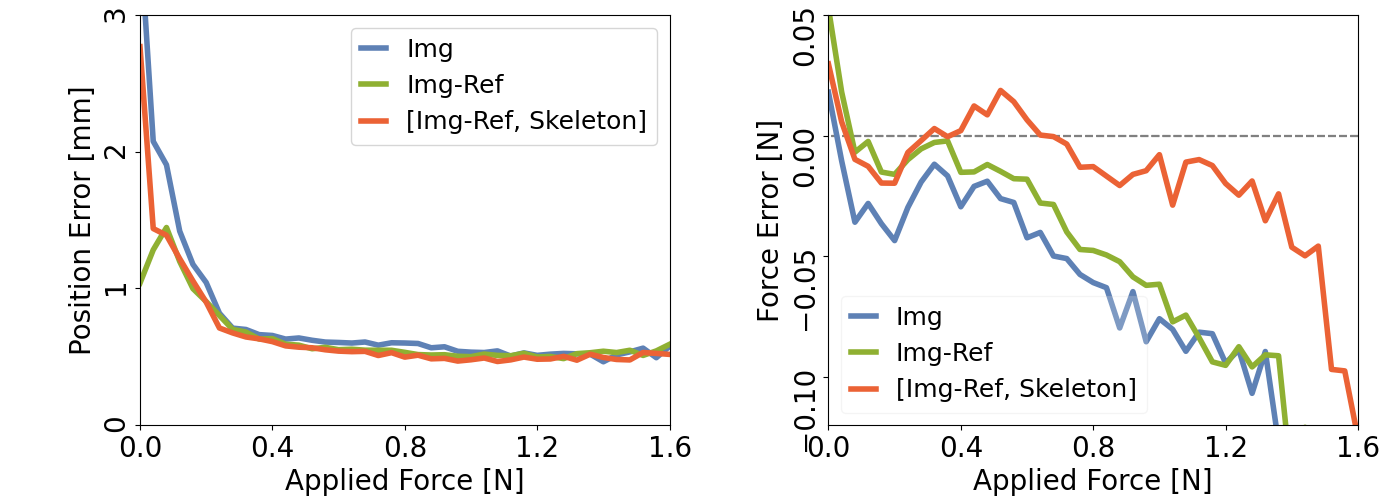

In [13]:
# ablation: input
fig = plt.figure(figsize=(14,5))
plt.subplot(121)
count = 0
legendlabel = ["Img", "Img-Ref", "[Img-Ref, Skeleton]"]
for i in [0,1,6]:
    plt.plot(xx,EPT_red[:,i],label=legendlabel[count],color=colorsss[2-count],linewidth=4)
    count += 1
plt.xticks(np.arange(0,1.7,0.4),fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0,3.1,1.0),fontsize=20,fontstyle='normal',rotation=90,fontname='Arial')
plt.xlabel("Applied Force [N]",fontsize=20,fontstyle='normal',fontname='Arial')
plt.ylabel("Position Error [mm]",fontsize=20,fontstyle='normal',rotation=90,fontname='Arial')
plt.legend(fontsize=18,handlelength=1)
plt.xlim([0,1.6])
plt.ylim([0,3])
plt.subplot(122)
count = 0
for i in [0,1,6]:
    plt.plot(xx,EFT_red[:,i],label=legendlabel[count],color=colorsss[2-count],linewidth=4)
    plt.hlines(0,1.6,0,color='gray',linestyle='dashed')
    count += 1
plt.xticks(np.arange(0,1.7,0.4),fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(-0.1,0.05,0.05),fontsize=20,fontstyle='normal',rotation=90,fontname='Arial')
plt.xlabel("Applied Force [N]",fontsize=20,fontstyle='normal',fontname='Arial')
plt.ylabel("Force Error [N]",fontsize=20,fontstyle='normal',rotation=90,fontname='Arial')
plt.legend(fontsize=18,handlelength=1,framealpha=0.2)
plt.xlim([0,1.6])
plt.ylim([-0.12,0.05])
plt.subplots_adjust(0.10,0.15,0.97,0.97,wspace=0.3)
# plt.savefig("../../Figure/FigureS_NMIRebuttal_Ablation_Skeleton_final.png",transparent=True)

<IPython.core.display.Javascript object>


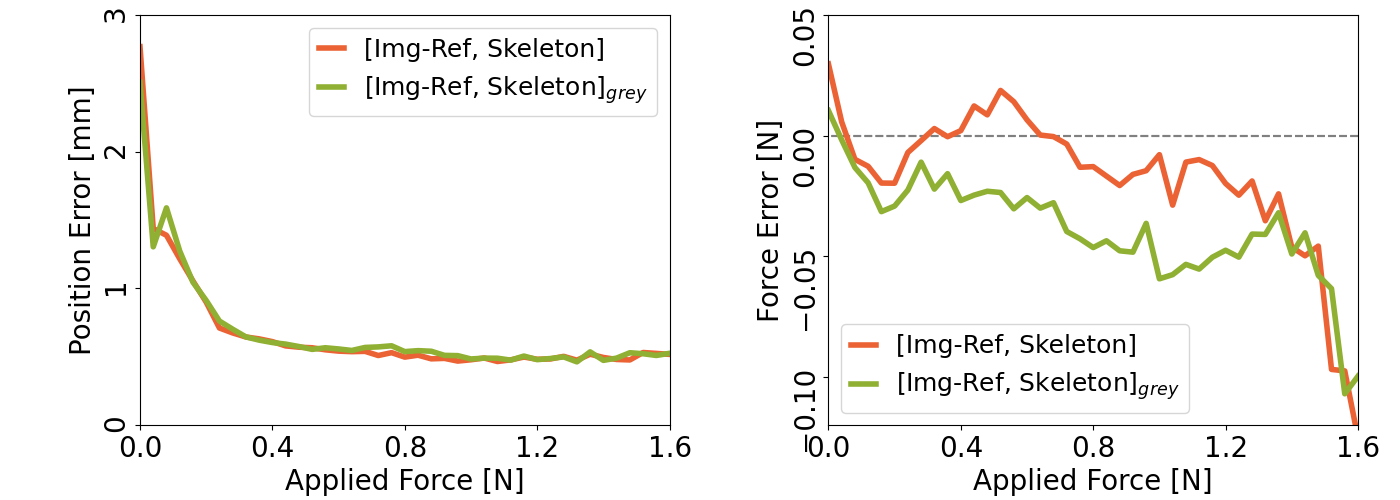

In [14]:
# pure ps vs ps+sl
fig = plt.figure(figsize=(14,5))
plt.subplot(121)
count = 0
legendlabel = ["[Img-Ref, Skeleton]", "[Img-Ref, Skeleton]$_{grey}$"]
for i in [6,7]:
    plt.plot(xx,EPT_red[:,i],label=legendlabel[count],color=colorsss[count],linewidth=4)
    count += 1
plt.xticks(np.arange(0,1.7,0.4),fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(0,3.1,1.0),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90)
plt.xlabel("Applied Force [N]",fontsize=20,fontstyle='normal',fontname='Arial')
plt.ylabel("Position Error [mm]",fontsize=20,fontstyle='normal',fontname='Arial',rotation=90)
plt.legend(fontsize=18,handlelength=1)
plt.xlim([0,1.6])
plt.ylim([0,3])
plt.subplot(122)
count = 0
for i in [6,7]:
    plt.plot(xx,EFT_red[:,i],label=legendlabel[count],color=colorsss[count],linewidth=4)
    plt.hlines(0,1.6,0,color='grey',linestyle='dashed')
    count += 1
plt.xticks(np.arange(0,1.7,0.4),fontsize=20,fontstyle='normal',fontname='Arial')
plt.yticks(np.arange(-0.1,0.05,0.05),fontsize=20,fontstyle='normal',fontname='Arial',rotation=90)
plt.xlabel("Applied Force [N]",fontsize=20,fontstyle='normal',fontname='Arial')
plt.ylabel("Force Error [N]",fontsize=20,fontstyle='normal',fontname='Arial',rotation=90)
plt.legend(fontsize=18,handlelength=1)
plt.xlim([0,1.6])
plt.ylim([-0.12,0.05])
plt.subplots_adjust(0.10,0.15,0.97,0.97,wspace=0.3)
plt.savefig("../../Figure/FigureS_NMIRebuttal_Ablation_PurePS_final.png",transparent=True)

<IPython.core.display.Javascript object>


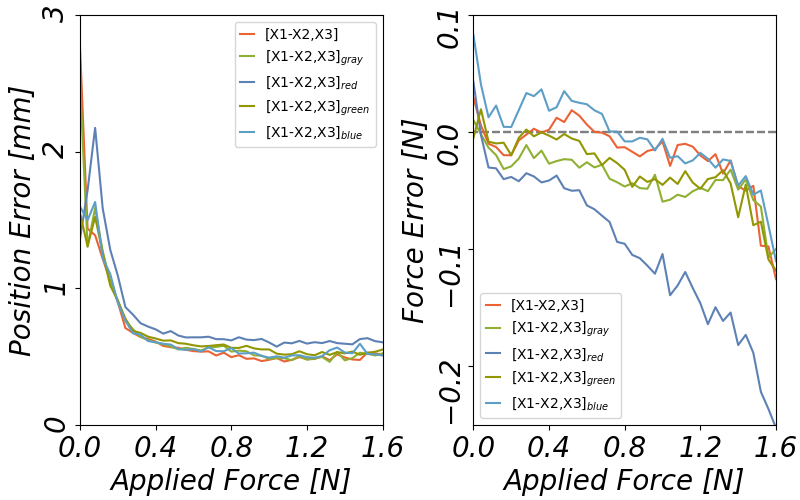

In [42]:
fig = plt.figure(figsize=(8,5))

plt.subplot(121)
count = 0
legendlabel = ["[X1-X2,X3]", "[X1-X2,X3]$_{gray}$","[X1-X2,X3]$_{red}$","[X1-X2,X3]$_{green}$","[X1-X2,X3]$_{blue}$"]
for i in [6,7,8,9,10]:
    plt.plot(xx,EPT_red[:,i],label=legendlabel[count],color=colorsss[count])
    count += 1
plt.xticks(np.arange(0,1.7,0.4),fontsize=20,fontstyle='italic',fontname='Times New Roman')
plt.yticks(np.arange(0,3.1,1.0),fontsize=20,fontstyle='italic',rotation=90,fontname='Times New Roman')
plt.xlabel("Applied Force [N]",fontsize=20,fontstyle='italic',fontname='Times New Roman')
plt.ylabel("Position Error [mm]",fontsize=20,fontstyle='italic',rotation=90,fontname='Times New Roman')
plt.legend(fontsize=10,handlelength=1)
plt.xlim([0,1.6])
plt.ylim([0,3])
plt.subplot(122)
count = 0
for i in [6,7,8,9,10]:
    plt.plot(xx,EFT_red[:,i],label=legendlabel[count],color=colorsss[count])
    plt.hlines(0,1.6,0,color='gray',linestyle='dashed')
    count += 1
plt.xticks(np.arange(0,1.7,0.4),fontsize=20,fontstyle='italic',fontname='Times New Roman')
plt.yticks(np.arange(-0.2,0.11,0.1),fontsize=20,fontstyle='italic',rotation=90,fontname='Times New Roman')
plt.xlabel("Applied Force [N]",fontsize=20,fontstyle='italic',fontname='Times New Roman')
plt.ylabel("Force Error [N]",fontsize=20,fontstyle='italic',rotation=90,fontname='Times New Roman')
plt.legend(fontsize=10,handlelength=1)
plt.xlim([0,1.6])
plt.ylim([-0.25,0.1])
plt.subplots_adjust(0.10,0.15,0.97,0.97,wspace=0.3)
# plt.savefig("../../Figure/FigureS_NMIRebuttal_Ablation_PurePS.png",transparent=True)

# Rest

In [ ]:
goto_position(160,20,210-200,1)

In [ ]:
goto_position(124.3,62,115.0,1)

In [ ]:
motor.set_goal_position_speed_load({1:(-180+22.5+45.0,0.01,100)})
motor.set_goal_position_speed_load({2:(-76.5,0.01,100)})

In [ ]:
def position_step(z,depth,speed):
    goto_position(124.3,z,depth,speed*10**5)
    time.sleep(6)

In [ ]:
goto_position(124.3,62,115.0,1)
time.sleep(3)
depth = 120.6
goto_position(124.3,62,depth,1)
time.sleep(5)
for i in range(2):
    position_step(58,depth,10)
    position_step(54,depth,10)
    position_step(50,depth,10)
    position_step(46,depth,10)
    position_step(42,depth,10)
    position_step(46,depth,10)
    position_step(50,depth,10)
    position_step(54,depth,10)
    position_step(58,depth,10)
    position_step(62,depth,10)
    time.sleep(5)
for i in range(2):
    position_step(42,depth,15)
    time.sleep(8)
    position_step(62,depth,15)
    time.sleep(8)

In [ ]:
while True:
    try:
        image = imaging(receving)
    except:
        print("done")

In [ ]:
for i in [60,50,40,30,20,10]:
    goto_position(160,20,210-i,1)
    time.sleep(3)
    brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
    connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
    image = imaging(receving)
    time.sleep(5)
    image.save("../Data/"+str(i)+".png")

In [ ]:
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
image = imaging(receving)
fig = plt.figure()
plt.imshow(image)

# Experiment 1: FOV

- FOV for 1640x1232x40:123.8 x 91.0 degree
- FOV for 1280x 720x90:94.7 x 52.7 degree
- FOV for  640x 480x90: 46.8 x 34.8 degree

## Table 1

- Table 1-1: 1640x1232x40

|Axis|P1|P2|P3|P4|P5|P6|P7|P8|P9|P10|P11|P12|P13|P14|P15|P16|P17|P18|P19|P20|
|----|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Z [mm]   |0 |1 |2 |3 |4 |5 |6 |7 |8  |9 |10 |20 |30 |40 |50 |60 |70 |80|90|99|
|X [mm]   |7.2|10.0|13.0|15.0|19.0|24.0|27.0|30.0|35.0|38.0|42.0|80.0|118.0|155.0|0|0|0|0|0|0|
|Y [mm]   |5.0|6.0|8.0|9.5|11.0|13.5|15.0|18.0|19.0|22.0|24.0|43.0|65.0|86.0|106.0|125.0|146.0|0|0|0|
|X_new [mm]|5.002|8.748|12.494|16.240|19.986|23.732|27.478|31.224|34.970|38.716|42.462|79.923|117.383|154.843|192.304|229.764|267.225|0|0|0|
|Y_new [mm]|3.545|5.581|7.617|9.653|11.689|13.725|15.762|17.798|19.834|21.870|23.906|44.267|64.628|84.990|105.351|125.712|146.073|0|0|0|

- Table 1-2: 1280x720x90

|Axis|P1|P2|P3|P4|P5|P6|P7|P8|P9|P10|P11|P12|P13|P14|P15|P16|P17|P18|P19|P20|
|----|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Z [mm]  |0 |1 |2 |3 |4 |5 |6 |7 |8  |9 |10 |20 |30 |40 |50 |60 |70 |80|90|99|
|X [mm]  |6.0|6.0|8.0|10.0|12.0|15.0|17.0|19.0|21.0|23.0|25.0|47.0|69.0|92.0|112.0|134.0|156.0|0|0|0|
|Y [mm]  |3.2|3.5|4.5|5.5|6.5|8.0|8.5|9.0|10.0|11.0|12.0|21.0|31.0|41.0|52.0|62.0|72.0|82.0|92.0|100.0|

- Table 1-3: 640x480x90

|Axis|P1|P2|P3|P4|P5|P6|P7|P8|P9|P10|P11|P12|P13|P14|P15|P16|P17|P18|P19|P20|
|----|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Z [mm]  |0 |1 |2 |3 |4 |5 |6 |7 |8  |9 |10 |20 |30 |40 |50 |60 |70 |80|90|99|
|X [mm]  |0.0|3.0|3.5|4.5|5.5|6.5|7.0|8.0|8.5|9.5|10.5|19.0|28.0|37.0|46.0|54.0|62.0|71.0|80.0|87.5|
|Y [mm]  |0.0|2.5|3.0|3.5|4.0|4.5|5.2|6.0|6.5|7.0|8.0|14.0|20.0|26.0|33.0|39.0|46.0|52.0|58.0|64.0|

## Figure 1

In [ ]:
z = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,99]
x1 = [7.2,10.0,13.0,15.0,19.0,24.0,27.0,30.0,35.0,38.0,42.0,80.0,118.0,155.0,0,0,0,0,0,0]
y1 = [5.0,6.0,8.0,9.5,11.0,13.5,15.0,18.0,19.0,22.0,24.0,43.0,65.0,86.0,106.0,125.0,146.0,0,0,0]
x2 = [6.0,6.0,8.0,10.0,12.0,15.0,17.0,19.0,21.0,23.0,25.0,47.0,69.0,92.0,112.0,134.0,156.0,0,0,0]
y2 = [3.2,3.5,4.5,5.5,6.5,8.0,8.5,9.0,10.0,11.0,12.0,21.0,31.0,41.0,52.0,62.0,72.0,82.0,92.0,100.0]
x3 = [0,3.0,3.5,4.5,5.5,6.5,7.0,8.0,8.5,9.5,10.5,19.0,28.0,37.0,46.0,54.0,62.0,71.0,80.0,87.5]
y3 = [0,2.5,3.0,3.5,4.0,4.5,5.2,6.0,6.5,7.0,8.0,14.0,20.0,26.0,33.0,39.0,46.0,52.0,58.0,64.0]

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.scatter(z,x1)
plt.plot(z,x1)
plt.scatter(z,y1)
plt.plot(z,y1)
plt.scatter(z,x2)
plt.plot(z,x2)
plt.scatter(z,y2)
plt.plot(z,y2)
plt.scatter(z,x3)
plt.plot(z,x3)
plt.scatter(z,y3)
plt.plot(z,y3)
plt.plot(np.unique(z[0:14]), np.poly1d(np.polyfit(z[0:14], x1[0:14], 1))(np.unique(z[0:14])))
plt.plot(np.unique(z[0:17]), np.poly1d(np.polyfit(z[0:17], y1[0:17], 1))(np.unique(z[0:17])))
plt.plot(np.unique(z[0:17]), np.poly1d(np.polyfit(z[0:17], x2[0:17], 1))(np.unique(z[0:17])))
plt.plot(np.unique(z), np.poly1d(np.polyfit(z, y2, 1))(np.unique(z)))
plt.plot(np.unique(z[1:]), np.poly1d(np.polyfit(z[1:], x3[1:], 1))(np.unique(z[1:])))
plt.plot(np.unique(z[1:]), np.poly1d(np.polyfit(z[1:], y3[1:], 1))(np.unique(z[1:])))
plt.title("FOV:" + str(np.round(np.arctan((144.17364451-1.87)/70.0/2.0)*180.0/np.pi*2.0,2))+"Degree")
plt.xlabel("Distance Z [mm]")
plt.ylabel("FOV Dimension D [mm]")
plt.show

In [ ]:
x1_new = np.poly1d(np.polyfit(z[0:14], x1[0:14], 1))(np.unique(z[0:14]))/2.0
x1_rate = (x1_new[13]-x1_new[0])/(z[13]-z[0])
print("FOV_X1:"+str(np.arctan(x1_rate)/np.pi*180.0))

y1_new = np.poly1d(np.polyfit(z[0:17], y1[0:17], 1))(np.unique(z[0:17]))/2.0
y1_rate = (y1_new[16]-y1_new[0])/(z[16]-z[0])
print("FOV_Y1:"+str(np.arctan(y1_rate)/np.pi*180.0))

x2_new = np.poly1d(np.polyfit(z[0:17], x2[0:17], 1))(np.unique(z[0:17]))/2.0
x2_rate = (x2_new[16]-x2_new[0])/(z[16]-z[0])
print("FOV_X2:"+str(np.arctan(x2_rate)/np.pi*180.0))

y2_new = np.poly1d(np.polyfit(z, y2, 1))(np.unique(z))/2.0
y2_rate = (y2_new[19]-y2_new[0])/(z[19]-z[0])
print("FOV_Y2:"+str(np.arctan(y2_rate)/np.pi*180.0))

x3_new = np.poly1d(np.polyfit(z[1:], x3[1:], 1))(np.unique(z[1:]))/2.0
x3_rate = (x3_new[18]-x3_new[0])/(z[19]-z[1])
print("FOV_X3:"+str(np.arctan(x3_rate)/np.pi*180.0))

y3_new = np.poly1d(np.polyfit(z[1:], y3[1:], 1))(np.unique(z[1:]))/2.0
y3_rate = (y3_new[18]-y2_new[0])/(z[19]-z[1])
print("FOV_Y3:"+str(np.arctan(y3_rate)/np.pi*180.0))

In [ ]:
## Ratio of FOV comparison
print(1640.0/1232.0)
print(61.90239783925121/45.51269744881967*3)

print(1280/720.0)
print(47.35153095459011/26.34930818008342*9)

print(640.0/480.0)
print(23.409498815078393/17.41717538727886*3)

## Data

### P:1640x1232x40, C:W, B:1.0

In [ ]:
get_position()
get_force()
goto_position(178.5,128.5,0)
motor.set_goal_position({1:2})
motor.set_goal_position({2:0})

In [ ]:
goto_position(178.5,128.5,85.5)

In [ ]:
for a in range(100):
    goto_position(178.5,128.5,85.5-a)
    time.sleep(2)
    connection[0].send("W"+str(1.0)+str(8))
    image = imaging(receving)
    figure = plt.figure(figsize=(8,6))
    plt.imshow(image)
    plt.title("Pixel1640x1232*FPS40*Brightness1+Distance"+str(a))
    plt.savefig("../Data/Experiment_01/1640X1232X40_B1/"+str(a)+"_mm.png")

In [ ]:
# X = 60.6x2 degree
X = np.arctan((35.0*5.0/2.0-2.3*5.0/2.0)/(47.0-1.0))/np.pi*180.0
# Y = 44.4x2 degree
Y_1 = np.arctan((35.5*5.0/2.0-1.8*5.0/2.0)/(88.0-2.0))/np.pi*180.0
Y_2 = np.arctan((32.5*5.0/2.0-4.3*5.0/2.0)/(80.0-8.0))/np.pi*180.0
Y = (Y_1 + Y_2)/2.0

### P:1280x720x90, C:W, B:1.0

In [ ]:
get_position()
get_force()
goto_position(175.9,128.5,0)
motor.set_goal_position({1:1})
motor.set_goal_position({2:0})

In [ ]:
goto_position(175.9,128.5,85.5)

In [ ]:
for a in range(100):
    goto_position(175.9,128.5,85.5-a)
    time.sleep(2)
    connection[0].send("W"+str(1.0)+str(8))
    image = imaging(receving)
    figure = plt.figure(figsize=(8,6))
    plt.imshow(image)
    plt.title("Pixel1280x720*FPS90*Brightness1+Distance"+str(a))
    plt.savefig("../Data/Experiment_01/1280X720X90_B1/"+str(a)+"_mm.png")

In [ ]:
# X = 60.6x2 degree
X = np.arctan((35.0*5.0/2.0-2.3*5.0/2.0)/(47.0-1.0))/np.pi*180.0
# Y = 44.4x2 degree
Y_1 = np.arctan((35.5*5.0/2.0-1.8*5.0/2.0)/(88.0-2.0))/np.pi*180.0
Y_2 = np.arctan((32.5*5.0/2.0-4.3*5.0/2.0)/(80.0-8.0))/np.pi*180.0
Y = (Y_1 + Y_2)/2.0

### P:640x480x90, C:W, B:1.0

In [ ]:
get_position()
get_force()
goto_position(175.9,128.5,0)
motor.set_goal_position({1:0})
motor.set_goal_position({2:0})

In [ ]:
goto_position(175.9,128.5,85.5)

In [ ]:
for a in range(100):
    goto_position(175.9,128.5,85.5-a)
    time.sleep(2)
    connection[0].send("W"+str(1.0)+str(8))
    time.sleep(1)
    image = imaging(receving)
    figure = plt.figure(figsize=(8,6))
    plt.imshow(image)
    plt.title("Pixel640X480*FPS90*Brightness1+Distance"+str(a))
    plt.savefig("../Data/Experiment_01/640X480X90_B1/"+str(a)+"_mm.png")

In [ ]:
# X = 60.6x2 degree
X = np.arctan((35.0*5.0/2.0-2.3*5.0/2.0)/(47.0-1.0))/np.pi*180.0
# Y = 44.4x2 degree
Y_1 = np.arctan((35.5*5.0/2.0-1.8*5.0/2.0)/(88.0-2.0))/np.pi*180.0
Y_2 = np.arctan((32.5*5.0/2.0-4.3*5.0/2.0)/(80.0-8.0))/np.pi*180.0
Y = (Y_1 + Y_2)/2.0

# Experiment 2: Collimator

- Collimator Size
- Light Intensity
    - Sum(B) = f(B,z,R)
    - Brightness Balance(1:1:1.6)
    - Radius FWHM

## Experiment 2-1: Collimator Size

### Table 2

|Axis|10|15|20|25|30|35|40|45|50|55|60|65|70|75|80|slop|
|----|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|D0.4 [mm]|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|0.2|
|D0.6 [mm]|5.175|6.707|8.239|9.771|11.304|12.836|14.368|15.9|17.432|18.964|20.496|22.029|23.561|25.093|26.625|0.3|
|D0.8 [mm]|7|9|11|13|15|17|19|21|23|25|27|29|31|33|35|0.4|
|D1.0 [mm]|9|11.5|14|16.5|19|21.5|24|26.5|29|31.5|34|36.5|39|41.5|44|0.5|
|D1.2 [mm]|11|14|17|20|23|26|29|32|35|38|41|44|47|50|53|0.6|
|D1.4 [mm]|11.062|14.871|18.680|22.490|26.299|30.108|33.917|37.727|41.536|45.345|49.155|52.964|56.773|60.582|64.392|0.75|
|D1.6 [mm]|12.648|17.126|21.605|26.084|30.563|35.042|39.521|44|48.479|52.958|57.437|61.916|66.395|70.874|75.353|0.9|
|D1.8 [mm]|15.368|20.401|25.434|30.467|35.500|40.534|45.567|50.6|55.633|60.666|65.700|70.733|75.766|80.799|85.833|1.0|

### Figure 2

In [ ]:
z = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
R04 = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
G04 = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
B04 = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
R06 = [5,6.5,8,10,11.5,13,14.5,16,17.5,19,20.5,22,23.5,25.0,26.5]
G06 = [5,6.5,8,10,11.5,13,14.5,16,17.5,19,20.5,22,23.5,25.0,26.5]
B06 = [5,6.5,8,10,11.5,13,14.5,16,17.5,19,20.5,22,23.5,25.0,26.5]
R08 = [7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
G08 = [7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
B08 = [7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
R10 = [9,11.5,14,16.5,19,21.5,24,26.5,29,31.5,34,36.5,39,41.5,44]
G10 = [9,11.5,14,16.5,19,21.5,24,26.5,29,31.5,34,36.5,39,41.5,44]
B10 = [9,11.5,14,16.5,19,21.5,24,26.5,29,31.5,34,36.5,39,41.5,44]
R12 = [11,14,17,20,23,26,29,32,35,38,41,44,47,50,53]
G12 = [11,14,17,20,23,26,29,32,35,38,41,44,47,50,53]
B12 = [11,14,17,20,23,26,29,32,35,38,41,44,47,50,53]
R14 = [11.5,15,19.0,22.7,26.7,30.0,33.0,37.0,41.0,45.0,49.0,53.0,57.0,61.0,65.0]
G14 = [11.5,15,19.0,22.7,26.7,30.0,33.0,37.0,41.0,45.0,49.0,53.0,57.0,61.0,65.0]
B14 = [11.5,15,19.0,22.7,26.7,30.0,33.0,37.0,41.0,45.0,49.0,53.0,57.0,61.0,65.0]
R16 = [13,17,21.7,26,30.7,35.3,39.3,44,48,52.7,57,62,66.6,70.7,76]
G16 = [13,17,21.7,26,30.7,35.3,39.3,44,48,52.7,57,62,66.6,70.7,76]
B16 = [13,17,21.7,26,30.7,35.3,39.3,44,48,52.7,57,62,66.6,70.7,76]
R18 = [15,20.3,25.3,30.7,35.7,40.7,45.7,50.7,55.7,60.7,65.7,70.7,75.7,80.7,85.7]
G18 = [15,20.3,25.3,30.7,35.7,40.7,45.7,50.7,55.7,60.7,65.7,70.7,75.7,80.7,85.7]
B18 = [15,20.3,25.3,30.7,35.7,40.7,45.7,50.7,55.7,60.7,65.7,70.7,75.7,80.7,85.7]

In [ ]:
size = 10.0
fig = plt.figure(figsize=(10,8))
plt.scatter(z,R04,color='red')
plt.plot(z,R04,color='red')
plt.scatter(z,R06,color='red')
plt.plot(z,R06,color='red')
plt.scatter(z,R08,color='red')
plt.plot(z,R08,color='red')
plt.scatter(z,R10,color='red')
plt.plot(z,R10,color='red')
plt.scatter(z,R12,color='red')
plt.plot(z,R12,color='red')
plt.scatter(z,R14,color='red')
plt.plot(z,R14,color='red')
plt.scatter(z,R16,color='red')
plt.plot(z,R16,color='red')
plt.scatter(z,R18,color='red')
plt.plot(z,R18,color='red')

plt.scatter(z,G04,color='green')
plt.plot(z,G04,color='green')
plt.scatter(z,G06,color='green')
plt.plot(z,G06,color='green')
plt.scatter(z,G08,color='green')
plt.plot(z,G08,color='green')
plt.scatter(z,G10,color='green')
plt.plot(z,G10,color='green')
plt.scatter(z,G12,color='green')
plt.plot(z,G12,color='green')
plt.scatter(z,G14,color='green')
plt.plot(z,G14,color='green')
plt.scatter(z,G16,color='green')
plt.plot(z,G16,color='green')
plt.scatter(z,G18,color='green')
plt.plot(z,G18,color='green')

plt.scatter(z,B04,color='blue')
plt.plot(z,B04,color='blue')
plt.scatter(z,B06,color='blue')
plt.plot(z,B06,color='blue')
plt.scatter(z,B08,color='blue')
plt.plot(z,B08,color='blue')
plt.scatter(z,B10,color='blue')
plt.plot(z,B10,color='blue')
plt.scatter(z,B12,color='blue')
plt.plot(z,B12,color='blue')
plt.scatter(z,B14,color='blue')
plt.plot(z,B14,color='blue')
plt.scatter(z,B16,color='blue')
plt.plot(z,B16,color='blue')
plt.scatter(z,B18,color='blue')
plt.plot(z,B18,color='blue')

In [ ]:
R04_new = np.poly1d(np.polyfit(z, R04, 1))(np.unique(z))
R06_new = np.poly1d(np.polyfit(z, R06, 1))(np.unique(z))
R08_new = np.poly1d(np.polyfit(z, R08, 1))(np.unique(z))
R10_new = np.poly1d(np.polyfit(z, R10, 1))(np.unique(z))
R12_new = np.poly1d(np.polyfit(z, R12, 1))(np.unique(z))
R14_new = np.poly1d(np.polyfit(z, R14, 1))(np.unique(z))
R16_new = np.poly1d(np.polyfit(z, R16, 1))(np.unique(z))
R18_new = np.poly1d(np.polyfit(z, R18, 1))(np.unique(z))

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.scatter(z,R04_new,color='red')
plt.plot(z,R04_new,color='red')
plt.scatter(z,R06_new,color='red')
plt.plot(z,R06_new,color='red')
plt.scatter(z,R08_new,color='red')
plt.plot(z,R08_new,color='red')
plt.scatter(z,R10_new,color='red')
plt.plot(z,R10_new,color='red')
plt.scatter(z,R12_new,color='red')
plt.plot(z,R12_new,color='red')
plt.scatter(z,R14_new,color='red')
plt.plot(z,R14_new,color='red')
plt.scatter(z,R16_new,color='red')
plt.plot(z,R16_new,color='red')
plt.scatter(z,R18_new,color='red')
plt.plot(z,R18_new,color='red')

### Data

#### C: Red; Collimator: R0.4,R0.6,R0.8,R1.0,R1.2,R1.4,R1.6,R1.8; B:1.0

In [ ]:
get_position()
get_force()
goto_position(178.5,128.5,0)
motor.set_goal_position({1:2})
motor.set_goal_position({2:0})

In [ ]:
goto_position(178.5,128.5,75.5)

In [ ]:
for color in ['R']:
    for a in range(10,81):
        for brightness in [1.0]:
            for collimator in [3]:#,2,1,0,7,6,5,4]:
                goto_position(178.5,128.5,85.5-a)
                time.sleep(2)
                connection[0].send(color+str(brightness)+str(collimator))
                image = imaging(receving)
                figure = plt.figure(figsize=(8,6))
                plt.imshow(image)
                plt.title("Pixel1640x1232*FPS40*"+"*C"+color+"*B"+str(brightness)+"*S"+"None"+"*D"+str(a))
                plt.savefig("../Data/Experiment_02/01_Collimator_Size_Count/"+"C"+color+"*B"+str(brightness)+"*S"+"None"+"*D"+str(a)+"_mm.png")

#### C: Green; Collimator: R0.4,R0.6,R0.8,R1.0,R1.2,R1.4,R1.6,R1.8; B:1.0

In [ ]:
get_position()
get_force()
goto_position(178.5,128.5,0)
motor.set_goal_position({1:2})
motor.set_goal_position({2:0})

In [ ]:
goto_position(178.5,128.5,75.5)

In [ ]:
for color in ['G']:
    for a in range(10,81):
        for brightness in [1.0]:
            for collimator in [3,2,1,0,7,6,5,4]:
                goto_position(178.5,128.5,85.5-a)
                time.sleep(2)
                connection[0].send(color+str(brightness)+str(collimator))
                image = imaging(receving)
                figure = plt.figure(figsize=(8,6))
                plt.imshow(image)
                plt.title("Pixel1640x1232*FPS40*"+"*C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a))
                plt.savefig("../Data/Experiment_02/01_Collimator_Size_Count/"+"C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a)+"_mm.png")

#### C: Blue; Collimator: R0.4,R0.6,R0.8,R1.0,R1.2,R1.4,R1.6,R1.8; B:1.0

In [ ]:
get_position()
get_force()
goto_position(178.5,128.5,0)
motor.set_goal_position({1:2})
motor.set_goal_position({2:0})

In [ ]:
goto_position(178.5,128.5,75.5)

In [ ]:
for color in ['B']:
    for a in range(10,81):
        for brightness in [1.0]:
            for collimator in [3,2,1,0,7,6,5,4]:
                goto_position(178.5,128.5,85.5-a)
                time.sleep(2)
                connection[0].send(color+str(brightness)+str(collimator))
                image = imaging(receving)
                figure = plt.figure(figsize=(8,6))
                plt.imshow(image)
                plt.title("Pixel1640x1232*FPS40*"+"*C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a))
                plt.savefig("../Data/Experiment_02/01_Collimator_Size_Count/"+"C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a)+"_mm.png")

#### Counting

In [ ]:
color = 'G'
brightness = 1.0
collimator = 7
for a in [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]:
    image = plt.imread("01_Collimator_Size_Count/"+"C"+color+"_B"+str(brightness)+"_S"+str(collimator)+"_D"+str(a)+"_mm.png")
    figure = plt.figure(figsize=(8,6))
#     plt.imshow(np.log2(image[71:525,101:718,0]))
    plt.imshow(image[71:525,101:718,1])

## Experiment 2-2: Collimator Intensity

### Table 3

### Figure 3

#### Brightness in Total
- Sum(B) = f(B): Ratio of the reflected light in area, the sensing area keeps unchanged
- Sum(B) = f(z): 
    - area increase: Inverse square law
    - FOV not enough till z=20
- Sum(B) = f(R)
    - angle_1/angle_0 = 2*arctan(D/2/h)
    - FOV not enough till z=20
    - light attenuation in radius direction

In [ ]:
brightness_table = np.zeros((1,10))
for color in ['R','G','B']:
    for collimator in [3,2,1,0,7,6,5,4]:
#         figure = plt.figure(figsize=(10,9))
        for dd in range(10,81):
            brightness_slop = []
#             for brightness in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
# #                 plt.title("Pixel1640x1232*FPS40*"+"*C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(dd))
#                 img = plt.imread("../Data/Experiment_02/02_Intensity/"+"C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(dd)+"_mm.png")
#                 a = np.sum(img[72:535,102:719,0:3])
#                 brightness_slop.append(a)
#             brightness_table = np.append(brightness_table,[brightness_slop],axis=0)
#             plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],brightness_slop)

In [ ]:
brightness_table = np.load("../Data/Experiment_02/03_PostProcessed/01_Brightness_Table_f_BzR.npy")

In [ ]:
# Sum(B) = f(B)
figure = plt.figure(figsize=(10,9))
for i in range(1704):
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],brightness_table[i])

In [ ]:
# Sum(B) = f(z)
# figure = plt.figure(figsize=(10,9))
# for i in range(24):
#     for j in range(10):
#         plt.plot(np.linspace(10,80,71),brightness_table[i*71:(i+1)*71,j])

In [ ]:
# Sum(B) = f(R)
# dict = ["red","green","blue","black","orangered","yellow","chocolate","gray","springgreen","purple"]
for i in range(10,71):
    figure = plt.figure(figsize=(10,9))
    for j in range(10):
        BB = []
        for k in range(24):
            BB.append(brightness_table[i+71*k,j])
        plt.plot([0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8],BB[0:8],color=dict[j])
        plt.plot([0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8],BB[8:16],color=dict[j])
        plt.plot([0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8],BB[16:24],color=dict[j])
        plt.title(str(i))

In [ ]:
# figure = plt.figure(figsize=(10,9))
# D = np.linspace(0.1,2,20)
# plt.plot(D,(2*np.arctan(D/2/3.2)))
# plt.plot(D,D/3.2)

#### Brightness Balance:
- R:G:B = 1:1:1.6

In [ ]:
brightness_table = np.load("../Data/Experiment_02/03_PostProcessed/01_Brightness_Table_f_BzR.npy")

In [ ]:
figure = plt.figure(figsize=(10,9))
B_ratio = []
for i in range(568):
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],brightness_table[i]/brightness_table[i,9],c='r')
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],brightness_table[568+i]/brightness_table[568+i,9],c='g')
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],brightness_table[1136+i]/brightness_table[1136+i,9],c='b')
    B_ratio.append(brightness_table[568+i,9]/brightness_table[i,9])
    B_ratio.append(brightness_table[1136+i,9]/brightness_table[i,9])

In [ ]:
B_ratio = np.reshape(B_ratio,(568,2))
figure = plt.figure()
plt.plot(np.linspace(1,568,568),B_ratio[:,0],c='g')
plt.plot(np.linspace(1,568,568),B_ratio[:,1],c='b')
print(np.mean(B_ratio,axis=0))

#### Radius
- FWHM:50%
- Threashold:from 50%-100%

In [ ]:
dict = {"0.1":"red","0.2":"green","0.3":"blue","0.4":"black","0.5":"orangered","0.6":"yellow","0.7":"chocolate","0.8":"gray","0.9":"springgreen","1.0":"purple"}
color_dict = {"R":0,"G":1,"B":2}

def find_middle(array):
    c = [int(k) for k in np.mean(np.argwhere(array==np.amax(array)),axis=0)]
    return(c)

def FWHM(array,c):
    array = np.asarray(array)
    FWHM_index_l = np.abs(array[c[0],:c[1]]-(np.amax(array)-np.amin(array))/2.0).argmin()
    FWHM_index_r = np.abs(array[c[0],c[1]:]-(np.amax(array)-np.amin(array))/2.0).argmin()+c[1]
    FWHM_index_middle = np.int((FWHM_index_r+FWHM_index_l)/2.0)
    FWHM_half = np.int((FWHM_index_r-FWHM_index_l)/2.0)
    if FWHM_index_middle+FWHM_half>616.0:
        FWHM_half = np.int(616.0-FWHM_index_middle)
    if FWHM_index_middle-FWHM_half<0.0:
        FWHM_half = FWHM_index_middle
    return(FWHM_index_middle,FWHM_half)

In [ ]:
# a = cv2.GaussianBlur(img[72:535,102:719,0],(21,21),0)
for led_c in ["R","G","B"]:
    for collimator in [3,2,1,0,7,6,5,4]:
        figure = plt.figure(figsize=(10,9))
        for dd in [20,25,30,35,40,45,50,55,60,65,70,75,80]:
            for brightness in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
                plt.title("Pixel1640x1232*FPS40*"+"*C"+led_c+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(dd))
                img = plt.imread("../Data/Experiment_02/02_Intensity/"+"C"+led_c+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(dd)+"_mm.png")
                a = img[72:535,102:719,color_dict[led_c]]
                c = find_middle(a)
                FWHM_index_middle,FWHM_half = FWHM(a,c)
                plt.plot(np.linspace(-FWHM_half,FWHM_half,2*FWHM_half+1),a[c[0],(FWHM_index_middle-FWHM_half):(FWHM_index_middle+FWHM_half+1)],color=dict[str(brightness)])
                plt.ylim(0.0,1.0)

In [ ]:
Intensity_width = []
for led_c in ["R","G","B"]:
    for collimator in [3,2,1,0,7,6,5,4]:
        for dd in range(10,81):
            for brightness in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
                img = plt.imread("../Data/Experiment_02/02_Intensity/"+"C"+led_c+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(dd)+"_mm.png")
                a = img[72:535,102:719,color_dict[led_c]]
                c = find_middle(a)
                FWHM_index_middle,FWHM_half = FWHM(a,c)
                Intensity_width.append(np.append(FWHM_half,a[c[0],(FWHM_index_middle-FWHM_half):(FWHM_index_middle+FWHM_half+1)]))
        print(collimator)
np.save("../Data/Experiment_02/03_PostProcessed/02_FWHM.npy",Intensity_width)

In [ ]:
Intensity_width = np.load("../Data/Experiment_02/03_PostProcessed/02_FWHM.npy",allow_pickle=True)

def Intensity_ring(list,percentage):
    value = np.min(list)/np.max(list)/0.5*percentage
    for i in range(np.size(list)):
        if list[i]>=value:
            index_start = i
            break
        else:
            index_start = 0
    for i in range(np.size(list)):
        if list[np.size(list)-i-1]>=value:
            index_end = i
            break
        else:
            index_end = np.size(list)-1
    return(index_start,index_end)

for i in range(1):
    figure = plt.figure(figsize=(9,8))
    FWHM_half = Intensity_width[i][0]
    plt.plot(np.linspace(-FWHM_half,FWHM_half,2*FWHM_half+1),Intensity_width[i][1:])
    index_start,index_end = Intensity_ring(Intensity_width[i][1:],0.5)
    plt.plot(np.linspace(-FWHM_half+index_start,FWHM_half-index_end,2*FWHM_half+1-index_start-index_end),Intensity_width[i][1:][index_start:np.size(Intensity_width[i][1:])-index_end])
    index_start,index_end = Intensity_ring(Intensity_width[i][1:],0.9)
    plt.plot(np.linspace(-FWHM_half+index_start,FWHM_half-index_end,2*FWHM_half+1-index_start-index_end),Intensity_width[i][1:][index_start:np.size(Intensity_width[i][1:])-index_end])

In [ ]:
Intensity_width = np.load("../Data/Experiment_02/03_PostProcessed/02_FWHM.npy",allow_pickle=True)

def Intensity_ring(list,percentage):
    value = np.min(list)/np.max(list)/0.5*percentage
    for i in range(np.size(list)):
        if list[i]>=value:
            index_start = i
            break
        else:
            index_start = 0
    for i in range(np.size(list)):
        if list[np.size(list)-i-1]>=value:
            index_end = np.size(list)-i
            break
        else:
            index_end = np.size(list)-1
    return(index_start,index_end)

FWHM_width = []
for i in range(17040):
    for j in np.linspace(0.50,1.00,51):
        index_start,index_end = Intensity_ring(Intensity_width[i][1:],j)
        FWHM_width.append(index_end-index_start)
FWHM_width = np.asarray(FWHM_width).reshape(17040,51)

FWHM_width_ratio = np.zeros((17040,51))
for i in range(17040):
    for j in range(51):
        FWHM_width_ratio[i,j] = 1.0*FWHM_width[i,j]/FWHM_width[i,0]
        if j!=0 and FWHM_width_ratio[i,j]>FWHM_width_ratio[i,j-1]:
            FWHM_width_ratio[i,j]=FWHM_width_ratio[i,j-1]
np.save("../Data/Experiment_02/03_PostProcessed/03_FWHM_ratio.npy",FWHM_width_ratio)

In [ ]:
figure = plt.figure(figsize=(9,8))
for i in range(17040):
    plt.plot(np.linspace(1,51,51),FWHM_width_ratio[i])

### Data
- C: Red,Green,Blue; Collimator: R0.4,R0.6,R0.8,R1.0,R1.2,R1.4,R1.6,R1.8; B:0.1-1.0

In [ ]:
get_position()
get_force()
goto_position(178.5,128.5,0)
motor.set_goal_position({1:2})
motor.set_goal_position({2:0})

In [ ]:
goto_position(178.5,128.5,85.5)

In [ ]:
for color in ['R','G','B']:
    for a in range(24,81):
        for brightness in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            for collimator in [3,2,1,0,7,6,5,4]:
                goto_position(178.5,128.5,85.5-a)
                time.sleep(2)
                connection[0].send(color+str(brightness)+str(collimator))
                image = imaging(receving)
                figure = plt.figure(figsize=(8,6))
                plt.imshow(image)
                plt.title("Pixel1640x1232*FPS40*"+"*C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a))
                plt.savefig("../Data/Experiment_02/02_Intensity/"+"C"+color+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a)+"_mm.png")
                plt.close()

# Experiment 3: Shell_Shape + Collimator_Size

- Shell_Shape: D40xL67mm
- Collimator: (R,G,B) D = 1.25mm, Angle = 3 degree
- Color Arrangement: V2:RGBRGRBG

## Experiment 3-1: Shell_Shape
- FOV for 1640x1232x40:123.8x91.0 degree, due to fisheye lens: 
    - x direction:5.002mm-267.225mm
    - y direction:3.545mm-146.073mm
    - z direction:0.000mm-70.0000mm
- Functional area:
    - internal in vision:41mm
    - external in vision:45mm
    - whole in total: D40xL67mm

### Shell space
- x is the extended length from circle center till end
- y is the tangential caused coordinate length in z direction
- h is the tangential caused coordinate length in radius direction
- k_zr is the slop of the shell geometry till shell
- z is the symmetric axis
- r is the shell radius along z axis

In [ ]:
def shell_region(precision):
    x = (70.0+np.sqrt(70.0**2+4.0*((13.0/6.0)**2-1.0)*(35.0**2+13.0**2)))/2.0/((13.0/6.0)**2-1.0)
    y = 36.0/x
    h = 13.0*(x-y)/(x+35.0)
    k_zr = (h-13.0)/(35.0+y)
    n = int(1.0/precision*41.0)+1
    z= np.linspace(13,54,n)
    r = np.zeros(n)
    for i in range(n):
        if z[i]<48.0+y:
            r[i] = 13.0+k_zr*(z[i]-13.0)
        else:
            r[i] = np.sqrt(36.0-(z[i]-48.0)**2)
    return z,r

## Experiment 3-2: Collimator_Size

- Actual criteria:
    - Criterion 1: Covering surface
    - Criterion 2: Intersection area
    - Conclusion: (R,G,B) D = 1.25mm, Angle = 3 degree

- Ideal criteria:
    - Criterion 1: Collimator Size: R>1.25, see Solidworks
        - Covering the interested surface
    - Criterion 2: Collimator angle
        - Intersection area distribution more homogenously
    - Criterion 3: Intensity
        - No saturation: camera working range
        - No blind spot: functionality
        - Intensity attenuation along the radius direction high: more information
        - Intensity attenuation along the distance direction high: more information
        - Total Intensity distribution should be homogenous: full usage of camera working range
    - Baseline: Intensity on White Paper with Albedo 0.6-0.7, which needs to be fine determined and taken as baseline afterwards

### Table

|Criteria|R|G|B|
|----|---|---|---|
|Covering Surface|R>=18.5 degree, D>=1.3mm|R>=19.156 degree, D>=1.3mm|R>=17.728 degree, D>=1.3mm|
|Intersection Area|$\alpha=3.0$, $\beta=17.645$, radius(60-10)=31.808|$\alpha=3.0$, $\beta=18.095$, radius(60-10)=32.675|$\alpha=3$, $\beta=17.177$, radius(60-10)=30.911|
|Conclusion|$\alpha=3.0$, D=1.25mm|$\alpha=3.0$, D=1.25mm|$\alpha=3.0$, D=1.25mm|

### Figure

In [ ]:
def collimator_size(precision,size):
    points = np.array([[3.0,(9.0-3.0)/60.0],
              [4.0,(16.0-4.0)/60.0],
              [6.0,(24.0-6.0)/60.0],
              [7.0,(31.0-7.0)/60.0],
              [7.8,(36.0-7.8)/60.0],
              [8.8,(40.0-8.8)/60.0],
              [9.4,(43.0-9.4)/60.0],
              [10.0,(46.0-10.0)/60.0],
              [11.0,(50.0-11.0)/60.0],
              [12.0,(54.0-12.0)/60.0],
              [12.4,(58.0-12.4)/60.0],
              [12.8,(62.0-12.8)/60.0],
              [13.2,(66.0-13.2)/60.0],
              [13.6,(70.0-13.6)/60.0],
              [14.0,(74.0-14.0)/60.0],
              [14.4,(78.0-14.4)/60.0]])
    n = int(1.0/precision*57.0)+1
    z = np.linspace(13,70,n)
    r = np.zeros((points.shape[0],n))
    for i in range(n):
        r[:,i] = (points[:,0]+ points[:,1]*(z[i]-10.0))/2.0
    return z,r[size,:]

In [ ]:
a = [18.5,19.156,17.728]
b = np.tan(np.asarray(a)/180.0*np.pi)*50.0*2

### Data

In [ ]:
z = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
R04 = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
R06 = [5,6.5,8,10,11.5,13,14.5,16,17.5,19,20.5,22,23.5,25.0,26.5]
R08 = [7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
R10 = [9,11.5,14,16.5,19,21.5,24,26.5,29,31.5,34,36.5,39,41.5,44]
R12 = [11,14,17,20,23,26,29,32,35,38,41,44,47,50,53]
R14 = [11.5,15,19.0,22.7,26.7,30.0,33.0,37.0,41.0,45.0,49.0,53.0,57.0,61.0,65.0]
R16 = [13,17,21.7,26,30.7,35.3,39.3,44,48,52.7,57,62,66.6,70.7,76]
R18 = [15,20.3,25.3,30.7,35.7,40.7,45.7,50.7,55.7,60.7,65.7,70.7,75.7,80.7,85.7]

R04_new = np.poly1d(np.polyfit(z, R04, 1))(np.unique(z))
R06_new = np.poly1d(np.polyfit(z, R06, 1))(np.unique(z))
R08_new = np.poly1d(np.polyfit(z, R08, 1))(np.unique(z))
R10_new = np.poly1d(np.polyfit(z, R10, 1))(np.unique(z))
R12_new = np.poly1d(np.polyfit(z, R12, 1))(np.unique(z))
R14_new = np.poly1d(np.polyfit(z, R14, 1))(np.unique(z))
R16_new = np.poly1d(np.polyfit(z, R16, 1))(np.unique(z))
R18_new = np.poly1d(np.polyfit(z, R18, 1))(np.unique(z))

### Integration

In [ ]:
z,r = collimator_size(0.01,3)
figure = plt.figure(figsize=(9,3))
plt.plot(z,r)
z,r = shell_region(0.001)
plt.plot(z,r)

In [ ]:
def collimator_arrangement(color,size,angle,precision):
    if color == "R": position = [12.25,0.5]
    if color == "G": position = [12.75,0.2]
    if color == "B": position = [11.75,0.2]
    
    z_shell,r_shell = shell_region(precision)
    z_collimator,r_collimator = collimator_size(precision,size)
    z = np.linspace(0,70,int(1.0/precision*70.0)+1)
    y = np.linspace(-13.0,13.0,int(1.0/precision*26.0)+1)
    x = np.linspace(-13.0,13.0,int(1.0/precision*26.0)+1)
    marker = np.asarray(np.zeros((len(x),len(y),len(z))))
    for i in range(len(z)):
        for j in range(len(y)):
            for k in range(len(x)):
                if np.size(np.where(z_shell==z[i]))>0 and np.size(np.where(z_collimator==z[i]))>0:
                    if x[k]**2+y[j]**2<=r_shell[np.where(z_shell==z[i])]**2:
                        sign = 1
                    else:
                        sign = -1
                    for l in range(8):
                        rotation_matrix = np.array([[np.cos(2*np.pi/8.0*l),-np.sin(2*np.pi/8.0*l)],[np.sin(2*np.pi/8.0*l),np.cos(2*np.pi/8.0*l)]])
                        position_ = np.dot(rotation_matrix,position)
                        if (x[k]-position_[0])**2 + (y[j]-position_[1])**2 <= r_collimator[np.where(z_collimator==z[i])]**2:
                            marker[k,j,i] += 1
                    marker[k,j,i] *=sign
                else:
                    continue
    return x,y,z,marker

In [ ]:
x,y,z,marker= collimator_arrangement("B",size=3,angle=0,precision=1)
precision = 1
%matplotlib notebook
figure = plt.figure(figsize=(10,10))
ax = figure.add_subplot(111, projection='3d')
z = np.linspace(0,70,int(1.0/precision*70.0)+1)
y = np.linspace(-13.0,13.0,int(1.0/precision*26.0)+1)
x = np.linspace(-13.0,13.0,int(1.0/precision*26.0)+1)

for i in range(len(z)):
    for j in range(len(y)):
        for k in range(len(x)):
            if marker[k,j,i]>0:
                ax.scatter(x[k],y[j],z[i])

## Experiment 3-3: Color Arrangement
- Comparison:
    - V1:RBGRBRGB
    - V2:RGBRGRBG
        - this arrangement is chosen because the red and green colors is approximately linearly corrlated w.r.t. brightness and distance.

### Table

|Layer|1|2|3|4|5|6|7|8|
|---|---|---|---|---|---|---|---|---|
|1|1|2|3|4|5|6|7|8|
|2|12|23|34|45|56|67|78|81|
|3|812|123|234|345|456|567|678|781|
|4|8123|1234|2345|3456|4567|5678|6781|7812|
|5|78123|81234|12345|23456|34567|45678|56781|67812|
|6|781234|812345|123456|234567|345678|456781|567812|678123|
|7|6781234|7812345|8123456|1234567|2345678|3456781|4567812|5678123|
|8|12345678||||||||

### Figure

### Data

In [ ]:
get_position()
get_force()
goto_position(178.5,128.5,0)
motor.set_goal_position({1:2})
motor.set_goal_position({2:0})

In [ ]:
goto_position(178.5,128.5,75.5)

In [ ]:
for color in ['R']:
    figure = plt.figure(figsize=(8,6))
    for a in range(10,61):
        for brightness in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            for collimator in [10]:
                goto_position(178.5,128.5,85.5-a)
                time.sleep(2)
                connection[0].send(color+str(brightness)+str(collimator))
                image = imaging(receving)
                plt.imshow(image)
                plt.title("Pixel1640x1232*FPS40*"+"*CV2*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a))
                plt.savefig("../Data/Experiment_03/Color_Arrangement/"+"C"+"V2"+"*B"+str(brightness)+"*S"+str(collimator)+"*D"+str(a)+"_mm.png")
                plt.clf()

# Experiment 4: Brightness and Coating

- Coating:

|Material|Ecoflex0035-A|Ecoflex0035-B|Powder 65$\mu m$|Flack 75$\mu m$ |
|---|---|---|---|---|
|Ratio in Gram|20|20|2|0.3|

- Brightness:

|Color|R|G|B|
|---|---|---|---|
|Brightness|0.9|0.6|0.5|

## Experiment 4-1: Coating & Brightness (Individual)
- maximum smaller than 0.95
- gradient criterion: Shell7
- Conclusion: Shell7, R:G:B = 9:6:5

### Table

- Maximum:>0.99

|Color|Shell0|Shell1|Shell2|Shell3|Shell5|Shell6|Shell7|Shell8|Shell9|Shell4|
|-----|------|------|------|------|------|------|------|------|------|------|
|R    |1.0   |1.0   |1.0   |1.0   |0.9   |1.0   |0.9   |0.8   |0.9   |0.9   |
|G    |1.0   |0.9   |1.0   |0.7   |0.8   |0.6   |0.6   |0.4   |0.4   |0.5   |
|B    |0.5   |0.6   |1.0   |0.4   |0.5   |0.5   |0.5   |0.5   |0.4   |0.3   |

- Maximum:>0.95

|Color|Shell0|Shell1|Shell2|Shell3|Shell5|Shell6|Shell7|Shell8|Shell9|Shell4|
|-----|------|------|------|------|------|------|------|------|------|------|
|R    |1.0   |1.0   |1.0   |1.0   |0.7   |0.8   |0.7   |0.6   |0.7   |0.7   |
|G    |1.0   |0.8   |1.0   |0.6   |0.7   |0.4   |0.5   |0.3   |0.3   |0.4   |
|B    |0.4   |0.5   |1.0   |0.5   |0.4   |0.3   |0.3   |0.3   |0.2   |0.2   |

- Gradient:

|Color|Shell0|Shell1|Shell2|Shell3|Shell5|Shell6|Shell7|Shell8|Shell9|Shell4|
|-----|------|------|------|------|------|------|------|------|------|------|
|R    |1.0   |1.0   |1.0   |1.0   |1.0   |1.0   |1.0   |-     |-     |-     |
|G    |1.0   |1.0   |1.0   |1.0   |1.0   |1.0   |1.0   |-     |-     |-     |
|B    |1.0   |1.0   |1.0   |1.0   |1.0   |1.0   |1.0   |-     |-     |-     |

### Figure

In [ ]:
# coating = [0,1,2,3,5,6,7,8,9,4]
# color='b'
# x = np.linspace(0,463,463)
# y = np.linspace(0,617,617)
# x,y = np.meshgrid(x,y)
# for i in coating:
#     for brightness in [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
#         fig1 = plt.imread("../Data/Experiment_04/01_Individual/02_SameColor/Coating:"+str(i)+"Form:samecolorColor:"+color+"Brightness:"+str(brightness)+".png")
#         a = fig1[72:535,102:719,0:3]
#         if np.max(a)>0.99:
#             print("coating:"+str(i)+"brightness:"+str(brightness))

In [ ]:
# coating = [0,1,2,3,5,6,7,8,9,4]
# color='b'
# x = np.linspace(0,463,463)
# y = np.linspace(0,617,617)
# x,y = np.meshgrid(x,y)
# for i in coating:
#     for brightness in [1.0]:#,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
#         fig1 = plt.imread("../Data/Experiment_04/01_Individual/02_SameColor/Coating:"+str(i)+"Form:samecolorColor:"+color+"Brightness:"+str(brightness)+".png")
#         figure= plt.figure(figsize=(8,6))
#         ax = figure.gca(projection='3d')
#         plt.title(str(i)+"-"+str(brightness))
#         a = fig1[72:535,102:719,2]
#         surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [ ]:
coating = '7'
x = np.linspace(0,463,463)
y = np.linspace(0,617,617)
x,y = np.meshgrid(x,y)

color='r'
for i in coating:
    for brightness in [0.9]:#,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        fig1 = plt.imread("../Data/Experiment_04/01_Individual/02_SameColor/Coating:"+str(i)+"Form:samecolorColor:"+color+"Brightness:"+str(brightness)+".png")
        figure= plt.figure(figsize=(8,6))
        ax = figure.gca(projection='3d')
        plt.title(str(i)+"-"+str(brightness))
        a = fig1[72:535,102:719,0]
        surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)
        
color='g'
for i in coating:
    for brightness in [0.6]:#,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        fig1 = plt.imread("../Data/Experiment_04/01_Individual/02_SameColor/Coating:"+str(i)+"Form:samecolorColor:"+color+"Brightness:"+str(brightness)+".png")
        figure= plt.figure(figsize=(8,6))
        ax = figure.gca(projection='3d')
        plt.title(str(i)+"-"+str(brightness))
        a = fig1[72:535,102:719,1]
        surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)

color='b'
for i in coating:
    for brightness in [0.5]:#,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        fig1 = plt.imread("../Data/Experiment_04/01_Individual/02_SameColor/Coating:"+str(i)+"Form:samecolorColor:"+color+"Brightness:"+str(brightness)+".png")
        figure= plt.figure(figsize=(8,6))
        ax = figure.gca(projection='3d')
        plt.title(str(i)+"-"+str(brightness))
        a = fig1[72:535,102:719,2]
        surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)

### Data

In [ ]:
coating = "9"
form = 'single'
color = 'r'
figure = plt.figure(figsize=(8,6))
for which in [0,3,5]:
    b_r = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        b_r[which] = i
        connection[0].send(str(b_r[0])+str(b_r[1])+str(b_r[2])+str(b_r[3])+str(b_r[4])+str(b_r[5])+str(b_r[6])+str(b_r[7]))
        time.sleep(0.2)
        image = imaging(receving)
        plt.imshow(image)
        plt.title("Pixel1640x1232*FPS40*"+"Coating:"+coating+"Form:"+form+"Which:"+str(which)+"Color:"+color+"Brightness:"+str(i))
        plt.savefig("../Data/Experiment_04/01_Individual/01_Single/"+"Coating:"+coating+"Form:"+form+"Which:"+str(which)+"Color:"+color+"Brightness:"+str(i)+".png")
        plt.clf()
        time.sleep(0.1)
        
color = 'g'
for which in [1,4,7]:
    b_r = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        b_r[which] = i
        connection[0].send(str(b_r[0])+str(b_r[1])+str(b_r[2])+str(b_r[3])+str(b_r[4])+str(b_r[5])+str(b_r[6])+str(b_r[7]))
        time.sleep(0.2)
        image = imaging(receving)
        plt.imshow(image)
        plt.title("Pixel1640x1232*FPS40*"+"Coating:"+coating+"Form:"+form+"Which:"+str(which)+"Color:"+color+"Brightness:"+str(i))
        plt.savefig("../Data/Experiment_04/01_Individual/01_Single/"+"Coating:"+coating+"Form:"+form+"Which:"+str(which)+"Color:"+color+"Brightness:"+str(i)+".png")
        plt.clf()
        time.sleep(0.1)
        
color = 'b'
for which in [2,6]:
    b_r = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        b_r[which] = i
        connection[0].send(str(b_r[0])+str(b_r[1])+str(b_r[2])+str(b_r[3])+str(b_r[4])+str(b_r[5])+str(b_r[6])+str(b_r[7]))
        time.sleep(0.2)
        image = imaging(receving)
        plt.imshow(image)
        plt.title("Pixel1640x1232*FPS40*"+"Coating:"+coating+"Form:"+form+"Which:"+str(which)+"Color:"+color+"Brightness:"+str(i))
        plt.savefig("../Data/Experiment_04/01_Individual/01_Single/"+"Coating:"+coating+"Form:"+form+"Which:"+str(which)+"Color:"+color+"Brightness:"+str(i)+".png")
        plt.clf()
        time.sleep(0.1)

form = 'samecolor'
color = 'r'
b_r = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    b_r[0] = i
    b_r[3] = i
    b_r[5] = i
    connection[0].send(str(b_r[0])+str(b_r[1])+str(b_r[2])+str(b_r[3])+str(b_r[4])+str(b_r[5])+str(b_r[6])+str(b_r[7]))
    time.sleep(0.2)
    image = imaging(receving)
    plt.imshow(image)
    plt.title("Pixel1640x1232*FPS40*"+"Coating:"+coating+"Form:"+form+"Color:"+color+"Brightness:"+str(i))
    plt.savefig("../Data/Experiment_04/01_Individual/02_SameColor/"+"Coating:"+coating+"Form:"+form+"Color:"+color+"Brightness:"+str(i)+".png")
    plt.clf()
    time.sleep(0.1)
        
color = 'g'
b_r = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    b_r[1] = i
    b_r[4] = i
    b_r[7] = i
    connection[0].send(str(b_r[0])+str(b_r[1])+str(b_r[2])+str(b_r[3])+str(b_r[4])+str(b_r[5])+str(b_r[6])+str(b_r[7]))
    time.sleep(0.2)
    image = imaging(receving)
    plt.imshow(image)
    plt.title("Pixel1640x1232*FPS40*"+"Coating:"+coating+"Form:"+form+"Color:"+color+"Brightness:"+str(i))
    plt.savefig("../Data/Experiment_04/01_Individual/02_SameColor/"+"Coating:"+coating+"Form:"+form+"Color:"+color+"Brightness:"+str(i)+".png")
    plt.clf()
    time.sleep(0.1)
        
color = 'b'
b_r = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    b_r[2] = i
    b_r[6] = i
    connection[0].send(str(b_r[0])+str(b_r[1])+str(b_r[2])+str(b_r[3])+str(b_r[4])+str(b_r[5])+str(b_r[6])+str(b_r[7]))
    time.sleep(0.2)
    image = imaging(receving)
    plt.imshow(image)
    plt.title("Pixel1640x1232*FPS40*"+"Coating:"+coating+"Form:"+form+"Color:"+color+"Brightness:"+str(i))
    plt.savefig("../Data/Experiment_04/01_Individual/02_SameColor/"+"Coating:"+coating+"Form:"+form+"Color:"+color+"Brightness:"+str(i)+".png")
    plt.clf()
    time.sleep(0.1)

## Experiment 4-2: Coating & Brightness (Composite)

### Table

|Material|0|1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|---|
|Ecoflex0035-A   |20|20|20 |20|20 |20 |20 |20 |20 |20 |
|Ecoflex0035-B   |20|20|20 |20|20 |20 |20 |20 |20 |20 |
|Powder 65$\mu m$|0 |0 |0  |3 |0  |2.0|2.0|2.0|2.0|2.0|
|Flack 75$\mu m$ |0 |0 |0  |0 |1.5|0.1|0.2|0.3|0.5|1.0|
|Black Pigment   |0 |0 |0.8|0 |0  |0  |0  |0  |0  |0  |

### Figure

In [ ]:
fig0 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating1_2_R0.1_G0.1_B0.2.png")

fig1 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating1_1_R0.1_G0.1_B0.2.png")

fig2 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig3 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig4 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig5 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig6 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig7 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig8 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")
fig9 = plt.imread("../Data/Experiment_04/01_Coating_Brightness/Coating0_1_R1.0_G1.0_B1.0.png")

### Data

In [ ]:
Coating = "9"
figure = plt.figure(figsize=(8,6))
for brightness_R in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    for brightness_G in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        for brightness_B in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
            time.sleep(0.2)
            image = imaging(receving)
            plt.imshow(image)
            plt.title("Pixel1640x1232*FPS40*"+"Coating"+Coating+"*R:"+str(brightness_R)+"*G:"+str(brightness_G)+"*B:"+str(brightness_B))
            plt.savefig("../Data/Experiment_04/02_Composite/"+Coating+"/"+"_R"+str(brightness_R)+"_G"+str(brightness_G)+"_B"+str(brightness_B)+".png")
            plt.clf()
            time.sleep(0.1)

## Experiment 4-3: Sensitivity
- choose as more flack surface as possible: reflection property.

In [ ]:
Coating = '7'
x = np.linspace(0,463,463)
y = np.linspace(0,617,617)
x,y = np.meshgrid(x,y)

brightness_R=0.9
brightness_G=0.6
brightness_B=0.5
fig1 = plt.imread("../Data/Experiment_04/02_Composite/"+Coating+"/"+"Coating7_R"+str(brightness_R)+"_G"+str(brightness_G)+"_B"+str(brightness_B)+".png")
figure= plt.figure(figsize=(8,6))
ax = figure.gca(projection='3d')
a = fig1[72:535,102:719,0]
surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)
figure= plt.figure(figsize=(8,6))
ax = figure.gca(projection='3d')
a = fig1[72:535,102:719,1]
surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)
figure= plt.figure(figsize=(8,6))
ax = figure.gca(projection='3d')
a = fig1[72:535,102:719,2]
surf = ax.plot_surface(x, y, a.T,cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [ ]:
Coating = '7'
x = np.linspace(0,463,463)
y = np.linspace(0,617,617)
x,y = np.meshgrid(x,y)

brightness_R=0.9
brightness_G=0.6
brightness_B=0.5
fig1 = plt.imread("../Data/Experiment_04/02_Composite/"+Coating+"/"+"Coating7_R"+str(brightness_R)+"_G"+str(brightness_G)+"_B"+str(brightness_B)+".png")
figure= plt.figure(figsize=(8,6))
a = fig1[72:535,102:719]
plt.imshow(a)

# Experiment 5: Beam + Elastomer + Overmolding

- Beam
    - [printed steel parts: 25.1g(thinner beam), 27.9g(thicker beam)]

|Beam|V[$cm^3$]|$\rho$$[g/$cm^3$]$|m[g]|E[GPa]|Yield Strength[MPa]|Ultimate[MPa]|Elongation[%]|Force[N]|Stress[Mpa]|Displacement[mm]|Poisson's Ratio|
|---|---|---|---|---|---|---|---|---|---|---|---|
|Steel|3.00819|7.86|23.6|147|455|682|2.3|90|433.1|0.48|0.280(0.275-0.285)|
|Aluminum|3.00819|2.68|8.0|73|227|357|4.1|40|192.4|0.46|0.340(0.32-0.36)|
|Tough|3.00819|1.20|3.6|1.6|60.6|60.6|24|9|50.44|5.46|xxxx| 

- Elastomer

|Material|A[g]|B[g]|Powder[g]|Flake[g]|E[Mpa]|Poisson's ratio|Elongation[%}|$\rho$$[g/$cm^3$]$|
|---|---|---|---|---|---|---|---|---|
|Ecoflex0030|20|20|2|0.3|0.07|0.4999|900|1.07|
|Ecoflex0035|20|20|2|0.3|0.07|0.4999|900|1.07|
|Ecoflex0050|20|20|2|0.3|0.08|0.4999|980|1.07

- Overmolding
    - Thickness Test

|Material|T0.2|T0.4|T0.6|T0.8|T1.0|T1.2|
|---|---|---|---|---|---|---|
|0030|x|x|v|v|v|v|
|0035|x|x|v|v|v|v|
|0050|x|x|v|v|v|v|

- 
    - Offset Test
        - from the sensitivity: the thinner the layer is, the more sensitive it is --> choose thinner one.
        - from the contrast, the contrast around beam with thick layer attenuates --> choose thinner one.

|Material|T0.2|T0.4|T0.6|T0.8|T1.0|T1.2|
|---|---|---|---|---|---|---|
|0030|x|x|v|x|x|x|
|0035|x|x|v|x|x|x|
|0050|x|x|v|x|x|x|

## Experiment 5-1: Beam Structure

### Table

|Beam|V[$cm^3$]|$\rho$$[g/$cm^3$]$|m[g]|E[GPa]|Yield Strength[MPa]|Ultimate[MPa]|Elongation[%]|Force[N]|Stress[Mpa]|Displacement[mm]|Poisson's Ratio|
|---|---|---|---|---|---|---|---|---|---|---|---|
|Steel|3.00819|7.86|23.6|147|455|682|2.3|50|433.1|0.48|?|
|Aluminum|3.00819|2.68|8.0|68|206|417|6|40|192.4|0.46|?|
|Tough|3.00819|1.20|3.6|1.6|60.6|60.6|24|9|50.44|5.46|?|

- [printed steel parts: 25.1g(thinner beam), 27.9g(thicker beam)]

### Figure

## Experiment 5-2: Elastomer Thickness test

### Table

|Material|A[g]|B[g]|Powder[g]|Flake[g]|E[Mpa]|Poisson's ratio|Elongation[%}|$\rho$$[g/$cm^3$]$|
|---|---|---|---|---|---|---|---|---|
|Ecoflex0030|20|20|2|0.3|0.07|0.4999|900|1.07|
|Ecoflex0035|20|20|2|0.3|0.07|0.4999|900|1.07|
|Ecoflex0050|20|20|2|0.3|0.08|0.4999|980|1.07|

### Figure

## Experiment 5-3: Overmolding Test

### Table

- Thickness Test

|Material|T0.2|T0.4|T0.6|T0.8|T1.0|T1.2|
|---|---|---|---|---|---|---|
|0030|x|x|v|v|v|v|
|0035|x|x|v|v|v|v|
|0050|x|x|v|v|v|v|

- Offset Test
    - from the sensitivity: the thinner the layer is, the more sensitive it is --> choose thinner one.
    - from the contrast, the contrast around beam with thick layer attenuates --> choose thinner one.

|Material|T0.2|T0.4|T0.6|T0.8|T1.0|T1.2|
|---|---|---|---|---|---|---|
|0030|x|x|v|x|x|x|
|0035|x|x|v|x|x|x|
|0050|x|x|v|x|x|x|

### Figure

# Experiment 6: Integration

## Experiment 6-1: Calibration for the FEM Model

- Beam
    - [printed steel parts: 25.1g(thinner beam), 27.9g(thicker beam)]

|Beam|V[$cm^3$]|$\rho$$[g/$cm^3$]$|m[g]|E[GPa]|Yield Strength[MPa]|Ultimate[MPa]|Elongation[%]|Force[N]|Stress[Mpa]|Displacement[mm]|Poisson's Ratio|
|---|---|---|---|---|---|---|---|---|---|---|---|
|Steel|3.00819|7.86|23.6|147|455|682|2.3|90|433.1|0.48|0.280(0.275-0.285)|
|Aluminum|3.00819|2.68|8.0|73|227|357|4.1|40|192.4|0.46|0.340(0.32-0.35)|

- Elastomer

|Material|A[g]|B[g]|Powder[g]|Flake[g]|E[Mpa]|Poisson's ratio|Elongation[%}|$\rho$$[g/$cm^3$]$|
|---|---|---|---|---|---|---|---|---|
|Ecoflex0030|20|20|2|0.3|0.07|0.4999|900|1.07|
|Ecoflex0035|20|20|2|0.3|0.07|0.4999|900|1.07|
|Ecoflex0050|20|20|2|0.3|0.08|0.4999|980|1.07

## Experiment 6-2: Coordinate Transferring

### V1.0

In [ ]:
shell_side_node = np.loadtxt("../../../../Desktop_Lab/Version10.0/v_Experiment6_Integration/01_FEM/Information/01_Shell_Side_Nodes.txt",skiprows=1)
shell_top_node = np.loadtxt("../../../../Desktop_Lab/Version10.0/v_Experiment6_Integration/01_FEM/Information/02_Shell_Top_Nodes.txt",skiprows=1)
shell_node = np.loadtxt("../../../../Desktop_Lab/Version10.0/v_Experiment6_Integration/01_FEM/Information/00_Shell_Nodes.txt",skiprows=1)
beam_node = np.loadtxt("../../../../Desktop_Lab/Version10.0/v_Experiment6_Integration/01_FEM/Information/04_Beam_Nodes.txt",skiprows=1)

In [ ]:
# 0:node;123:xyz;4:M1(MX28);5:M2(MX64);678:xyz.
indentation_info = np.zeros((3501,9))
indentation_info[:3008,:4] = shell_side_node
indentation_info[3008:,:4] = shell_top_node
indentation_info[:,1:4] = indentation_info[:,1:4]*1000.0
sort_index = np.argsort(indentation_info[:,3])
indentation_info = indentation_info[sort_index,:]

for i in range(3501):
    if indentation_info[i,1]!=0:
        indentation_info[i,4] = np.arctan2(indentation_info[i,1],indentation_info[i,2])/np.pi*180.0-np.sign(indentation_info[i,1])*180.0
    elif indentation_info[i,2]<0:
        indentation_info[i,4] = 0
    else:
        indentation_info[i,4] = 180
        
for i in range(3501):
    if indentation_info[i,3]<7.1392-0.8:
        indentation_info[i,5]=-90.0
    elif indentation_info[i,3]<67-0.8-8.0698:
        indentation_info[i,5]=-78.871
    else:
        indentation_info[i,5] = - np.arctan2(np.sqrt(indentation_info[i,1]**2 + indentation_info[i,2]**2),indentation_info[i,3]-57.0)/np.pi*180.0
        
indentation_info[:,6] = 122.0
for i in range(3501):
    indentation_info[i,7] = 160.5 - (81+indentation_info[i,3]) * np.sin(-indentation_info[i,5]/180.0*np.pi)+np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.cos(-indentation_info[i,5]/180.0*np.pi)
    indentation_info[i,8] = 12.5 + 81+67-(81+indentation_info[i,3])*np.cos(-indentation_info[i,5]/180.0*np.pi)-np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.sin(-indentation_info[i,5]/180.0*np.pi)

In [ ]:
np.savetxt("../../../../Laptop_Haptic_Linux/Insight2019/Version3.0/Data/Experiment_06/00_Testbed_Coordinate_Matrix.txt",indentation_info,delimiter=' ')

### V2.0

In [ ]:
inner_surface = np.loadtxt("../Data/Experiment_06/Information/InnerSurfaceNode.txt",skiprows=1)
outer_surface = np.loadtxt("../Data/Experiment_06/Information/OuterSurfaceNode.txt",skiprows=1)
connector_surface = np.loadtxt("../Data/Experiment_06/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../Data/Experiment_06/Information/SkeletonSurfaceNode.txt",skiprows=1)

In [ ]:
# 0:node;123:xyz;4:M1(MX28);5:M2(MX64);678:xyz.
indentation_info = np.zeros((4995,9))
indentation_info[:,:4] = outer_surface
indentation_info[:,1:4] = indentation_info[:,1:4]*1000.0
sort_index = np.argsort(indentation_info[:,3])
indentation_info = indentation_info[sort_index,:]

# M1
for i in range(4995):
    if indentation_info[i,1]!=0.0:
        indentation_info[i,4] = np.arctan2(indentation_info[i,1],indentation_info[i,2])/np.pi*180.0-np.sign(indentation_info[i,1])*180.0
    elif indentation_info[i,2]<0.0:
        indentation_info[i,4] = 0.0
    else:
        indentation_info[i,4] = 180.0
# M2        
for i in range(4995):
    if indentation_info[i,3]<7.14:
        indentation_info[i,5] = -90.0
    elif indentation_info[i,3]<58.93:
        indentation_info[i,5] = -90.0 + 11.13
    else:
        indentation_info[i,5] = np.arcsin((indentation_info[i,3]-57.0)/10.0)/np.pi*180.0 - 90.0   

# x
indentation_info[:,6] = 125.0
# y,z
for i in range(4995):
    indentation_info[i,7] = 162.5 - (80.65 - 0.8 + indentation_info[i,3]) * np.sin(-indentation_info[i,5]/180.0*np.pi)+np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.cos(-indentation_info[i,5]/180.0*np.pi)
    indentation_info[i,8] = 14.0 + 80.65 + 67.0 - 0.8 - (80.65 - 0.8 + indentation_info[i,3])*np.cos(-indentation_info[i,5]/180.0*np.pi) - np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.sin(-indentation_info[i,5]/180.0*np.pi)

In [ ]:
# 0:node;123:xyz;4:M1(MX28);5:M2(MX64);678:xyz.
indentation_info = np.zeros((6916,9))
indentation_info[:,:4] = skeleton_surface
indentation_info[:,1:4] = indentation_info[:,1:4]*1000.0
sort_index = np.argsort(indentation_info[:,3])
indentation_info = indentation_info[sort_index,:]

# M1
for i in range(6916):
    if indentation_info[i,1]!=0.0:
        indentation_info[i,4] = np.arctan2(indentation_info[i,1],indentation_info[i,2])/np.pi*180.0-np.sign(indentation_info[i,1])*180.0
    elif indentation_info[i,2]<0.0:
        indentation_info[i,4] = 0.0
    else:
        indentation_info[i,4] = 180.0
# M2        
for i in range(6916):
    if indentation_info[i,3]<7.14:
        indentation_info[i,5] = -90.0
    elif indentation_info[i,3]<58.93:
        indentation_info[i,5] = -90.0 + 11.13
    else:
        indentation_info[i,5] = np.arcsin((indentation_info[i,3]-57.0)/10.0)/np.pi*180.0 - 90.0   

# x
indentation_info[:,6] = 126.5
# y,z
for i in range(6916):
    indentation_info[i,7] = 162.5 - (80.65 - 0.8 + indentation_info[i,3]) * np.sin(-indentation_info[i,5]/180.0*np.pi)+np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.cos(-indentation_info[i,5]/180.0*np.pi)
    indentation_info[i,8] = 14.0 + 80.65 + 67.0 - 0.8 - (80.65 - 0.8 + indentation_info[i,3])*np.cos(-indentation_info[i,5]/180.0*np.pi) - np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.sin(-indentation_info[i,5]/180.0*np.pi)

In [ ]:
np.savetxt("../Data/Experiment_06/Information/00_Testbed_Coordinate_Matrix_V2.txt",indentation_info, delimiter=' ')

In [ ]:
np.savetxt("../Data/Experiment_06/Information/00_Skeleton_Coordinate_Matrix_V2.txt",indentation_info, delimiter=' ')

In [ ]:
np.savetxt("../../../../Laptop_Haptic_Linux/Insight2019/Version3.0/Data/Experiment_06/00_Testbed_Coordinate_Matrix_V2.txt",indentation_info,delimiter=' ')

### V3.0

In [ ]:
inner_surface = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode.txt",skiprows=1)
inner_surface1 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode1.txt",skiprows=1)
inner_surface2 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode2.txt",skiprows=1)
inner_surface3 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode3.txt",skiprows=1)

outer_surface = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode.txt",skiprows=1)
outer_surface1 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode1.txt",skiprows=1)
outer_surface2 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode2.txt",skiprows=1)
outer_surface3 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode3.txt",skiprows=1)
outer_surface4 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode4.txt",skiprows=1)
outer_surface5 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode5.txt",skiprows=1)
outer_surface6 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode6.txt",skiprows=1)
outer_surface7 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode7.txt",skiprows=1)
outer_surface8 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode8.txt",skiprows=1)
connector_surface = np.loadtxt("../Data/Experiment_06_3/Information/ConnectorSurfaceNode.txt",skiprows=1)

skeleton_surface = np.loadtxt("../Data/Experiment_06_3/Information/SkeletonSurfaceNode.txt",skiprows=1)

indenter_surface = np.loadtxt("../Data/Experiment_06_3/Information/IndenterSurfaceNode.txt",skiprows=1)

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(skeleton_info[:,1],skeleton_info[:,2],skeleton_info[:,3],s=2,c='g')
# ax.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=2,c='r')
# ax.scatter(indenter_surface[:,1],indenter_surface[:,2],indenter_surface[:,3],s=2,c='b')
# ax.scatter(inner_surface[:,1],inner_surface[:,2],inner_surface[:,3],s=2,c='yellow')
# ax.scatter(inner_surface1[:,1],inner_surface1[:,2],inner_surface1[:,3],s=2,c='r')
# ax.scatter(inner_surface2[:,1],inner_surface2[:,2],inner_surface2[:,3],s=2,c='g')
# ax.scatter(inner_surface3[:,1],inner_surface3[:,2],inner_surface3[:,3],s=2,c='b')
# ax.scatter(connector_surface[:,1],connector_surface[:,2],connector_surface[:,3],s=2,c='black')
# ax.scatter(skeleton_surface[:,1],skeleton_surface[:,2],skeleton_surface[:,3],s=2,c='gray')
ax.scatter(outer_surface[:,1]*1000.0,outer_surface[:,2]*1000.0,outer_surface[:,3]*1000.0,s=2,c='r')
# ax.scatter(outer_surface1[:,1],outer_surface1[:,2],outer_surface1[:,3],s=2,c='g')
# ax.scatter(outer_surface2[:,1],outer_surface2[:,2],outer_surface2[:,3],s=2,c='b')
# ax.scatter(outer_surface3[:,1],outer_surface3[:,2],outer_surface3[:,3],s=2,c='r')
# ax.scatter(outer_surface4[:,1],outer_surface4[:,2],outer_surface4[:,3],s=2,c='g')
# ax.scatter(outer_surface5[:,1],outer_surface5[:,2],outer_surface5[:,3],s=2,c='b')
# ax.scatter(outer_surface6[:,1],outer_surface6[:,2],outer_surface6[:,3],s=2,c='r')
# ax.scatter(outer_surface7[:,1],outer_surface7[:,2],outer_surface7[:,3],s=2,c='g')
# ax.scatter(outer_surface8[:,1],outer_surface8[:,2],outer_surface8[:,3],s=2,c='b')
ax.scatter(indentation_info[:,10],indentation_info[:,11],indentation_info[:,12]+69.0,s=3,c='black')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface.
# 0,1,2,3: Node ID and Position xyz in[mm]
indentation_info = np.zeros((4995,14))
indentation_info[:,:4] = outer_surface
indentation_info[:,1:4] = indentation_info[:,1:4]*1000.0
sort_index = np.argsort(indentation_info[:,3])
indentation_info = indentation_info[sort_index,:]

# 4: Sampling ID
indentation_info[:,4] = np.linspace(0,4994,4995)

# 8:M1
for i in range(4995):
    if indentation_info[i,1]!=0.0:
        indentation_info[i,8] = np.arctan2(indentation_info[i,1],indentation_info[i,2])/np.pi*180.0-np.sign(indentation_info[i,1])*180.0
    elif indentation_info[i,2]<0.0:
        indentation_info[i,8] = 0.0
    else:
        indentation_info[i,8] = 180.0

# 9:M2        
for i in range(4995):
    if indentation_info[i,3]<7.14:
        indentation_info[i,9] = -90.0
    elif indentation_info[i,3]<58.93:
        indentation_info[i,9] = -90.0 + 11.13
    else:
        indentation_info[i,9] = np.arcsin((indentation_info[i,3]-57.0)/10.0)/np.pi*180.0 - 90.0

# 5,6,7:Testbed Position xyz in [mm]
indentation_info[:,5] = 124.3
for i in range(4995):
    indentation_info[i,6] = 162.5 - (80.65 - 0.8 + indentation_info[i,3]) * np.sin(-indentation_info[i,9]/180.0*np.pi)+np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.cos(-indentation_info[i,9]/180.0*np.pi)
    indentation_info[i,7] = 11.5+ 80.65 + 67.0 - 0.8 - (80.65 - 0.8 + indentation_info[i,3])*np.cos(-indentation_info[i,9]/180.0*np.pi) - np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.sin(-indentation_info[i,9]/180.0*np.pi)

# 10,11,12: Indentation Transform 
for i in range(4995):    
    alpha = np.arctan2(indentation_info[i,2],indentation_info[i,1])
    if indentation_info[i,3]<7.14:
        sita = 0
    elif indentation_info[i,3]<58.93:
        sita = 11.13/180.0*np.pi
    else:
        sita = np.arcsin((indentation_info[i,3]-57.0)/10.0) 

    indentation_info[i,10] = 2 * np.cos(sita) * np.cos(alpha) + indentation_info[i,1]
    indentation_info[i,11] = 2 * np.cos(sita) * np.sin(alpha) + indentation_info[i,2]
    indentation_info[i,12] = 2 * np.sin(sita) +indentation_info[i,3] - 69.0

# 13: Contact Surface
    distance1 = np.min(np.linalg.norm(outer_surface1[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance2 = np.min(np.linalg.norm(outer_surface2[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance3 = np.min(np.linalg.norm(outer_surface3[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance4 = np.min(np.linalg.norm(outer_surface4[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance5 = np.min(np.linalg.norm(outer_surface5[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance6 = np.min(np.linalg.norm(outer_surface6[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance7 = np.min(np.linalg.norm(outer_surface7[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance8 = np.min(np.linalg.norm(outer_surface8[:,1:]*1000.0-indentation_info[i,1:4], axis=1))
    distance = [distance1,distance2,distance3,distance4,distance5,distance6,distance7,distance8]
    surface_index = np.argmin(distance)+1
    indentation_info[i,13] = surface_index

In [ ]:
outer_surface_info = np.save("../Data/Experiment_06_3/Information/00_OuterSurface_info.npy",indentation_info)

## Experiment 6-3: Data Collection
- Step 1: initialization with z over 10 mm above.
- Step 2: points set to zeros- M1
- Step 3: normal or shear force- M2
- Step 4: move probe to contact point- Y
- Step 5: apply force- Z
- Step 6: record ATI sensor values, probe position.

### Experiment 6-3-1: Single normal

In [ ]:
inner_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/InnerSurfaceNode.txt",skiprows=1)
outer_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/OuterSurfaceNode.txt",skiprows=1)
connector_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/SkeletonSurfaceNode.txt",skiprows=1)

indentation_info = np.loadtxt("../../Version3.0/Data/00_Testbed_Coordinate_Matrix_V2.txt")

In [ ]:
motor.set_goal_position_speed_load({1:(0,0.01,10)})
motor.set_goal_position_speed_load({2:(0,0.01,10)})
goto_position(122,160.5,12.5)

In [ ]:
indenter_index = []
for i in range(7794):
    if min(np.linalg.norm(skeleton_surface[:,1:4]*1000.0 - indentation_info[i,1:4],axis=1))>4.0:
        indenter_index.append(i)

In [ ]:
np.savetxt("../../../Insight2019/Version3.0/Data/Experiment_07/indenter_index.txt",indenter_index,delimiter=' ')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(skeleton_surface[:,1]*1000.0,skeleton_surface[:,2]*1000.0,skeleton_surface[:,3]*1000.0,s=2,c='g')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

ax.scatter(indentation_info[indenter_index,1],indentation_info[indenter_index,2],indentation_info[indenter_index,3],s=2,c='r')

In [ ]:
figure = plt.figure(figsize=(8,6))
brightness_R,brightness_G,brightness_B = 1.0,0.4,0.3
for i in indenter_index[342:]:
    if min(np.linalg.norm(beam_node[:,1:4]*1000.0 - indentation_info[i,1:4],axis=1))>3.0:
        print(i)

        motor.set_goal_position_speed_load({1:(indentation_info[i,4],0.001,100)})
        motor.set_goal_position_speed_load({2:(indentation_info[i,5],0.001,100)})
        while(True):
            if abs(motor.get_present_position([1])-indentation_info[i,4])>1 or abs(motor.get_present_position([2])-indentation_info[i,5]>1):
                time.sleep(0.2)
            else:
                print("motor done")
                break

        goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
        time.sleep(0.5)
        while(True):
            if abs(indentation_info[i,6]-get_position()[0])>1 or abs(indentation_info[i,7]-get_position()[1])>1 or abs(indentation_info[i,8]-10.0-get_position()[2])>1:
                goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
                time.sleep(0.2)
            else:
                print("xy done")
                break
        
        force_original = get_force()
        
        goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
        time.sleep(0.2)
        while(True):
            if abs(indentation_info[i,8]-get_position()[2])>1:
                goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
                time.sleep(0.2)
            else:
                print("z done")
                break

        count = 0
        while(True):
            if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<0.1:
                count += 0.2
                motor.set_goal_position_speed_load({2:(indentation_info[i,5]+count,0.001,100)})
            else:
                print("contact established")
                break
                
        count_step = 0
        while(True):
            if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<=4.0:
                count_step += 1
                goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]+count_step/10.0)
                time.sleep(0.05)
            else:
                print("steps measured")
                break 
        
        goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
        time.sleep(0.2)
        while(True):
            if abs(indentation_info[i,8]-get_position()[2])>1:
                goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
                time.sleep(0.2)
            else:
                print("z redone")
                break

        count = 0
        while(True):
            if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<0.08:
                count += 0.2
                motor.set_goal_position_speed_load({2:(indentation_info[i,5]+count,0.001,100)})
            else:
                print("contact reestablished")
                break
        
        force_position = np.zeros((20,10))        
        for j in range(10):
            if np.linalg.norm(get_force()[:3])<=5.2:
                goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]+count_step/10.0/10.0*j)
                time.sleep(0.1)
                connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
                time.sleep(0.1)
                image = imaging(receving)
                plt.imshow(image)
                plt.savefig("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(j)+".png")
                plt.clf()
                force_position[j,0] = i
                force_position[j,1:4] = get_position()
                force_position[j,4:] = np.subtract(get_force(),force_original)
                print(force_position[j,4:])
                print("Step:"+str(j))
        np.savetxt("../Data/Experiment_06/00_"+"P_"+str(i)+".txt",force_position,delimiter=' ')

        goto_position(indentation_info[i+1,6],indentation_info[i+1,7],indentation_info[i+1,8]-10.0)
        time.sleep(0.2)
        while(True):
            if abs(indentation_info[i+1,6]-get_position()[0])>1 or abs(indentation_info[i+1,7]-get_position()[1])>1 or abs(indentation_info[i+1,8]-10.0-get_position()[2])>1:
                goto_position(indentation_info[i+1,6],indentation_info[i+1,7],indentation_info[i+1,8]-10.0)
                time.sleep(0.2)
            else:
                print("contact left")
                break

### Experiment 6-3-2: Single normal and shear

In [ ]:
inner_surface = np.loadtxt("/Information/InnerSurfaceNode.txt",skiprows=1)
outer_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/OuterSurfaceNode.txt",skiprows=1)
connector_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../../../../Desktop_Lab/Version10.0/vvv_Experiment6_Integration/01_FEM_Nail/Information/SkeletonSurfaceNode.txt",skiprows=1)

indentation_info = np.loadtxt("../../Version3.0/Data/00_Testbed_Coordinate_Matrix_V2.txt")

In [ ]:
indenter_index_2 = []
for i in range(3501):
    if min(np.linalg.norm(beam_node[:,1:4]*1000.0 - indentation_info[i,1:4],axis=1))<=4.0:
        indenter_index_2.append(i)

In [ ]:
# motor.set_goal_position_speed_load({1:(0,0.01,10)})
# motor.set_goal_position_speed_load({2:(2,0.01,10)})
goto_position(122,160.5,13.5)
# goto_position(12,160.5,1.5)

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(beam_node[:,1]*1000.0,beam_node[:,2]*1000.0,beam_node[:,3]*1000.0,s=2,c='g')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(shell_side_node[:,1]*1000.0,shell_side_node[:,2]*1000.0,shell_side_node[:,3]*1000.0,s=2,c='b')
# ax.scatter(shell_top_node[:,1]*1000.0,shell_top_node[:,2]*1000.0,shell_top_node[:,3]*1000.0,s=2,c='r')
ax.scatter(indentation_info[indenter_index_2,1],indentation_info[indenter_index_2,2],indentation_info[indenter_index_2,3],s=2,c='r')

In [ ]:
ax.scatter(indentation_info[indenter_index_2,1],indentation_info[indenter_index_2,2],indentation_info[indenter_index_2,3],s=2,c='black')

In [ ]:
brightness_R,brightness_G,brightness_B = 1.0,0.3,0.3
for i in indenter_index_2[:463][::-1]:
    indentation_info[i,8] = indentation_info[i,8] +1.0
    print(i)

    motor.set_goal_position_speed_load({1:(indentation_info[i,4],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,5],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,4])>1 or abs(motor.get_present_position([2])-indentation_info[i,5]>1):
            time.sleep(0.2)
        else:
            print("motor done")
            break

    goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
    time.sleep(0.5)
    while(True):
        if abs(indentation_info[i,6]-get_position()[0])>1 or abs(indentation_info[i,7]-get_position()[1])>1 or abs(indentation_info[i,8]-10.0-get_position()[2])>1:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
            time.sleep(0.2)
        else:
            print("xy done")
            break

    force_original = get_force() 
    goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i,8]-get_position()[2])>1:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
            time.sleep(0.2)
        else:
            print("z done")
            break

    motor.set_goal_position_speed_load({2:(indentation_info[i,5]+3.0,0.001,100)})

    goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
    time.sleep(0.2)
    count_buffer = 0.0
    while(True):
        if np.max(np.abs(np.subtract(get_force()[:3],force_original[:3])))<0.2:
            count_buffer += 0.2
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]+count_buffer)
            time.sleep(0.2)
        else:
            print("contact established")
            break

    indentation_info[i,8] = indentation_info[i,8] + count_buffer

    force_position = []
    count = 0
    while(np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<3.0):
        force_buffer = np.zeros((10))
        count += 1
        goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]+count/3.0)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(count)+"_1.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))>3.0:
            continue

        goto_position(indentation_info[i,6]+count/40.0,indentation_info[i,7],indentation_info[i,8]+count/3.0)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(count*2)+"_2.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(np.subtract(get_force()[:2],force_original[:2]))>1.0:
            continue

        goto_position(indentation_info[i,6]-count/40.0,indentation_info[i,7],indentation_info[i,8]+count/3.0)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(count)+"_3.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(np.subtract(get_force()[:2],force_original[:2]))>1.0:
            continue

        goto_position(indentation_info[i,6],indentation_info[i,7]+count/40.0,indentation_info[i,8]+count/3.0)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(count)+"_4.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(np.subtract(get_force()[:2],force_original[:2]))>1.0:
            continue

        goto_position(indentation_info[i,6],indentation_info[i,7]-count/40.0,indentation_info[i,8]+count/3.0)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(count)+"_5.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(np.subtract(get_force()[:2],force_original[:2]))>1.0:
            continue
    print(force_buffer[4:])
    print("Collecting")
    np.savetxt("../Data/Experiment_06/00_"+"P_"+str(i)+".txt",force_position,delimiter=' ')
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

    goto_position(indentation_info[i+1,6],indentation_info[i+1,7],indentation_info[i+1,8]-10.0)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i+1,6]-get_position()[0])>1 or abs(indentation_info[i+1,7]-get_position()[1])>1 or abs(indentation_info[i+1,8]-10.0-get_position()[2])>1:
            goto_position(indentation_info[i+1,6],indentation_info[i+1,7],indentation_info[i+1,8]-10.0)
            time.sleep(0.2)
        else:
            print("contact left")
            break

In [ ]:
indenter_index_2[463]

In [ ]:
# image.save("../Data/Experiment_06/00_"+"P_"+str(i)+"N_"+str(count)+"_3.png")

### Experiment 6-3-2 V2.0: Single normal and shear

In [ ]:
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5

RG = 387.0/256.0
BG = 477.0/256.0
# fig = plt.figure(figsize=(16,3))
connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B)+str(RG)+str(BG))
time.sleep(0.2)
image = imaging(receving)
# image.save("../Data/Experiment_06/Data0/00_Skeleton_Black_NoLight.png")
# image.save(str(RG)+str(BG)+".png")
# image = cv2.imread(str(RG)+str(BG)+".png")
# b = image[:,:,0]
# g = image[:,:,1]
# r = image[:,:,2]
# fig.add_subplot(141)
# image1 = np.copy(image)
# image1[:,:,0] = image[:,:,2]
# image1[:,:,2] = image[:,:,0]
# plt.imshow(image1)
# fig.add_subplot(142)
# plt.imshow(r)
# fig.add_subplot(143)
# plt.imshow(g)
# fig.add_subplot(144)
# plt.imshow(b)
 
# print(np.asarray(np.where(r[500:1000,400:850].flatten()==255)).shape[1],np.asarray(np.where(g[500:1000,400:850].flatten()==255)).shape[1],np.asarray(np.where(b[500:1000,400:850].flatten()==255)).shape[1])
# print(np.max(r),np.max(g),np.max(b))

In [ ]:
inner_surface = np.loadtxt("../Data/Experiment_06/Information/InnerSurfaceNode.txt",skiprows=1)
outer_surface = np.loadtxt("../Data/Experiment_06/Information/OuterSurfaceNode.txt",skiprows=1)
connector_surface = np.loadtxt("../Data/Experiment_06/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../Data/Experiment_06/Information/SkeletonSurfaceNode.txt",skiprows=1)

indentation_info = np.loadtxt("../Data/Experiment_06/Information/00_Testbed_Coordinate_Matrix_V2.txt")[1007:]
skeleton_info = np.loadtxt("../Data/Experiment_06/Information/00_Skeleton_Coordinate_Matrix_V2.txt")

In [ ]:
# motor.set_goal_position_speed_load({1:(0,0.01,10)})
# motor.set_goal_position_speed_load({2:(0,0.01,10)})
# goto_position(126.5,162.5,10.0)
goto_position(indentation_info[i-1,6],indentation_info[i-1,7],indentation_info[i-1,8]-10.0)

In [ ]:
indentation_info[1]

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(skeleton_info[:,1],skeleton_info[:,2],skeleton_info[:,3],s=2,c='g')
# ax.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=2,c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
# brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
# folderfile_count = 60.0
# folder = 6
for i in range(1070,0,-1):
    print(i)
    motor.set_goal_position_speed_load({1:(indentation_info[i,4],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,5]+0.5,0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,4])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,5]-0.5>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break

    goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,6]-get_position()[0])>1 or abs(indentation_info[i,7]-get_position()[1])>1 or abs(indentation_info[i,8]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
            time.sleep(0.1)
        else:
            print("xy done")
            break

    force_original = get_force()
    goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,8]-get_position()[2])>1.0:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
            time.sleep(0.1)
        else:
            print("z done")
            break

#     motor.set_goal_position_speed_load({2:(indentation_info[i,5],0.001,100)})

    goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8])
    time.sleep(0.2)
    count_buffer = 0.0
    while(True):
        if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<0.2:
            count_buffer += 0.1
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]+count_buffer)
            time.sleep(0.2)
        else:
            print("contact established")
            break

    indentation_info[i,8] = indentation_info[i,8] + count_buffer

    force_position = []
    count = 0
    min_distance = np.sqrt(np.min(np.linalg.norm(skeleton_info[:,1:4]-indentation_info[i,1:4], axis=1))**2-1.2*1.2)
    if min_distance<=3.2:
        step_z = 12.0 #(1/12.0mm)
        step_xy = 12.0 #(1/12.0mm)
        force_z = 0.6 
        force_xy = 0.6
        force_total = 0.8
    else:
        step_z = 1.0
        step_xy = 10.0/(min_distance-3.2)
        force_z = 1.5 
        force_xy = 1.0
        force_total = 2.0
    print(min_distance,step_z,step_xy)           
                
    while(True):
        force_buffer = np.zeros((10))
        count += 1.0
        goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/Data"+str(folder)+"/00_"+"P_"+str(i)+"N_"+str(count)+"_1.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(force_buffer[4:6])>force_xy or np.linalg.norm(force_buffer[6])>force_z or np.linalg.norm(force_buffer[4:7])>force_total:
            break

        goto_position(indentation_info[i,6]+count/step_xy,indentation_info[i,7],indentation_info[i,8]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/Data"+str(folder)+"/00_"+"P_"+str(i)+"N_"+str(count)+"_2.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(force_buffer[4:6])>force_xy or np.linalg.norm(force_buffer[6])>force_z or np.linalg.norm(force_buffer[4:7])>force_total:
            break

        goto_position(indentation_info[i,6]-count/step_xy,indentation_info[i,7],indentation_info[i,8]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/Data"+str(folder)+"/00_"+"P_"+str(i)+"N_"+str(count)+"_3.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(force_buffer[4:6])>force_xy or np.linalg.norm(force_buffer[6])>force_z or np.linalg.norm(force_buffer[4:7])>force_total:
            break

        goto_position(indentation_info[i,6],indentation_info[i,7]+count/step_xy,indentation_info[i,8]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/Data"+str(folder)+"/00_"+"P_"+str(i)+"N_"+str(count)+"_4.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(force_buffer[4:6])>force_xy or np.linalg.norm(force_buffer[6])>force_z or np.linalg.norm(force_buffer[4:7])>force_total:
            break

        goto_position(indentation_info[i,6],indentation_info[i,7]-count/step_xy,indentation_info[i,8]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06/Data"+str(folder)+"/00_"+"P_"+str(i)+"N_"+str(count)+"_5.png")
        force_buffer[0] = i
        force_buffer[1:4] = get_position()
        force_buffer[4:] = np.subtract(get_force(),force_original)
        force_position.append(force_buffer)
        if np.linalg.norm(force_buffer[4:6])>force_xy or np.linalg.norm(force_buffer[6])>force_z or np.linalg.norm(force_buffer[4:7])>force_total:
            break
        
    print(force_buffer[4:])
    print("Collecting")
    np.savetxt("../Data/Experiment_06/Data"+str(folder)+"/00_"+"P_"+str(i)+".txt",force_position,delimiter=' ')
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

    goto_position(indentation_info[i-1,6],indentation_info[i-1,7],indentation_info[i-1,8]-10.0)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,6]-get_position()[0])>1 or abs(indentation_info[i-1,7]-get_position()[1])>1.0 or abs(indentation_info[i-1,8]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,6],indentation_info[i-1,7],indentation_info[i-1,8]-10.0)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    folderfile_count += 1.0
    if folderfile_count >= 180.0:
        folder += 1
        folderfile_count = 0

### Experiment 6-3-3 V3.0: Single normal and shear

In [ ]:
# Data
inner_surface = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode.txt",skiprows=1)
inner_surface1 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode1.txt",skiprows=1)
inner_surface2 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode2.txt",skiprows=1)
inner_surface3 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode3.txt",skiprows=1)

outer_surface = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode.txt",skiprows=1)
outer_surface1 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode1.txt",skiprows=1)
outer_surface2 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode2.txt",skiprows=1)
outer_surface3 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode3.txt",skiprows=1)
outer_surface4 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode4.txt",skiprows=1)
outer_surface5 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode5.txt",skiprows=1)
outer_surface6 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode6.txt",skiprows=1)
outer_surface7 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode7.txt",skiprows=1)
outer_surface8 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode8.txt",skiprows=1)

connector_surface = np.loadtxt("../Data/Experiment_06_3/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../Data/Experiment_06_3/Information/SkeletonSurfaceNode.txt",skiprows=1)
indenter_surface = np.loadtxt("../Data/Experiment_06_3/Information/IndenterSurfaceNode.txt",skiprows=1)

indentation_info = np.load("../Data/Experiment_06_3/Information/00_OuterSurface_info.npy")[1195:]

In [ ]:
# Fig
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(skeleton_info[:,1],skeleton_info[:,2],skeleton_info[:,3],s=2,c='g')
# ax.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=2,c='r')
# ax.scatter(indenter_surface[:,1],indenter_surface[:,2],indenter_surface[:,3],s=2,c='b')
# ax.scatter(inner_surface[:,1],inner_surface[:,2],inner_surface[:,3],s=2,c='yellow')
# ax.scatter(inner_surface1[:,1],inner_surface1[:,2],inner_surface1[:,3],s=2,c='r')
# ax.scatter(inner_surface2[:,1],inner_surface2[:,2],inner_surface2[:,3],s=2,c='g')
# ax.scatter(inner_surface3[:,1],inner_surface3[:,2],inner_surface3[:,3],s=2,c='b')
# ax.scatter(connector_surface[:,1],connector_surface[:,2],connector_surface[:,3],s=2,c='black')
ax.scatter(skeleton_surface[:,1]*1000.0,skeleton_surface[:,2]*1000.0,skeleton_surface[:,3]*1000.0,s=2,c='gray')
ax.scatter(outer_surface[:,1]*1000.0,outer_surface[:,2]*1000.0,outer_surface[:,3]*1000.0,s=2,c='r')
# ax.scatter(outer_surface1[:,1],outer_surface1[:,2],outer_surface1[:,3],s=2,c='g')
# ax.scatter(outer_surface2[:,1],outer_surface2[:,2],outer_surface2[:,3],s=2,c='b')
# ax.scatter(outer_surface3[:,1],outer_surface3[:,2],outer_surface3[:,3],s=2,c='r')
# ax.scatter(outer_surface4[:,1],outer_surface4[:,2],outer_surface4[:,3],s=2,c='g')
# ax.scatter(outer_surface5[:,1],outer_surface5[:,2],outer_surface5[:,3],s=2,c='b')
# ax.scatter(outer_surface6[:,1],outer_surface6[:,2],outer_surface6[:,3],s=2,c='r')
# ax.scatter(outer_surface7[:,1],outer_surface7[:,2],outer_surface7[:,3],s=2,c='g')
# ax.scatter(outer_surface8[:,1],outer_surface8[:,2],outer_surface8[:,3],s=2,c='b')
ax.scatter(indentation_info[:,10],indentation_info[:,11],indentation_info[:,12]+69.0,s=3,c='black')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
motor.set_goal_position_speed_load({1:(0,0.01,10)})
motor.set_goal_position_speed_load({2:(0+2,0.01,10)})
goto_position(125.0,162.5,10.0)

In [ ]:
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
time.sleep(0.1)
image = imaging(receving)
image.save("../Data/Experiment_06_3/noncontact.png")

In [ ]:
# preprocess = transforms.Compose([
#     transforms.Resize(308),
# #     transforms.ToTensor(),
# #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [ ]:
force_info = np.load("../Data/Experiment_06_3/force_info_folder1_0_"+str(81900-1)+".npy")

In [ ]:
i

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:M2 compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
sampling_count = 103563
folderfile_count = 162.0
folder = 5
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
# force_info = np.zeros((1,28))

for i in range(2737,-1,-1):
    force_original = get_force()
    print(i)
    indentation_info[i,9] = indentation_info[i,9] + 3.0
    min_distance = np.sqrt(np.min(np.linalg.norm(skeleton_surface[:,1:4]*1000.0-indentation_info[i,1:4], axis=1))**2-1.2*1.2)
    if min_distance<=3.2:
        step_z = 10.0 #(1/12.0mm)
        step_xy = 20.0 #(1/12.0mm)
        force_z = 0.6 
        force_xy = 0.6
        force_total = 0.8
    else:
        step_z = 5.0
        step_xy = 50.0/(min_distance-3.2)
        force_z = 1.5 
        force_xy = 1.0
        force_total = 2.0          
    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]-0.5>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break

    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-10.0)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1 or abs(indentation_info[i,6]-get_position()[1])>1 or abs(indentation_info[i,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
            time.sleep(0.1)
        else:
            print("xy done")
            break

    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
            time.sleep(0.1)
        else:
            print("z done")
            break

    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    time.sleep(0.2)
    m2_buffer = 0.0
    while(True):
        if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<0.2:
            m2_buffer += 0.2
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer)
            time.sleep(0.2)
        else:
            indentation_info[i,7] += m2_buffer
            print("contact established")
            break


    
    count = 0
    print("Collecting")
    while(True):
        force_buffer = np.zeros((28))
        count += 1.0
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         image_1 = preprocess(image)
#         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5]+count/step_xy,indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         image_1 = preprocess(image)
#         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5]-count/step_xy,indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         image_1 = preprocess(image)
#         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5],indentation_info[i,6]+count/step_xy,indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         image_1 = preprocess(image)
#         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5],indentation_info[i,6]-count/step_xy,indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         image_1 = preprocess(image)
#         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break
        
    print("force:"+str(force_buffer[18:24]))
    np.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/force0_"+str(sampling_count-1)+".npy",force_info[1:])
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    
    folderfile_count += 1.0
    if folderfile_count >= 180.0:
        folder += 1
        folderfile_count = 0

In [ ]:
np.save("../Data/Experiment_06_3/force_info_folder1_0_"+str(sampling_count-1)+".npy",force_info[1:])
print(force_info[1:].shape,sampling_count)

In [ ]:
force = force_info[1:]

In [ ]:
for i in range(force.shape[0]):
    alpha = np.arctan2(force[i,2],force[i,1])
    if force[i,3]<7.14:
        sita = 0
    elif force[i,3]<58.93:
        sita = 11.13/180.0*np.pi
    else:
        sita = np.arcsin((force[i,3]-57.0)/10.0) 
    fx =   force[i,18]*np.sin(alpha) + (-force[i,19]*np.sin(sita)+force[i,20]*np.cos(sita))*np.cos(alpha)
    fy = - force[i,18]*np.cos(alpha) + (-force[i,19]*np.sin(sita)+force[i,20]*np.cos(sita))*np.sin(alpha)
    fz =   force[i,19]*np.cos(sita) + force[i,20]*np.sin(sita)
    force[i,24] = fx
    force[i,25] = fy
    force[i,26] = fz
np.save("../Data/Experiment_06_3/force_info_folder1_0_"+str(sampling_count-1)+".npy",force)

In [ ]:
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
time.sleep(0.1)
image = imaging(receving)
image.save("../Data/Experiment_06_3/RawImage/Data3/nocontact.png")

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:M2 compensation; 151617:xyz incremental,181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
force_info = np.zeros((1,28))
sampling_count = 9016
folderfile_count = 0.0
folder = 0
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
force_original = get_force()

for i in range(3799,-1,-1):
    print(i)
    indentation_info[i,9] = indentation_info[i,9] + 2.0
    min_distance = np.sqrt(np.min(np.linalg.norm(skeleton_surface[:,1:4]*1000.0-indentation_info[i,1:4], axis=1))**2-1.2*1.2)
    if min_distance<=3.2:
        continue
        step_z = 12.0 #(1/12.0mm)
        step_xy = 12.0 #(1/12.0mm)
        force_z = 0.6 
        force_xy = 0.6
        force_total = 0.8
    else:
        step_z = 1.0
        step_xy = 10.0/(min_distance-3.2)
        force_z = 1.5 
        force_xy = 1.0
        force_total = 2.0          
    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]-0.5>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break

    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-10.0)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1 or abs(indentation_info[i,6]-get_position()[1])>1 or abs(indentation_info[i,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
            time.sleep(0.1)
        else:
            print("xy done")
            break

    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
            time.sleep(0.1)
        else:
            print("z done")
            break

    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    time.sleep(0.2)
    m2_buffer = 0.0
    while(True):
        if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<0.1 and m2_buffer < 2.0:
            m2_buffer += 0.1
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer)
            time.sleep(0.2)
        else:
            indentation_info[i,7] += m2_buffer
            print("contact established")
            break


    
    count = 0
    print("Collecting")
    while(True):
        force_buffer = np.zeros((28))
        count += 1.0
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         image_1 = preprocess(image)
#         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        force_buffer[15:18] = np.subtract(get_position(), indentation_info[i,5:8])
        force_buffer[18:24] = np.subtract(get_force(),force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

#         goto_position(indentation_info[i,5]+count/step_xy,indentation_info[i,6],indentation_info[i,7]+count/step_z)
#         time.sleep(0.1)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
# #         image_1 = preprocess(image)
# #         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         force_buffer[15:18] = np.subtract(get_position(), indentation_info[i,5:8])
#         force_buffer[18:24] = np.subtract(get_force(),force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

#         goto_position(indentation_info[i,5]-count/step_xy,indentation_info[i,6],indentation_info[i,7]+count/step_z)
#         time.sleep(0.1)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
# #         image_1 = preprocess(image)
# #         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         force_buffer[15:18] = np.subtract(get_position(), indentation_info[i,5:8])
#         force_buffer[18:24] = np.subtract(get_force(),force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

#         goto_position(indentation_info[i,5],indentation_info[i,6]+count/step_xy,indentation_info[i,7]+count/step_z)
#         time.sleep(0.1)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
# #         image_1 = preprocess(image)
# #         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         force_buffer[15:18] = np.subtract(get_position(), indentation_info[i,5:8])
#         force_buffer[18:24] = np.subtract(get_force(),force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

#         goto_position(indentation_info[i,5],indentation_info[i,6]-count/step_xy,indentation_info[i,7]+count/step_z)
#         time.sleep(0.1)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
# #         image_1 = preprocess(image)
# #         image_1.save("../Data/Experiment_06_3/ResizedImage/Data"+str(folder)+"/"str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         force_buffer[15:18] = np.subtract(get_position(), indentation_info[i,5:8])
#         force_buffer[18:24] = np.subtract(get_force(),force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break
        
    print("force:"+str(force_buffer[18:24]))
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    
#     folderfile_count += 1.0
#     if folderfile_count >= 180.0:
#         folder += 1
#         folderfile_count = 0

### Experiment 6-3-3 V4.0: Single normal and shear 

In [ ]:
# Data
inner_surface = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode.txt",skiprows=1)
inner_surface1 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode1.txt",skiprows=1)
inner_surface2 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode2.txt",skiprows=1)
inner_surface3 = np.loadtxt("../Data/Experiment_06_3/Information/InnerSurfaceNode3.txt",skiprows=1)

outer_surface = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode.txt",skiprows=1)
outer_surface1 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode1.txt",skiprows=1)
outer_surface2 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode2.txt",skiprows=1)
outer_surface3 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode3.txt",skiprows=1)
outer_surface4 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode4.txt",skiprows=1)
outer_surface5 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode5.txt",skiprows=1)
outer_surface6 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode6.txt",skiprows=1)
outer_surface7 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode7.txt",skiprows=1)
outer_surface8 = np.loadtxt("../Data/Experiment_06_3/Information/OuterSurfaceNode8.txt",skiprows=1)

connector_surface = np.loadtxt("../Data/Experiment_06_3/Information/ConnectorSurfaceNode.txt",skiprows=1)
skeleton_surface = np.loadtxt("../Data/Experiment_06_3/Information/SkeletonSurfaceNode.txt",skiprows=1)
indenter_surface = np.loadtxt("../Data/Experiment_06_3/Information/IndenterSurfaceNode.txt",skiprows=1)

indentation_info = np.load("../Data/Experiment_06_3/Information/00_OuterSurface_info.npy")[1195:]

In [ ]:
print(indentation_info[1000,3],indentation_info[1000,6])
print(indentation_info[3000,3],indentation_info[3000,6])

In [ ]:
# Fig
fig = plt.figure(figsize=(10,8))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(skeleton_info[:,1],skeleton_info[:,2],skeleton_info[:,3],s=2,c='g')
# ax.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=2,c='r')
# ax.scatter(indenter_surface[:,1],indenter_surface[:,2],indenter_surface[:,3],s=2,c='b')
# ax.scatter(inner_surface[:,1],inner_surface[:,2],inner_surface[:,3],s=2,c='yellow')
# ax.scatter(inner_surface1[:,1],inner_surface1[:,2],inner_surface1[:,3],s=2,c='r')
# ax.scatter(inner_surface2[:,1],inner_surface2[:,2],inner_surface2[:,3],s=2,c='g')
# ax.scatter(inner_surface3[:,1],inner_surface3[:,2],inner_surface3[:,3],s=2,c='b')
# ax.scatter(connector_surface[:,1],connector_surface[:,2],connector_surface[:,3],s=2,c='black')
ax.scatter(skeleton_surface[:,1]*1000.0,skeleton_surface[:,2]*1000.0,skeleton_surface[:,3]*1000.0,s=2,c='gray')
# ax.scatter(outer_surface[:,1]*1000.0,outer_surface[:,2]*1000.0,outer_surface[:,3]*1000.0,s=2,c='r')
# ax.scatter(outer_surface1[:,1],outer_surface1[:,2],outer_surface1[:,3],s=2,c='g')
# ax.scatter(outer_surface2[:,1],outer_surface2[:,2],outer_surface2[:,3],s=2,c='b')
# ax.scatter(outer_surface3[:,1],outer_surface3[:,2],outer_surface3[:,3],s=2,c='r')
# ax.scatter(outer_surface4[:,1],outer_surface4[:,2],outer_surface4[:,3],s=2,c='g')
# ax.scatter(outer_surface5[:,1],outer_surface5[:,2],outer_surface5[:,3],s=2,c='b')
# ax.scatter(outer_surface6[:,1],outer_surface6[:,2],outer_surface6[:,3],s=2,c='r')
# ax.scatter(outer_surface7[:,1],outer_surface7[:,2],outer_surface7[:,3],s=2,c='g')
# ax.scatter(outer_surface8[:,1],outer_surface8[:,2],outer_surface8[:,3],s=2,c='b')
ax.scatter(indentation_info[:,10],indentation_info[:,11],indentation_info[:,12]+69.0,s=3,c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
motor.set_goal_position_speed_load({1:(0,0.01,10)})
motor.set_goal_position_speed_load({2:(1.5,0.01,10)})
goto_position(124.3,162.5,11.5-10.0)

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
sampling_count = 0
folderfile_count = 0.0
folder = 0
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5

for i in [3709,3319,2519,2479,2429]:#range(3799,-1,-10):
    print(i)
    
# step(v)
    min_distance = np.sqrt((np.min(np.linalg.norm(skeleton_surface[:,1:4]*1000.0-indentation_info[i,1:4], axis=1))+0.8)**2-4)
    if min_distance>6:
        step_z = 0.3
        step_xy = 0.1
        force_z = 1.0
        force_xy = 0.8
        force_total = 1.2
        # init(v)
        time.sleep(1)
        force_original = get_force()
        time.sleep(1)
        force_info = np.zeros((1,28))
    else:
#         step_z = 0.4
#         step_xy = 0.2
#         force_z = 0.9 
#         force_xy = 0.8
#         force_total = 1.1
        continue
# motor(v)    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break
    motor.set_goal_position_speed_load({2:(indentation_info[i,9]+1.5,0.001,100)})
# xy(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-10.0)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1 or abs(indentation_info[i,6]-get_position()[1])>1 or abs(indentation_info[i,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
            time.sleep(0.1)
        else:
            print("xy done")
            break
# z(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
            time.sleep(0.1)
        else:
            print("z done")
            time.sleep(0.1)
            break
# contact(v)
    m2_buffer = 0.0
    ffff = np.subtract(get_force()[:3],force_original[:3])
    time.sleep(0.1)
    if np.linalg.norm(ffff)<0.03:
        while(True):
            ffff = np.subtract(get_force()[:3],force_original[:3])
            if np.linalg.norm(ffff)<0.03:
                m2_buffer += 0.1
                goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer)
                time.sleep(0.1)
#                 print("<0.01")
            else:
                print("contact established")
                break
    else:
        while(True):
            ffff = np.subtract(get_force()[:3],force_original[:3])
            if np.linalg.norm(ffff)>0.02:
                m2_buffer -= 0.1
                goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer)
                time.sleep(0.1)
#                 print(">0.01")
            else:
                print("contact established")
                break

# collection
    indentation_info[i,7] += m2_buffer
    count = 5
    print("Collecting")
    while(True):
        if count >10:
            break
        force_buffer = np.zeros((28))
        count += 1.0
        
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z)
        time.sleep(0.2)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         position_marker = get_position()
#         force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
#         force_marker = get_force()
#         force_buffer[18:24] = np.subtract(force_marker,force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

        goto_position(indentation_info[i,5]+count*step_xy,indentation_info[i,6],indentation_info[i,7]+count*step_z)
        time.sleep(0.2)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         position_marker = get_position()
#         force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
#         force_marker = get_force()
#         force_buffer[18:24] = np.subtract(force_marker,force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

        goto_position(indentation_info[i,5]-count*step_xy,indentation_info[i,6],indentation_info[i,7]+count*step_z)
        time.sleep(0.2)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         position_marker = get_position()
#         force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
#         force_marker = get_force()
#         force_buffer[18:24] = np.subtract(force_marker,force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z)
        time.sleep(0.2)
        
        goto_position(indentation_info[i,5],indentation_info[i,6]+count*step_xy,indentation_info[i,7]+count*step_z)
        time.sleep(0.2)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         position_marker = get_position()
#         force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
#         force_marker = get_force()
#         force_buffer[18:24] = np.subtract(force_marker,force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break

        goto_position(indentation_info[i,5],indentation_info[i,6]-count*step_xy,indentation_info[i,7]+count*step_z)
        time.sleep(0.2)
#         connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
#         time.sleep(0.1)
#         image = imaging(receving)
#         image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
#         force_buffer[0:14] = indentation_info[i,:]
#         force_buffer[14] = m2_buffer
#         position_marker = get_position()
#         force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
#         force_marker = get_force()
#         force_buffer[18:24] = np.subtract(force_marker,force_original)
#         force_buffer[27] = sampling_count
#         sampling_count += 1
#         force_info = np.vstack((force_info,force_buffer))
#         if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
#             break
        
#     print("force:"+str(force_buffer[18:21]))
#     np.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/force"+str(i)+".npy",force_info[1:])
    
# figure(v)
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

# left(v)
    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    time.sleep(0.2)

# finish(v)
    folderfile_count += 1.0
    if folderfile_count >= 120.0:
        folder += 1
        folderfile_count = 0

In [ ]:
for i in range(10):
    brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
    connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
    time.sleep(0.1)
    image = imaging(receving)
    image.save("../Data/Experiment_06_3/noncontact"+str(i)+".png")

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:M2 compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
sampling_count = 22894
folderfile_count = 70.0
folder = 3
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5

for i in range(3489,-1,-1):
    force_original = get_force()
    print(i)
    force_info = np.zeros((1,28))
    indentation_info[i,9] = indentation_info[i,9] + 3.0
    min_distance = np.sqrt((np.min(np.linalg.norm(skeleton_surface[:,1:4]*1000.0-indentation_info[i,1:4], axis=1))+0.8)**2-4)
    if min_distance<=3:
        step_z = 10.0 #(1/12.0mm)
        step_xy = 15.0 #(1/12.0mm)
        force_z = 0.6
        force_xy = 0.6
        force_total = 0.8
    else:
        step_z = 5.0
        step_xy = 10.0
        force_z = 1.0 
        force_xy = 0.8
        force_total = 1.3          
    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break

    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-10.0)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1 or abs(indentation_info[i,6]-get_position()[1])>1 or abs(indentation_info[i,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,6],indentation_info[i,7],indentation_info[i,8]-10.0)
            time.sleep(0.1)
        else:
            print("xy done")
            break

    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7])
            time.sleep(0.1)
        else:
            print("z done")
            break

    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    time.sleep(0.2)
    m2_buffer = 0.0
    while(True):
        if np.linalg.norm(np.subtract(get_force()[:3],force_original[:3]))<0.2:
            m2_buffer += 0.2
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer)
            time.sleep(0.2)
        else:
            indentation_info[i,7] += m2_buffer
            print("contact established")
            break

    count = 0
    print("Collecting")
    while(True):
        if count >=25:
            break
        force_buffer = np.zeros((28))
        count += 1.0
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5]+count/step_xy,indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5]-count/step_xy,indentation_info[i,6],indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5],indentation_info[i,6]+count/step_xy,indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break

        goto_position(indentation_info[i,5],indentation_info[i,6]-count/step_xy,indentation_info[i,7]+count/step_z)
        time.sleep(0.1)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/"+str(sampling_count)+".png")
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.subtract(force_marker,force_original)
        force_buffer[27] = sampling_count
        sampling_count += 1
        force_info = np.vstack((force_info,force_buffer))
        if np.linalg.norm(force_buffer[18:20])>force_xy or np.linalg.norm(force_buffer[20])>force_z or np.linalg.norm(force_buffer[18:21])>force_total:
            break
        
    print("force:"+str(force_buffer[18:24]))
    np.save("../Data/Experiment_06_3/RawImage/Data"+str(folder)+"/force"+str(i)+".npy",force_info[1:])
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-10.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-10.0)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    
    folderfile_count += 1.0
    if folderfile_count >= 120.0:
        folder += 1
        folderfile_count = 0

# Experiment 7: Data PreProcessing

In [ ]:
import numpy as np
import os
from PIL import Image
from torchvision import datasets, models, transforms

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(308),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Force
dnn_force = []
dnn_count = 0
force_file_missing = []
for i in range(1,3988):
    if os.path.isfile("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+".txt"):
        force_info = np.loadtxt("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+".txt")
        force_count = 0
        for j_max in range(force_info.shape[0]):
            j_max = j_max + 1.0
            for k in range(1,6):
                if k != 2:
                    if os.path.isfile("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max)+"_"+str(k)+".png"):
                        dnn_force.append(force_info[force_count])
#                         image = Image.open("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max)+"_"+str(k)+".png")
#                         image.save("../../../../../../Processing/Data/DNN/00_image"+str(dnn_count)+".png")
#                         image.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image"+str(dnn_count)+".png")
                        dnn_count += 1
                        force_count += 1
                else:
                    if os.path.isfile("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max*2)+"_"+str(k)+".png"):
                        dnn_force.append(force_info[force_count])
#                         image = Image.open("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max*2)+"_"+str(k)+".png")
#                         image.save("../../../../../../Processing/Data/DNN/00_image"+str(dnn_count)+".png")
#                         image.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image"+str(dnn_count)+".png")
                        dnn_count += 1
                        force_count += 1
                if force_count == force_info.shape[0]:
                    break
            if force_count == force_info.shape[0]:
                break
    else:
        force_file_missing.append(i)
    print(i, force_file_missing)
    
t2 = np.zeros((185546,10))
for i in range(185546):
    t2[i,:] = dnn_force[i]
    if i%10000 == 0:
        print(i)

np.save("../../../../../../Processing/Data/DNN/00_single_force_dome.npy",t2)

In [ ]:
# Image
dnn_force = []
dnn_count = 128247
force_file_missing = []
for i in range(2973,4000):
    if os.path.isfile("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+".txt"):
        force_info = np.loadtxt("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+".txt")
        force_count = 0
        for j_max in range(force_info.shape[0]):
            j_max = j_max + 1.0
            for k in range(1,6):
                if k != 2:
                    if os.path.isfile("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max)+"_"+str(k)+".png"):
#                         dnn_force.append(force_info[force_count])
                        image = Image.open("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max)+"_"+str(k)+".png")
#                         image.save("../../../../../../Processing/Data/DNN/00_image"+str(dnn_count)+".png")
                        image.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image"+str(dnn_count)+".png")
                        dnn_count += 1
                        force_count += 1
                else:
                    if os.path.isfile("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max*2)+"_"+str(k)+".png"):
#                         dnn_force.append(force_info[force_count])
                        image = Image.open("../../../../../../Processing/Data/Single_Contact/00_P_"+str(i)+"N_"+str(j_max*2)+"_"+str(k)+".png")
#                         image.save("../../../../../../Processing/Data/DNN/00_image"+str(dnn_count)+".png")
                        image.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image"+str(dnn_count)+".png")
                        dnn_count += 1
                        force_count += 1
                if force_count == force_info.shape[0]:
                    break
            if force_count == force_info.shape[0]:
                break
    else:
        force_file_missing.append(i)
    print(i, force_file_missing,dnn_count)

for i in range(185546):
    if os.path.isfile("/is/rg/al/Private/shuanbo/Insight/DNN/00_image"+str(i)+".png"):
        a = 1
    else:
        print(i)

In [ ]:
# Image resize
for i in range(185546):
    image = Image.open("/is/rg/al/Private/shuanbo/Insight/DNN/00_image"+str(i)+".png")
    image_1 = preprocess(image)
    image_1.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_"+str(i)+".png")
    if i%50==0:
        print(i)

for i in range(185546):
    if os.path.isfile("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_"+str(i)+".png"):
        a = 1
    else:
        print(i)
        
image = Image.open("../../../../../../Processing/Data/Skeleton/00_Skeleton_Black_Light.png")
image_1 = preprocess(image)
image_1.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_skeleton.png")
image_1.show()

image = Image.open("../../../../../../Manuscript/Figure/F1_SL_RGB.png")
image_1 = preprocess(image)
image_1.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_nocontact.png")
image_1.show()

In [ ]:
# Error index
force_error = []
force = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_force.npy")
for i in range(185546):
    if np.mean(force[i,:])==force[i,0]:
        force_error.append(i)
        print(i)

np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_force_error_index.npy",force_error)

In [ ]:
# # Force Reformulation
# indenter_index = np.loadtxt("../../../../../../Processing/Data/FEM_Node/00_Testbed_Coordinate_Matrix_V2.txt")[1007:,]
# force = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_force.npy")
# force_new = np.zeros((185546,14))
# force_new[:,4:14] = force
# for i in range(3987,0,-1):
#     for j in range(185546):
#         if force[j,0]== i:
#             force_new[j,0:4] = indenter_index[i,0:4]
#     print(i)
# np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force.npy",force_new)

force = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force.npy")
force_translator = np.zeros((force.shape[0],force.shape[1]+7))
force_translator[:,:14] = force
surface1 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode1.txt",skiprows=1)*1000.0
surface2 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode2.txt",skiprows=1)*1000.0
surface3 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode3.txt",skiprows=1)*1000.0
surface4 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode4.txt",skiprows=1)*1000.0
surface5 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode5.txt",skiprows=1)*1000.0
surface6 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode6.txt",skiprows=1)*1000.0
surface7 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode7.txt",skiprows=1)*1000.0
surface8 = np.loadtxt("../../../../../../Processing/Data/FEM_Node/OuterSurfaceNode8.txt",skiprows=1)*1000.0
for i in range(force.shape[0]):
    alpha = np.arctan2(force[i,2],force[i,1])
    if force[i,3]<7.14:
        sita = 0
    elif force[i,3]<58.93:
        sita = 11.13/180.0*np.pi
    else:
        sita = np.arcsin((force[i,3]-57.0)/10.0) 
    fx =   force[i,8]*np.sin(alpha) + (-force[i,9]*np.sin(sita)+force[i,10]*np.cos(sita))*np.cos(alpha)
    fy = - force[i,8]*np.cos(alpha) + (-force[i,9]*np.sin(sita)+force[i,10]*np.cos(sita))*np.sin(alpha)
    fz =   force[i,9]*np.cos(sita) + force[i,10]*np.sin(sita)
    force_translator[i,14] = fx
    force_translator[i,15] = fy
    force_translator[i,16] = fz
    force_translator[i,17] = 2 * np.cos(sita) * np.cos(alpha) + force_translator[i,1]
    force_translator[i,18] = 2 * np.cos(sita) * np.sin(alpha) + force_translator[i,2]
    force_translator[i,19] = 2 * np.sin(sita) + force_translator[i,3] - 69.0
    distance1 = np.min(np.linalg.norm(surface1[:,1:]-force[i,1:4], axis=1))
    distance2 = np.min(np.linalg.norm(surface2[:,1:]-force[i,1:4], axis=1))
    distance3 = np.min(np.linalg.norm(surface3[:,1:]-force[i,1:4], axis=1))
    distance4 = np.min(np.linalg.norm(surface4[:,1:]-force[i,1:4], axis=1))
    distance5 = np.min(np.linalg.norm(surface5[:,1:]-force[i,1:4], axis=1))
    distance6 = np.min(np.linalg.norm(surface6[:,1:]-force[i,1:4], axis=1))
    distance7 = np.min(np.linalg.norm(surface7[:,1:]-force[i,1:4], axis=1))
    distance8 = np.min(np.linalg.norm(surface8[:,1:]-force[i,1:4], axis=1))
    distance = [distance1,distance2,distance3,distance4,distance5,distance6,distance7,distance8]
    surface_index = np.argmin(distance)+1
    force_translator[i,20] = surface_index
    if i%1000==0:
        print(i)

np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force_translated.npy",force_translator)
np.save("../../../../../../Processing/Data/FEM_Node/00_single_position_force_translated.npy",force_translator)

In [ ]:
np.savetxt("../../../../../../Processing/Data/FEM_Node/00_single_position_force_translated.txt",force_translator)
force_index_add = np.zeros((force_translator.shape[0],force_translator.shape[1]+1))
force_index_add[:,:21] = force_translator
for i in range(force.shape[0]):
    force_index_add[i,21] = i
np.savetxt("../../../../../../Processing/Data/FEM_Node/00_single_position_force_translated_collect.txt",force_index_add)

In [ ]:
# Data splitting wrt position
dataset_index = np.linspace(0,185545,185546)
dataset_index = [int(i) for i in dataset_index]
error_index = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_force_error_index.npy")
dataset_index_right = np.delete(dataset_index,error_index)
np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_dataset_index.npy",dataset_index_right)

dataset_index = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_dataset_index.npy")
indenter_index = np.loadtxt("../../../../../../Processing/Data/FEM_Node/00_Testbed_Coordinate_Matrix_V2.txt")[1007:,]
force = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force.npy")

transnet_train,transnet_,_,_ = train_test_split(indenter_index[:,0][1:],indenter_index[:,0][1:],test_size=0.4,random_state=1)
transnet_valid,transnet_test,_,_ = train_test_split(transnet_,transnet_,test_size=0.5,random_state=11)

train_index = []
valid_index = []
test_index = []
for i in dataset_index:
    if force[i,0] in transnet_train:
        train_index.append(i)
    elif force[i,0] in transnet_valid:
        valid_index.append(i)
    else:
        test_index.append(i)

for i in train_index:
    if i in valid_index:
        print(i)
        
print(len(train_index),len(valid_index),len(test_index))
np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_dataset_index_wrt_p_train.npy",train_index)
np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_dataset_index_wrt_p_valid.npy",valid_index)
np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_dataset_index_wrt_p_test.npy", test_index)

In [ ]:
# Standardlization
# mean std of px,py,pz,fx,fy,fz,tx,ty,tz
# 0.16302369343136822 9.9655096429308
# 0.6594316395482127 9.658023507818193
# 38.87510021703503 16.022262374489483
# 0.004566207187754116 0.06936312757720386
# 0.11055748390993962 0.2263847679647403
# -0.38701788920282887 0.2268524970783217
# -5.096728664908456e-05 0.0004326370300466694
# 6.928601633916318e-05 0.000269467320852567
# 9.991155459432477e-06 8.428437557076636e-05


print(np.mean(force[train_index,1]),np.std(force[train_index,1]))
print(np.mean(force[train_index,2]),np.std(force[train_index,2]))
print(np.mean(force[train_index,3]),np.std(force[train_index,3]))

print(np.mean(force[train_index,8]),np.std(force[train_index,8]))
print(np.mean(force[train_index,9]),np.std(force[train_index,9]))
print(np.mean(force[train_index,10]),np.std(force[train_index,10]))

print(np.mean(force[train_index,11]),np.std(force[train_index,11]))
print(np.mean(force[train_index,12]),np.std(force[train_index,12]))
print(np.mean(force[train_index,13]),np.std(force[train_index,13]))

# print(np.max(force_original[train_index,0]),np.min(force_original[train_index,0]))
print(np.max(force_original[train_index,1]),np.min(force_original[train_index,1]))
print(np.max(force_original[train_index,2]),np.min(force_original[train_index,2]))
print(np.max(force_original[train_index,3]),np.min(force_original[train_index,3]))

# print(np.max(force_original[train_index,8]),np.min(force_original[train_index,8]))
# print(np.max(force_original[train_index,9]),np.min(force_original[train_index,9]))
# print(np.max(force_original[train_index,10]),np.min(force_original[train_index,10]))

# print(np.max(force_original[train_index,11]),np.min(force_original[train_index,11]))
# print(np.max(force_original[train_index,12]),np.min(force_original[train_index,12]))
# print(np.max(force_original[train_index,13]),np.min(force_original[train_index,13]))

# from sklearn import preprocessing
# force_std = preprocessing.scale(force)
# np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force_std.npy",force_std)

force_translator_std = preprocessing.scale(force_translator)
np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force_translated_std.npy",force_translator_std)

# Experiment 8: Shape

## Experiemtn 8-1: Sharpness

- Angle

|Distance|010|020|030|040|050|060|070|080|090|100|110|120|130|140|150|160|170|180|
|--------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|07      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|  x|
|08      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|  x|
|09      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|  x|
|10      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|  x|
|11      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|  x|
|12      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|  x|
|13      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  x|  x|  x|
|14      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  x|  x|  x|
|15      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|
|16      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|
|17      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|
|18      | vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv| vv|  v|  x|  x|

- Maximum Edge Force: 1.2N  

In [ ]:
for i in [150]:#,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]:
    for j in [48]:
        image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_"+str(i)+"_"+str(j)+".png")[550:800,690:940]
        b = image[:,:,0]
        g = image[:,:,1]
        r = image[:,:,2]
        fig = plt.figure(figsize=(8,2))
        fig.add_subplot(141)
        image1 = np.copy(image)
        image1[:,:,0] = image[:,:,2]
        image1[:,:,2] = image[:,:,0]
        plt.imshow(image1)
        plt.axis("off")
        fig.add_subplot(142)
        plt.imshow(r)
        plt.axis("off")
        fig.add_subplot(143)
        plt.imshow(g)
        plt.axis("off")
        fig.add_subplot(144)
        plt.imshow(b)
        plt.axis("off")
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.05, hspace=0)
        plt.savefig("../../../../../../Manuscript/Figure/F3_150Sharpness.png")

In [ ]:
fig = plt.figure(figsize=(18,2))

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_10_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(191)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_20_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(192)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_30_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(193)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_40_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(194)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_50_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(195)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_60_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(196)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_70_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(197)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_80_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(198)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_90_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(199)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.05, hspace=0)
plt.savefig("../../../../../../Manuscript/Figure/F3_allSharpness1.png")

In [ ]:
fig = plt.figure(figsize=(18,2))


image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_100_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(191)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_110_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(192)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_120_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(193)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_130_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(194)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_140_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(195)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_150_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(196)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_160_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(197)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_170_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(198)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Angle_180_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(199)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.05, hspace=0)
plt.savefig("../../../../../../Manuscript/Figure/F3_allSharpness_2.png")

In [ ]:
for i in [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]:
    a =  np.load("../../../../../../Processing/Data/Shape/00_Angle_force_"+str(i)+".npy")
    print(np.max(np.linalg.norm(a[:,0:3],axis=1)))

## Experiement 8-2: Edge

In [ ]:
for i in [9]:#,4,5,6,7,8,9,10,11,12,18,0]:
    for j in [48]:
        image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_"+str(i)+"_"+str(j)+".png")[550:800,690:940]
        b = image[:,:,0]
        g = image[:,:,1]
        r = image[:,:,2]
        fig = plt.figure(figsize=(8,2))
        fig.add_subplot(141)
        image1 = np.copy(image)
        image1[:,:,0] = image[:,:,2]
        image1[:,:,2] = image[:,:,0]
        plt.imshow(image1)
        plt.axis("off")
        fig.add_subplot(142)
        plt.imshow(r)
        plt.axis("off")
        fig.add_subplot(143)
        plt.imshow(g)
        plt.axis("off")
        fig.add_subplot(144)
        plt.imshow(b)
        plt.axis("off")
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.05, hspace=0)
        plt.savefig("../../../../../../Manuscript/Figure/F3_9Edge.png")

In [ ]:
fig = plt.figure(figsize=(12,2))

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_3_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(161)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_4_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(162)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_5_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(163)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_6_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(164)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_7_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(165)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_8_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(166)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.05, hspace=0)
plt.savefig("../../../../../../Manuscript/Figure/F3_allShape_1.png")

In [ ]:
fig = plt.figure(figsize=(12,2))

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_9_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(161)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_10_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(162)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_11_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(163)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_12_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(164)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_18_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(165)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

image = cv2.imread("../../../../../../Processing/Data/Shape/00_Edge_0_48.png")[550:800,690:940]
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

fig.add_subplot(166)
image1 = np.copy(image)
image1[:,:,0] = image[:,:,2]
image1[:,:,2] = image[:,:,0]
plt.imshow(image1)
plt.axis("off")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.05, hspace=0)
plt.savefig("../../../../../../Manuscript/Figure/F3_allShape_2.png")

In [ ]:
for i in [0,3,4,5,6,7,8,9,10,11,12,18]:
    a =  np.load("../../../../../../Processing/Data/Shape/00_Edge_force_"+str(i)+".npy")
    print(np.max(np.linalg.norm(a[:,0:3],axis=1)))

# Experiment 9: Force Map

In [ ]:
import numpy as np
import os
from PIL import Image
import cv2
import time
import psutil

In [ ]:
# 0: NodeID; 123:Node Raw Position; 4:Testbed ID; 567: Testbed Position; 8910111213:FxFyFzTxTyTz;141516:GlobalForce;171819:IndenterTranslation in ANSYS;20:Contactsurface; 21:Image index
force = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force_translated.npy")
# dataset_index = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_dataset_index.npy")
# dataset_error = np.load("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_force_error_index.npy")

force_index_add = np.zeros((force.shape[0],force.shape[1]+1))
force_index_add[:,:21] = force
for i in range(force.shape[0]):
    force_index_add[i,21] = i
np.save("/is/rg/al/Private/shuanbo/Insight/DNN/00_single_position_force_translated_nr.npy",force_index_add)

In [ ]:
force_total = np.argsort(np.linalg.norm(force_index_add[:,8:11], axis=1))[::-1]
a = force_index_add[force_total[55:]]
np.save("../../../../../../Processing/Data/FEM_Node/00_single_position_force_translated_collect.npy",a)
np.savetxt("../../../../../../Processing/Data/FEM_Node/00_single_position_force_translated_collect.txt",a)

In [ ]:
a = np.load("../../../../../../Processing/Data/FEM_Node/00_single_position_force_translated_collect.npy")
a.shape

In [ ]:
class CompareImage(object):

    def __init__(self, image_1_path, image_2_path):
        self.minimum_commutative_image_diff = 1
        self.image_1_path = image_1_path
        self.image_2_path = image_2_path

    def compare_image(self):
        image_1 = cv2.imread(self.image_1_path, 0)
        image_2 = cv2.imread(self.image_2_path, 0)
        commutative_image_diff = self.get_image_difference(image_1, image_2)

        if commutative_image_diff < self.minimum_commutative_image_diff:
            return commutative_image_diff
        return 10000 ##random failure value

    @staticmethod
    def get_image_difference(image_1, image_2):
        first_image_hist = cv2.calcHist([image_1], [0], None, [256], [0, 256])
        second_image_hist = cv2.calcHist([image_2], [0], None, [256], [0, 256])

        img_hist_diff = cv2.compareHist(first_image_hist, second_image_hist, cv2.HISTCMP_BHATTACHARYYA)
        img_template_probability_match = cv2.matchTemplate(first_image_hist, second_image_hist, cv2.TM_CCOEFF_NORMED)[0][0]
        img_template_diff = 1 - img_template_probability_match

        # taking only 10% of histogram diff, since it's less accurate than template method
        commutative_image_diff = (img_hist_diff / 10) + img_template_diff
        return commutative_image_diff

In [ ]:
a = []
for i in range(force.shape[0],0,-1):
    compare_image = CompareImage("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_"+str(i)+".png", 
                                 "/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_nocontact.png")
    image_difference = compare_image.compare_image()
    a.append(image_difference)
    if image_difference>0.008:
        image_con.show()
        time.sleep(0.5)

        # hide image
        for proc in psutil.process_iter():
            if proc.name() == "display":
                proc.kill()

In [ ]:
# for i in range(force.shape[0]):
#     if a[i]>0.01:
#         image_con = Image.open("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_"+str(i)+".png")
#         image_raw = Image.open("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_nocontact.png")
#         image_con.show()
#         time.sleep(0.5)

#         # hide image
#         for proc in psutil.process_iter():
#             if proc.name() == "display":
#                 proc.kill()

In [ ]:
for i in range(force.shape[0]-1,-1,-1):
    if np.linalg.norm(force[i,14:17])>0.5:
        image_con = Image.open("/is/rg/al/Private/shuanbo/Insight/DNN/00_image_resize_410_"+str(i)+".png")
        image_con.show()
        time.sleep(0.5)

        # hide image
        for proc in psutil.process_iter():
            if proc.name() == "display":
                proc.kill()

# Experiment 10: Gravity Test

In [ ]:
motor.set_goal_position_speed_load({1:(0,0.01,10)})
motor.set_goal_position_speed_load({2:(3,0.01,10)})

In [ ]:
brightness_R,brightness_G,brightness_B = 1.0,1.0,0.5
for i in range(10):
    connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
    time.sleep(0.1)
    image = imaging(receving)
    image.save("../Data/Experiment_10/SecondTest/00_noncontact_"+str(i)+".png")

In [ ]:
motor.set_goal_position_speed_load({1:(-180,0.01,10)})
motor.set_goal_position_speed_load({2:(93,0.01,10)})

In [ ]:
for j in range(90,-92,-2):
    motor.set_goal_position_speed_load({2:(j+3.0,0.001,100)})
    for i in range(-180,182,2):
        motor.set_goal_position_speed_load({1:(i,0.001,100)})
        time.sleep(2)
        connection[0].send(str(brightness_R)+str(brightness_G)+str(brightness_B))
        time.sleep(0.1)
        image = imaging(receving)
        image.save("../Data/Experiment_10/SecondTest/00_Gravity_Yaw"+str(j)+"_Roll"+str(i)+".png")
        time.sleep(0.2)
    time.sleep(5)